In [1]:

import gc
import pandas as pd
import numpy as np
import sklearn as skl
import seaborn as sns
import torch
import scipy
import opendatasets as od
import math
import torchmetrics
import importlib
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import category_encoders

import utils.mlp as mlp
import utils.mlp_pipeline as mlp_pipeline
import utils.lgbm as lgbm

from sklearn.preprocessing import LabelEncoder 
import yaml

from bank_account_fraud.notebooks.random_search import RandomValueTrial, suggest_callable_hyperparams  # from https://github.com/feedzai/bank-account-fraud.git



In [2]:
import pickle
import io

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)
class RenameUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
        renamed_module = module
        if module == "gdrive.MyDrive.rtdl.rtdl.data":
            renamed_module = "rtdl.rtdl.data"

        return super(RenameUnpickler, self).find_class(renamed_module, name)


def renamed_load(file_obj):
    return RenameUnpickler(file_obj).load()


def renamed_loads(pickled_bytes):
    file_obj = io.BytesIO(pickled_bytes)
    return renamed_load(file_obj)

In [3]:
def find_optimal_recall(fpr,tpr,threshold,rate):
    optimal_index=np.argmin(abs(fpr-rate*np.ones(len(fpr))))
    print(fpr[optimal_index])
    print(threshold[optimal_index])
    return tpr[optimal_index]

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")



Using cpu device


In [5]:
#Kaggle api key: 9c2fc93aaaf8815d9fa8f2ceeeb57b6b
od.download("https://www.kaggle.com/datasets/sgpjesus/bank-account-fraud-dataset-neurips-2022?select=Base.csv")

Skipping, found downloaded files in ".\bank-account-fraud-dataset-neurips-2022" (use force=True to force download)


In [5]:
import glob

extension = "csv"  # or "parquet", depending on the downloaded file
data_paths = glob.glob(f"</path/to/datasets/>*.{extension}")

def read_dataset(path, ext=extension):
    if ext == "csv":
        return pd.read_csv(path, index_col=0)
    elif ext == "parquet":
        return pd.read_parquet(path)
    else:
        raise ValueError(f"Invalid extension: '{ext}'.")

def get_variant(path):
        return path.split("/")[-1].split(".")[0]

dataframes = {
    get_variant(path): read_dataset(path) for path in data_paths
}

In [6]:


# Read hyperparameter space for the LGBM Models, expected structure is presented bellow
with open("bank_account_fraud/notebooks/lightgbm_hyperparameter_space.yaml", "r") as file:
    hyperparam_space = yaml.load(file, Loader=yaml.FullLoader)



In [7]:


# Define path to datasets. Replace `base_path` with the appropriate value.
base_path = "bank-account-fraud-dataset-neurips-2022/"

datasets_paths = {
    "Base":    base_path + "Base.csv",
}

datasets = {key: pd.read_csv(path) for key, path in datasets_paths.items()}

In [8]:
print(datasets['Base'].describe())


# Create the train and test sets. Shuffle data with `sample` method.
# The split was done by month. The first 6 months as the train, the last 2 months as test.
train_dfs = {key: df[df["month"]<6].sample(frac=1, replace=False) for key, df in datasets.items()}
val_dfs = {key: df[df["month"]==6].sample(frac=1, replace=False) for key, df in datasets.items()}
test_dfs= {key: df[df["month"]==7].sample(frac=1, replace=False) for key, df in datasets.items()}

label = "fraud_bool"

categorical_features = [
    "payment_type",
    "employment_status",
    "housing_status",
    "source",
    "device_os",
]

           fraud_bool          income  name_email_similarity  \
count  1000000.000000  1000000.000000         1000000.000000   
mean         0.011029        0.562696               0.493694   
std          0.104438        0.290343               0.289125   
min          0.000000        0.100000               0.000001   
25%          0.000000        0.300000               0.225216   
50%          0.000000        0.600000               0.492153   
75%          0.000000        0.800000               0.755567   
max          1.000000        0.900000               0.999999   

       prev_address_months_count  current_address_months_count  \
count             1000000.000000                1000000.000000   
mean                   16.718568                     86.587867   
std                    44.046230                     88.406599   
min                    -1.000000                     -1.000000   
25%                    -1.000000                     19.000000   
50%                    -1.0

In [9]:

for name in datasets.keys():  # For each dataset in the suite
    train = train_dfs[name]
    val=val_dfs[name]
    test = test_dfs[name]
    for feat in categorical_features:
        encoder = LabelEncoder()
        encoder.fit(train[feat])  # Fit an encoder to the train set.
        train[feat] = encoder.transform(train[feat])  # Transform train set.
        val[feat] = encoder.transform(val[feat])  # Transform val set.
        test[feat] = encoder.transform(test[feat])    # Transform test set.

In [10]:
for dataset_name in datasets.keys():  # Run hyperparameters on all variants of datastes.
        
    X_train = train_dfs[dataset_name].drop(columns=["fraud_bool"])
    y_train = train_dfs[dataset_name]["fraud_bool"]
    X_val = val_dfs[dataset_name].drop(columns=["fraud_bool"])
    y_val = val_dfs[dataset_name]["fraud_bool"]
    X_test=test_dfs[dataset_name].drop(columns=["fraud_bool"])
    y_test = test_dfs[dataset_name]["fraud_bool"]

In [11]:
#Establish continuous and categorical features
cat_cols=categorical_features
cont_cols=train.columns.difference(cat_cols)
cont_cols=cont_cols.difference(['fraud_bool'])

link="tab_norm_folder-20230130/tab_norm_folder/encoders/numerical_encoder_dim10.pkl"
file = open(link,'rb')
encoder =renamed_load(file)
transformed_val=encoder.transform(torch.tensor(X_val[cont_cols.difference(['device_fraud_count'])].values))
transformed_train=encoder.transform(torch.tensor(X_train[cont_cols.difference(['device_fraud_count'])].values))
X_val_aux=torch.cat([torch.tensor(X_val[cat_cols].values),transformed_val],1).float()
X_train_aux=torch.cat([torch.tensor(X_train[cat_cols].values),transformed_train],1).float()


In [ ]:


# Define number of trials in Random search.
n_trials=20

param_list=mlp.mlp_param_sampler(n_trials, len(train.columns),7,device)

In [ ]:
i=0

for normalization in ['None','Zscore','MinMax','Median']
    xtrain_aux=mlp_pipeline.normalization_transform(X_train,normalization,cont_cols)
    xval_aux=mlp_pipeline.normalization_transform(X_val,normalization,cont_cols)

    for params in param_list[i:]:

        # Fit pipeline
        print('iteration: ',i)
        
        model=mlp_pipeline.pipeline(device,xtrain_aux,xval_aux,y_train,y_val,params,'None',cont_cols)

        #Save the model
        joblib.dump(model,'/content/gdrive/MyDrive/tab_norm_folder/mlp_simple{}{}.pkl'.format(normalization,i))

        i=i+1
    del xval_aux       
    del xtrain_aux
    gc.collect()



## **Encodings**

In [14]:
target_encoder=category_encoders.target_encoder.TargetEncoder(cols=cat_cols,handle_unknown='value',handle_missing='value')
xtrain=target_encoder.fit_transform(X_train,y_train)
xval=target_encoder.transform(X_val)

C:\Users\ritas\anaconda3\lib\site-packages\category_encoders\target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\ritas\anaconda3\lib\site-packages\category_encoders\target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


iteration:  0
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


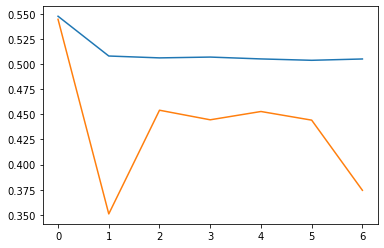

iteration:  1
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


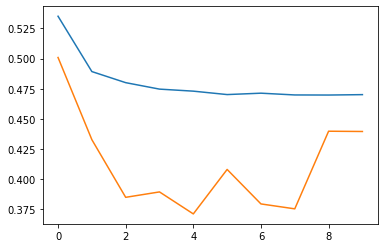

iteration:  2
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


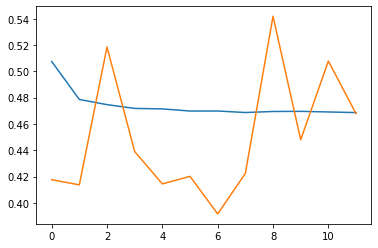

iteration:  3
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


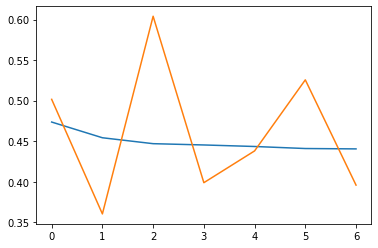

iteration:  4
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


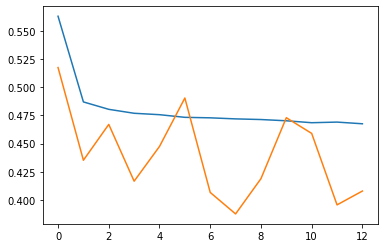

iteration:  5
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


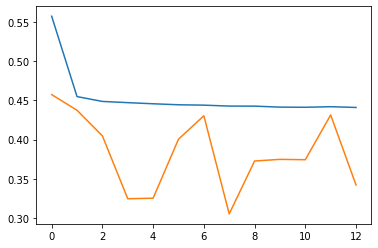

iteration:  6
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


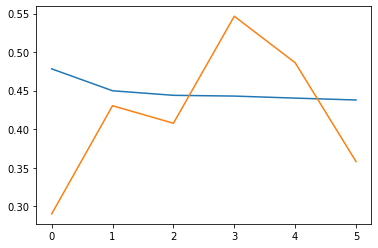

iteration:  7
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


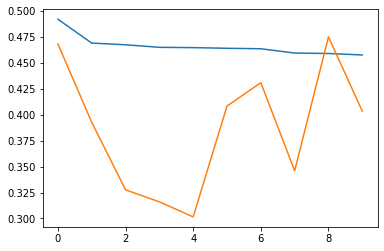

iteration:  8
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


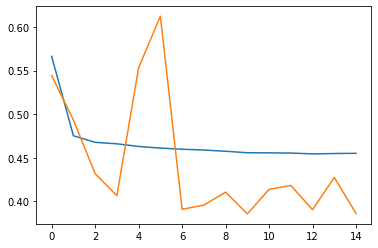

iteration:  9
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


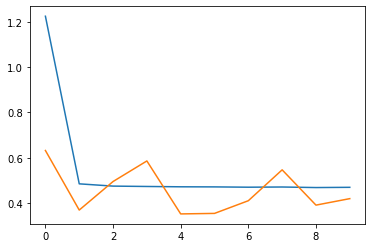

iteration:  10
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


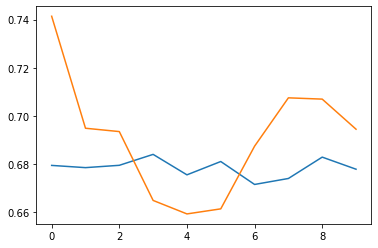

iteration:  11
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


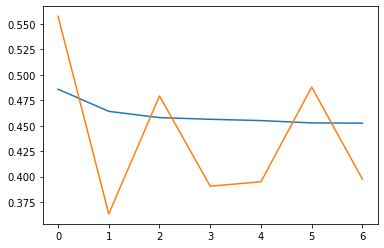

iteration:  12
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


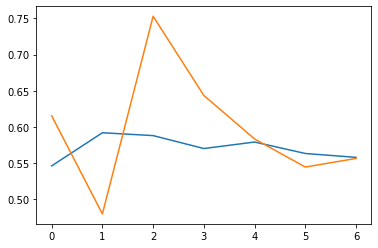

iteration:  13
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


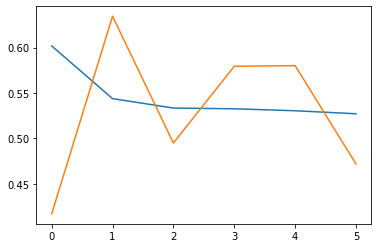

iteration:  14
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


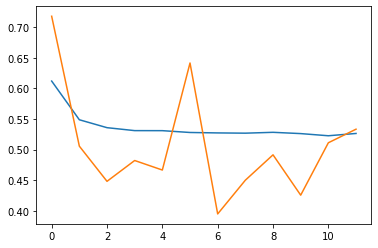

iteration:  15
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


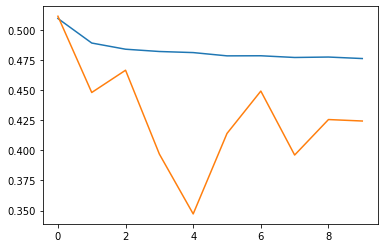

iteration:  16
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


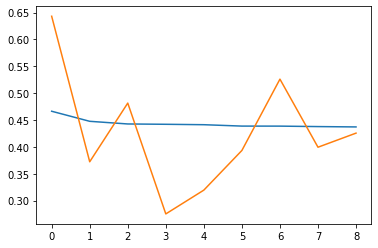

iteration:  17
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


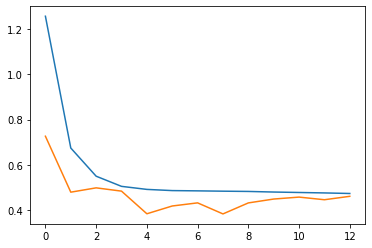

iteration:  18
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


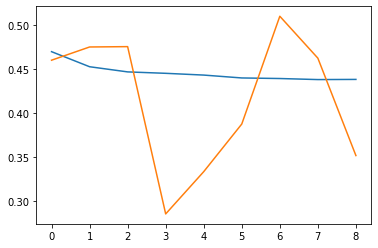

iteration:  19
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


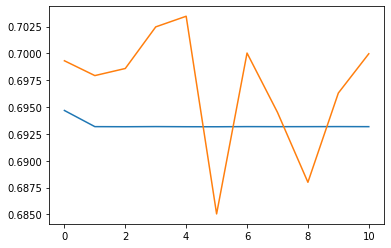

iteration:  0
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


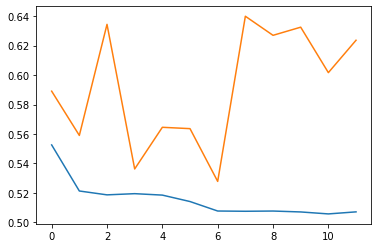

iteration:  1
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


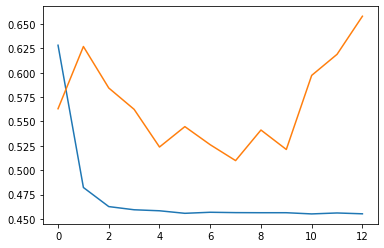

iteration:  2
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


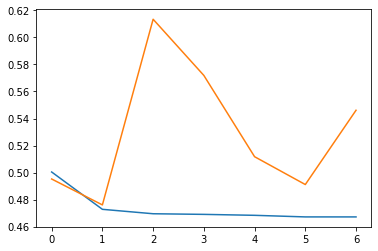

iteration:  3
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


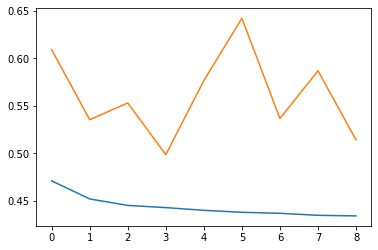

iteration:  4
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


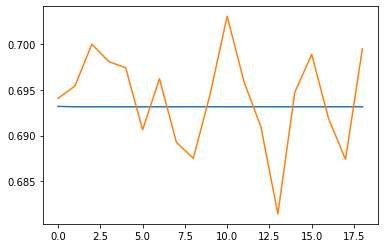

iteration:  5
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


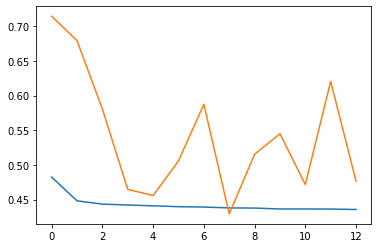

iteration:  6
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


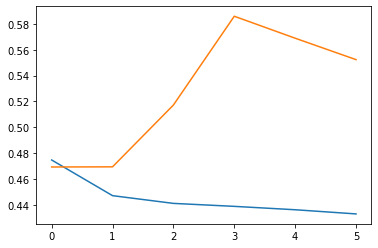

iteration:  7
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


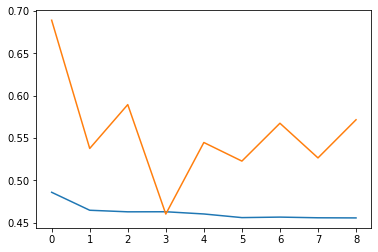

iteration:  8
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5


In [ ]:

# Define number of trials in Random search.
n_trials=20

param_list=mlp.mlp_param_sampler(n_trials, len(train.columns),7,device)


for normalization in ['Zscore','None','MinMax','Median']:

    xtrain_aux=mlp_pipeline.normalization_transform(xtrain,normalization,train.columns.difference(['fraud_bool']))
    xval_aux=mlp_pipeline.normalization_transform(xval,normalization,train.columns.difference(['fraud_bool']))
    i=0

    for params in param_list[i:]:

        # Fit pipeline
        print('iteration: ',i)
        
        model=mlp_pipeline.pipeline(device,xtrain_aux,xval_aux,y_train,y_val,params,'None',train.columns.difference(['fraud_bool']))

        #Save the model
        joblib.dump(model,'/content/gdrive/MyDrive/tab_norm_folder/mlp_target{}{}.pkl'.format(normalization,i))

        i=i+1
    del xval_aux
    del xtrain_aux
    gc.collect()

In [15]:
import category_encoders
catboost_encoder=category_encoders.cat_boost.CatBoostEncoder(cols=cat_cols,handle_unknown='value',handle_missing='value',drop_invariant=False,return_df=True,sigma=0)
xtrain_cat=catboost_encoder.fit_transform(X_train,y_train)
xval_cat=catboost_encoder.transform(X_val)

iteration:  0
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


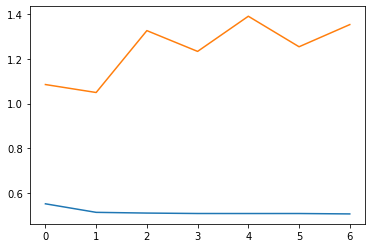

iteration:  1
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


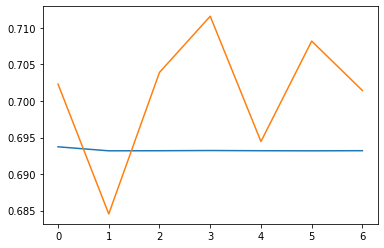

iteration:  2
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


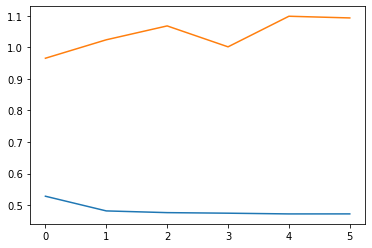

iteration:  3
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


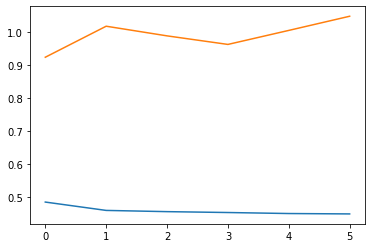

iteration:  4
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


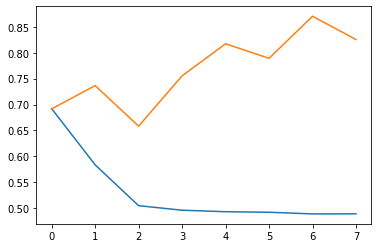

iteration:  5
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


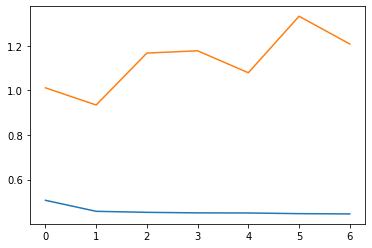

iteration:  6
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


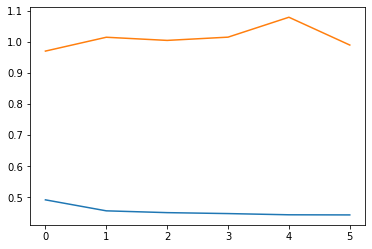

iteration:  7
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


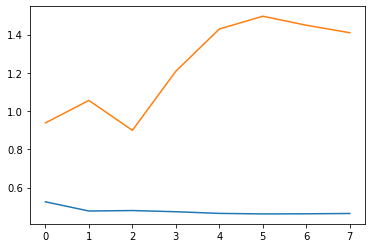

iteration:  8
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


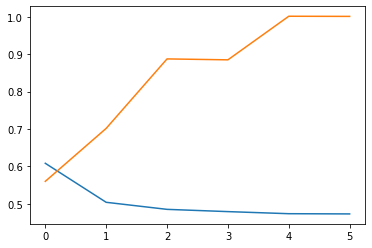

iteration:  9
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


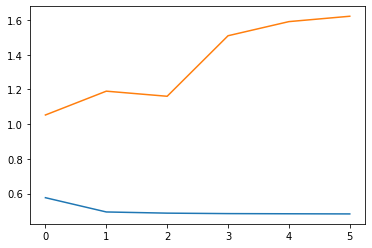

iteration:  10
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


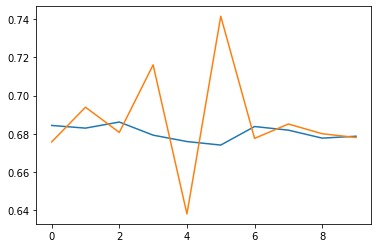

iteration:  11
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


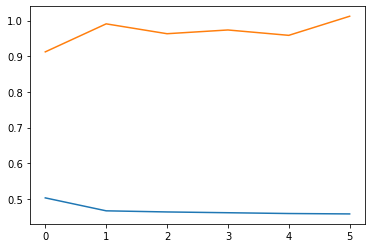

iteration:  12
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


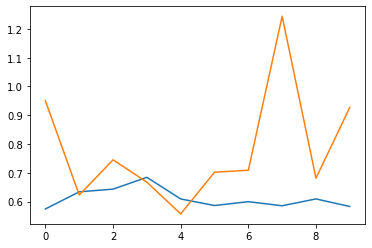

iteration:  13
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


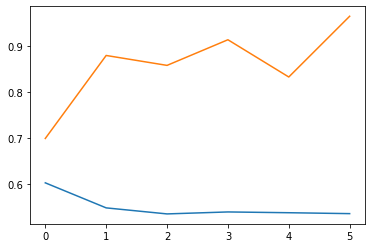

iteration:  14
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


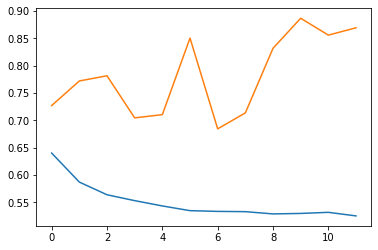

iteration:  15
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


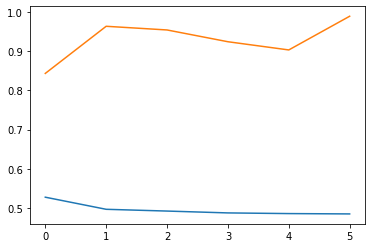

iteration:  16
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


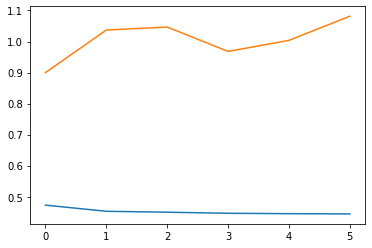

iteration:  17
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


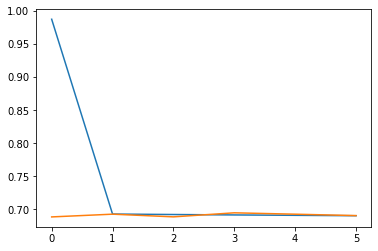

iteration:  18
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


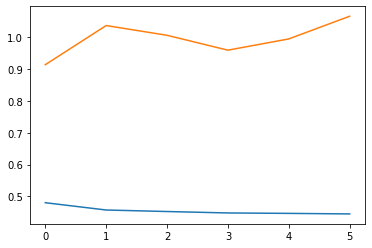

iteration:  19
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


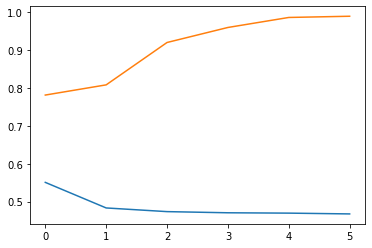

In [ ]:
import mlp
import mlp_pipeline
mlp_pipeline=importlib.reload(mlp_pipeline)

# Define number of trials in Random search.
n_trials=20

param_list=mlp.mlp_param_sampler(n_trials, len(train.columns),7,device)
i=0


for normalization in ['Zscore','None','MinMax','Median']:
    xtrain_aux=mlp_pipeline.normalization_transform(xtrain_cat,normalization,train.columns.difference(['fraud_bool']))
    xval_aux=mlp_pipeline.normalization_transform(xval_cat,normalization,train.columns.difference(['fraud_bool']))
    i=0
    for params in param_list[i:]:

        # Fit pipeline
        print('iteration: ',i)
        
        model=mlp_pipeline.pipeline(device,xtrain_aux,xval_aux,y_train,y_val,params,'None',train.columns.difference(['fraud_bool']))

        #Save the model
        joblib.dump(model,'/content/gdrive/MyDrive/tab_norm_folder/mlp_cat{}{}.pkl'.format(normalization,i))

        i=i+1
    del xval_aux
    del xtrain_aux

    gc.collect()

In [14]:
count_encoder=category_encoders.count.CountEncoder(cols=cat_cols,verbose=0,handle_unknown='value',handle_missing='value',normalize=True,min_group_size=0.005,min_group_name='Leftover',combine_min_nan_groups=False)
xtrain_cont=count_encoder.fit_transform(X_train,y_train)
xval_cont=count_encoder.transform(X_val)

iteration:  17
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


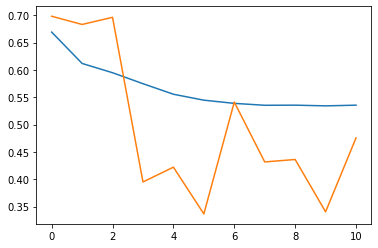

iteration:  18
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


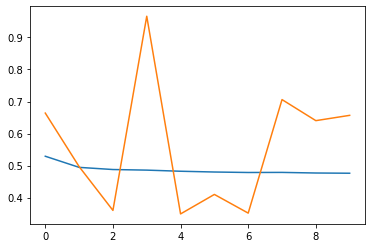

iteration:  19
----------Method:  None -------------
Train size:  794989 ; Number of 0:  786838 ; Number of 1: 8151
Val size:  108168 ; Number of 0:  106718 ; Number of 1: 1450
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
EarlyStopping counter: 3 out of 5
EarlyStopping counter: 4 out of 5
EarlyStopping counter: 5 out of 5
Early stopping


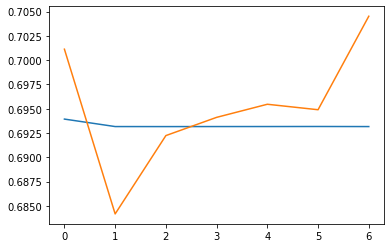

In [ ]:
import mlp
import mlp_pipeline
mlp_pipeline=importlib.reload(mlp_pipeline)

# Define number of trials in Random search.
n_trials=20
# Random state for sampling seeds.
np.random.seed(42)

# Variable to store the results.
runs = {}
param_list=mlp.mlp_param_sampler(n_trials, len(train.columns),7,device)

for normalization in ['None','Zscore','MinMax','Median']:
    xtrain_aux=mlp_pipeline.normalization_transform(xtrain_cont,normalization,train.columns.difference(['fraud_bool']))
    xval_aux=mlp_pipeline.normalization_transform(xval_cont,normalization,train.columns.difference(['fraud_bool']))
    i=0
    for params in param_list[i:]:

        # Fit pipeline
        print('iteration: ',i)
        
        model=mlp_pipeline.pipeline(device,xtrain_aux,xval_aux,y_train,y_val,params,'None',train.columns.difference(['fraud_bool']))

        #Save the model
        joblib.dump(model,'/content/gdrive/MyDrive/tab_norm_folder/mlp_count{}{}.pkl'.format(normalization,i))

        i=i+1
    del xval_aux  
    del xtrain_aux  
    gc.collect()

In [16]:
joblib.dump(count_encoder,'tab_norm_folder/count_encoderBAF.pkl')
joblib.dump(target_encoder,'tab_norm_folder/target_encoderBAF.pkl')
joblib.dump(catboost_encoder,'tab_norm_folder/catboost_encoderBAF.pkl')

['/content/gdrive/MyDrive/tab_norm_folder/count_encoderBAF.pkl']

In [13]:
param_list=lgbm.lgbm_param_sampler(20,7,'cpu')

In [16]:
for encoding in ['count']:
    encoder_link="tab_norm_folder-20230202/tab_norm_folder/{}_encoderBAF.pkl".format(encoding)
    encoder = joblib.load(encoder_link)
    xtrain=encoder.transform(X_train)
    xval=encoder.transform(X_val)
    X_val_aux=torch.cat([torch.tensor(xval[cat_cols].values),transformed_val],1).float()
    X_train_aux=torch.cat([torch.tensor(xtrain[cat_cols].values),transformed_train],1).float()

    

    i=0
    n_trials=20
    np.random.seed(42)
    # Seeds for the random search sampling algorithm.
    seeds = np.random.choice(list(range(1_000_000)), size=n_trials, replace=False)

    # Variable to store the results.
    i=0
    runs={}
    for trial in range(n_trials):
        seed = seeds[trial]
        trial = RandomValueTrial(seed=seed)
        # Hyperparameters for the random search trial.
        test_hyperparams = suggest_callable_hyperparams(trial, hyperparam_space)
        del test_hyperparams["classpath"] # Remove unnecessary key in hyperparaemters.
    
    # Update list of tested hyperparameters.
        prev_hyperparams = runs.get("hyperparams", [])
        prev_hyperparams.append(test_hyperparams)
    
        model = lgb.LGBMClassifier(n_jobs=10, **test_hyperparams)  # Instantiate LGBM Model.
        
        # Fit model to training data.
        model.fit(X_train_aux, y_train, categorical_feature=[],eval_set=[(X_val_aux,y_val)],early_stopping_rounds=5,eval_metric='loss')
        # Obtain predictions in test data.
        predictions = model.predict_proba(X_val_aux)[:, 1]
        print(skl.metrics.roc_auc_score(y_val,predictions))
        joblib.dump(model,'LGBM_BAF/lgbm_numericalemb_{}{}.pkl'.format(encoding,i))
        i=i+1

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[1]	valid_0's binary_logloss: 0.0681131
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.066329
[3]	valid_0's binary_logloss: 0.0649129
[4]	valid_0's binary_logloss: 0.0638694
[5]	valid_0's binary_logloss: 0.0628464
[6]	valid_0's binary_logloss: 0.0620922
[7]	valid_0's binary_logloss: 0.0614305
[8]	valid_0's binary_logloss: 0.0609003
[9]	valid_0's binary_logloss: 0.0603758
[10]	valid_0's binary_logloss: 0.0599283
[11]	valid_0's binary_logloss: 0.0595275
[12]	valid_0's binary_logloss: 0.0591288
[13]	valid_0's binary_logloss: 0.0588303
[14]	valid_0's binary_logloss: 0.058503
[15]	valid_0's binary_logloss: 0.0581863
[16]	valid_0's binary_logloss: 0.0579152
[17]	valid_0's binary_logloss: 0.0576766
[18]	valid_0's binary_logloss: 0.0574441
[19]	valid_0's binary_logloss: 0.0572307
[20]	valid_0's binary_logloss: 0.0569869
[21]	vali

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[1]	valid_0's binary_logloss: 0.0688322
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0674118
[3]	valid_0's binary_logloss: 0.0662035
[4]	valid_0's binary_logloss: 0.0651419
[5]	valid_0's binary_logloss: 0.0642431
[6]	valid_0's binary_logloss: 0.0634551
[7]	valid_0's binary_logloss: 0.0628896
[8]	valid_0's binary_logloss: 0.0623372
[9]	valid_0's binary_logloss: 0.0618849
[10]	valid_0's binary_logloss: 0.0615104
[11]	valid_0's binary_logloss: 0.0610423
[12]	valid_0's binary_logloss: 0.0606512
[13]	valid_0's binary_logloss: 0.0602686
[14]	valid_0's binary_logloss: 0.0599426
[15]	valid_0's binary_logloss: 0.0596758
[16]	valid_0's binary_logloss: 0.0593422
[17]	valid_0's binary_logloss: 0.0590403
[18]	valid_0's binary_logloss: 0.0587857
[19]	valid_0's binary_logloss: 0.0585534
[20]	valid_0's binary_logloss: 0.0583587
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.0583587
0.858915433585518
[LightGBM] [Warning] m

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[1]	valid_0's binary_logloss: 0.0668173
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0648892
[3]	valid_0's binary_logloss: 0.063531
[4]	valid_0's binary_logloss: 0.0624161
[5]	valid_0's binary_logloss: 0.0615362
[6]	valid_0's binary_logloss: 0.0609207
[7]	valid_0's binary_logloss: 0.0603118
[8]	valid_0's binary_logloss: 0.0597485
[9]	valid_0's binary_logloss: 0.0592818
[10]	valid_0's binary_logloss: 0.0589074
[11]	valid_0's binary_logloss: 0.0585867
[12]	valid_0's binary_logloss: 0.0582717
[13]	valid_0's binary_logloss: 0.0579783
[14]	valid_0's binary_logloss: 0.0577166
[15]	valid_0's binary_logloss: 0.0575368
[16]	valid_0's binary_logloss: 0.0573355
[17]	valid_0's binary_logloss: 0.0571712
[18]	valid_0's binary_logloss: 0.0570739
[19]	valid_0's binary_logloss: 0.0569357
[20]	valid_0's binary_logloss: 0.0568152
[21]	valid_0's binary_logloss: 0.0566689
[22]	valid_0's binary_logloss: 0.0565703
[23]	valid_0's binary_logloss: 0.0564512
[24]	va

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[1]	valid_0's binary_logloss: 0.069558
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0681149
[3]	valid_0's binary_logloss: 0.0669808
[4]	valid_0's binary_logloss: 0.0660472
[5]	valid_0's binary_logloss: 0.0652884
[6]	valid_0's binary_logloss: 0.0645866
[7]	valid_0's binary_logloss: 0.0639702
[8]	valid_0's binary_logloss: 0.0633946
[9]	valid_0's binary_logloss: 0.0628847
[10]	valid_0's binary_logloss: 0.0624125
[11]	valid_0's binary_logloss: 0.0619892
[12]	valid_0's binary_logloss: 0.0616168
[13]	valid_0's binary_logloss: 0.0612126
[14]	valid_0's binary_logloss: 0.060881
[15]	valid_0's binary_logloss: 0.0605511
[16]	valid_0's binary_logloss: 0.0602907
[17]	valid_0's binary_logloss: 0.0600187
[18]	valid_0's binary_logloss: 0.0597646
[19]	valid_0's binary_logloss: 0.0595025
[20]	valid_0's binary_logloss: 0.0592598
[21]	valid_0's binary_logloss: 0.0590322
[22]	valid_0's binary_logloss: 0.058825
[23]	valid_0's binary_logloss: 0.0586263
[24]	vali

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[1]	valid_0's binary_logloss: 0.0696809
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0684218
[3]	valid_0's binary_logloss: 0.0674767
[4]	valid_0's binary_logloss: 0.066684
[5]	valid_0's binary_logloss: 0.0659643
[6]	valid_0's binary_logloss: 0.0653809
[7]	valid_0's binary_logloss: 0.0647411
[8]	valid_0's binary_logloss: 0.0642641
[9]	valid_0's binary_logloss: 0.0637559
[10]	valid_0's binary_logloss: 0.0633426
[11]	valid_0's binary_logloss: 0.0629629
[12]	valid_0's binary_logloss: 0.0625918
[13]	valid_0's binary_logloss: 0.062228
[14]	valid_0's binary_logloss: 0.0618869
[15]	valid_0's binary_logloss: 0.0616379
[16]	valid_0's binary_logloss: 0.0613733
[17]	valid_0's binary_logloss: 0.0611223
[18]	valid_0's binary_logloss: 0.0608907
[19]	valid_0's binary_logloss: 0.0606477
[20]	valid_0's binary_logloss: 0.0603644
[21]	valid_0's binary_logloss: 0.0601238
[22]	valid_0's binary_logloss: 0.0598981
[23]	valid_0's binary_logloss: 0.0596733
[24]	val

[199]	valid_0's binary_logloss: 0.0532078
[200]	valid_0's binary_logloss: 0.0531929
[201]	valid_0's binary_logloss: 0.0531926
[202]	valid_0's binary_logloss: 0.0531895
[203]	valid_0's binary_logloss: 0.0531879
[204]	valid_0's binary_logloss: 0.0531855
[205]	valid_0's binary_logloss: 0.0531853
[206]	valid_0's binary_logloss: 0.0531874
[207]	valid_0's binary_logloss: 0.0531803
[208]	valid_0's binary_logloss: 0.0531784
[209]	valid_0's binary_logloss: 0.0531709
[210]	valid_0's binary_logloss: 0.0531621
[211]	valid_0's binary_logloss: 0.0531582
[212]	valid_0's binary_logloss: 0.0531586
[213]	valid_0's binary_logloss: 0.0531524
[214]	valid_0's binary_logloss: 0.0531479
[215]	valid_0's binary_logloss: 0.0531433
[216]	valid_0's binary_logloss: 0.0531515
[217]	valid_0's binary_logloss: 0.0531505
[218]	valid_0's binary_logloss: 0.0531469
[219]	valid_0's binary_logloss: 0.0531485
[220]	valid_0's binary_logloss: 0.0531435
Early stopping, best iteration is:
[215]	valid_0's binary_logloss: 0.0531433

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[1]	valid_0's binary_logloss: 0.0693437
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0679699
[3]	valid_0's binary_logloss: 0.066848
[4]	valid_0's binary_logloss: 0.0659746
[5]	valid_0's binary_logloss: 0.0652133
[6]	valid_0's binary_logloss: 0.0645628
[7]	valid_0's binary_logloss: 0.0639599
[8]	valid_0's binary_logloss: 0.0633963
[9]	valid_0's binary_logloss: 0.0629008
[10]	valid_0's binary_logloss: 0.0623959
[11]	valid_0's binary_logloss: 0.0620071
[12]	valid_0's binary_logloss: 0.0615804
[13]	valid_0's binary_logloss: 0.0612512
[14]	valid_0's binary_logloss: 0.0609434
[15]	valid_0's binary_logloss: 0.0606374
[16]	valid_0's binary_logloss: 0.0603279
[17]	valid_0's binary_logloss: 0.0600455
[18]	valid_0's binary_logloss: 0.059819
[19]	valid_0's binary_logloss: 0.0595843
[20]	valid_0's binary_logloss: 0.0593735
[21]	valid_0's binary_logloss: 0.0591651
[22]	valid_0's binary_logloss: 0.0589276
[23]	valid_0's binary_logloss: 0.0587295
[24]	val

[198]	valid_0's binary_logloss: 0.0532848
[199]	valid_0's binary_logloss: 0.053283
[200]	valid_0's binary_logloss: 0.053286
[201]	valid_0's binary_logloss: 0.0532836
[202]	valid_0's binary_logloss: 0.05328
[203]	valid_0's binary_logloss: 0.053278
[204]	valid_0's binary_logloss: 0.0532804
[205]	valid_0's binary_logloss: 0.0532782
[206]	valid_0's binary_logloss: 0.0532727
[207]	valid_0's binary_logloss: 0.0532814
[208]	valid_0's binary_logloss: 0.0532813
[209]	valid_0's binary_logloss: 0.0532813
[210]	valid_0's binary_logloss: 0.0532786
[211]	valid_0's binary_logloss: 0.0532787
Early stopping, best iteration is:
[206]	valid_0's binary_logloss: 0.0532727
0.8911336225475971
[LightGBM] [Warning] min_data_in_leaf is set=109, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=109


C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[1]	valid_0's binary_logloss: 0.0698584
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0686465
[3]	valid_0's binary_logloss: 0.0676693
[4]	valid_0's binary_logloss: 0.0667487
[5]	valid_0's binary_logloss: 0.0660219
[6]	valid_0's binary_logloss: 0.0653483
[7]	valid_0's binary_logloss: 0.0647959
[8]	valid_0's binary_logloss: 0.0642389
[9]	valid_0's binary_logloss: 0.06377
[10]	valid_0's binary_logloss: 0.0632864
[11]	valid_0's binary_logloss: 0.0629019
[12]	valid_0's binary_logloss: 0.0625236
[13]	valid_0's binary_logloss: 0.0621718
[14]	valid_0's binary_logloss: 0.0618383
[15]	valid_0's binary_logloss: 0.0615363
[16]	valid_0's binary_logloss: 0.0612425
[17]	valid_0's binary_logloss: 0.0609749
[18]	valid_0's binary_logloss: 0.0607211
[19]	valid_0's binary_logloss: 0.0604844
[20]	valid_0's binary_logloss: 0.0602627
[21]	valid_0's binary_logloss: 0.0600525
[22]	valid_0's binary_logloss: 0.0598304
[23]	valid_0's binary_logloss: 0.0596531
[24]	val

[198]	valid_0's binary_logloss: 0.0531567
[199]	valid_0's binary_logloss: 0.0531486
[200]	valid_0's binary_logloss: 0.0531481
[201]	valid_0's binary_logloss: 0.0531449
[202]	valid_0's binary_logloss: 0.05314
[203]	valid_0's binary_logloss: 0.0531342
[204]	valid_0's binary_logloss: 0.0531274
[205]	valid_0's binary_logloss: 0.0531216
[206]	valid_0's binary_logloss: 0.0531186
[207]	valid_0's binary_logloss: 0.053114
[208]	valid_0's binary_logloss: 0.0531083
[209]	valid_0's binary_logloss: 0.053104
[210]	valid_0's binary_logloss: 0.053092
[211]	valid_0's binary_logloss: 0.0530846
[212]	valid_0's binary_logloss: 0.0530842
[213]	valid_0's binary_logloss: 0.0530762
[214]	valid_0's binary_logloss: 0.0530716
[215]	valid_0's binary_logloss: 0.0530663
[216]	valid_0's binary_logloss: 0.0530618
[217]	valid_0's binary_logloss: 0.0530582
[218]	valid_0's binary_logloss: 0.0530621
[219]	valid_0's binary_logloss: 0.0530621
[220]	valid_0's binary_logloss: 0.0530578
[221]	valid_0's binary_logloss: 0.05305

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[1]	valid_0's binary_logloss: 0.068139
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0664297
[3]	valid_0's binary_logloss: 0.0650916
[4]	valid_0's binary_logloss: 0.0640715
[5]	valid_0's binary_logloss: 0.0631559
[6]	valid_0's binary_logloss: 0.0623958
[7]	valid_0's binary_logloss: 0.0617069
[8]	valid_0's binary_logloss: 0.0611545
[9]	valid_0's binary_logloss: 0.0606667
[10]	valid_0's binary_logloss: 0.0602208
[11]	valid_0's binary_logloss: 0.0597601
[12]	valid_0's binary_logloss: 0.0593637
[13]	valid_0's binary_logloss: 0.0590135
[14]	valid_0's binary_logloss: 0.0587212
[15]	valid_0's binary_logloss: 0.0584349
[16]	valid_0's binary_logloss: 0.0581879
[17]	valid_0's binary_logloss: 0.0579598
[18]	valid_0's binary_logloss: 0.0577572
[19]	valid_0's binary_logloss: 0.0575264
[20]	valid_0's binary_logloss: 0.0572949
[21]	valid_0's binary_logloss: 0.0571314
[22]	valid_0's binary_logloss: 0.0569154
[23]	valid_0's binary_logloss: 0.0567468
[24]	va

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[1]	valid_0's binary_logloss: 0.0702777
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.06936
[3]	valid_0's binary_logloss: 0.0685508
[4]	valid_0's binary_logloss: 0.0678317
[5]	valid_0's binary_logloss: 0.0672225
[6]	valid_0's binary_logloss: 0.0666718
[7]	valid_0's binary_logloss: 0.0662149
[8]	valid_0's binary_logloss: 0.0657637
[9]	valid_0's binary_logloss: 0.0653465
[10]	valid_0's binary_logloss: 0.0649537
[11]	valid_0's binary_logloss: 0.0646079
[12]	valid_0's binary_logloss: 0.0642453
[13]	valid_0's binary_logloss: 0.063923
[14]	valid_0's binary_logloss: 0.0635746
[15]	valid_0's binary_logloss: 0.0632957
[16]	valid_0's binary_logloss: 0.0630068
[17]	valid_0's binary_logloss: 0.0627356
[18]	valid_0's binary_logloss: 0.0624985
[19]	valid_0's binary_logloss: 0.0622483
[20]	valid_0's binary_logloss: 0.0620153
[21]	valid_0's binary_logloss: 0.0617956
[22]	valid_0's binary_logloss: 0.0615829
[23]	valid_0's binary_logloss: 0.0613774
[24]	vali

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[1]	valid_0's binary_logloss: 0.065921
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0639672
[3]	valid_0's binary_logloss: 0.0627678
[4]	valid_0's binary_logloss: 0.0616433
[5]	valid_0's binary_logloss: 0.0608459
[6]	valid_0's binary_logloss: 0.0601024
[7]	valid_0's binary_logloss: 0.0595059
[8]	valid_0's binary_logloss: 0.059027
[9]	valid_0's binary_logloss: 0.0585946
[10]	valid_0's binary_logloss: 0.0581492
[11]	valid_0's binary_logloss: 0.05784
[12]	valid_0's binary_logloss: 0.0575614
[13]	valid_0's binary_logloss: 0.0572644
[14]	valid_0's binary_logloss: 0.0569836
[15]	valid_0's binary_logloss: 0.0567709
[16]	valid_0's binary_logloss: 0.056599
[17]	valid_0's binary_logloss: 0.0564091
[18]	valid_0's binary_logloss: 0.0562694
[19]	valid_0's binary_logloss: 0.0560924
[20]	valid_0's binary_logloss: 0.0559751
[21]	valid_0's binary_logloss: 0.0558572
[22]	valid_0's binary_logloss: 0.055729
[23]	valid_0's binary_logloss: 0.0556329
[24]	valid_0

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[1]	valid_0's binary_logloss: 0.0698706
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0686605
[3]	valid_0's binary_logloss: 0.0677185
[4]	valid_0's binary_logloss: 0.0668772
[5]	valid_0's binary_logloss: 0.0661794
[6]	valid_0's binary_logloss: 0.0655636
[7]	valid_0's binary_logloss: 0.0650274
[8]	valid_0's binary_logloss: 0.0645559
[9]	valid_0's binary_logloss: 0.0640359
[10]	valid_0's binary_logloss: 0.0635857
[11]	valid_0's binary_logloss: 0.0631523
[12]	valid_0's binary_logloss: 0.0627571
[13]	valid_0's binary_logloss: 0.0624216
[14]	valid_0's binary_logloss: 0.0621225
[15]	valid_0's binary_logloss: 0.0617989
[16]	valid_0's binary_logloss: 0.0615134
[17]	valid_0's binary_logloss: 0.0612711
[18]	valid_0's binary_logloss: 0.0610153
[19]	valid_0's binary_logloss: 0.0607769
[20]	valid_0's binary_logloss: 0.060587
[21]	valid_0's binary_logloss: 0.0603716
[22]	valid_0's binary_logloss: 0.0601809
[23]	valid_0's binary_logloss: 0.0599698
[24]	va

[199]	valid_0's binary_logloss: 0.0533014
[200]	valid_0's binary_logloss: 0.0532908
[201]	valid_0's binary_logloss: 0.0532866
[202]	valid_0's binary_logloss: 0.0532814
[203]	valid_0's binary_logloss: 0.0532731
[204]	valid_0's binary_logloss: 0.0532703
[205]	valid_0's binary_logloss: 0.0532659
[206]	valid_0's binary_logloss: 0.0532643
[207]	valid_0's binary_logloss: 0.0532626
[208]	valid_0's binary_logloss: 0.0532596
[209]	valid_0's binary_logloss: 0.0532573
[210]	valid_0's binary_logloss: 0.0532524
[211]	valid_0's binary_logloss: 0.0532471
[212]	valid_0's binary_logloss: 0.0532419
[213]	valid_0's binary_logloss: 0.0532347
[214]	valid_0's binary_logloss: 0.0532266
[215]	valid_0's binary_logloss: 0.0532218
[216]	valid_0's binary_logloss: 0.0532152
[217]	valid_0's binary_logloss: 0.0532126
[218]	valid_0's binary_logloss: 0.0532096
[219]	valid_0's binary_logloss: 0.0532103
[220]	valid_0's binary_logloss: 0.0532032
[221]	valid_0's binary_logloss: 0.0531994
[222]	valid_0's binary_logloss: 0.

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[1]	valid_0's binary_logloss: 0.0691057
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0677828
[3]	valid_0's binary_logloss: 0.0666514
[4]	valid_0's binary_logloss: 0.0656969
[5]	valid_0's binary_logloss: 0.0649837
[6]	valid_0's binary_logloss: 0.0643496
[7]	valid_0's binary_logloss: 0.063835
[8]	valid_0's binary_logloss: 0.0633256
[9]	valid_0's binary_logloss: 0.0628881
[10]	valid_0's binary_logloss: 0.062469
[11]	valid_0's binary_logloss: 0.0620545
[12]	valid_0's binary_logloss: 0.061674
[13]	valid_0's binary_logloss: 0.0613084
[14]	valid_0's binary_logloss: 0.0610144
[15]	valid_0's binary_logloss: 0.060714
[16]	valid_0's binary_logloss: 0.0604002
[17]	valid_0's binary_logloss: 0.0601607
[18]	valid_0's binary_logloss: 0.0599023
[19]	valid_0's binary_logloss: 0.0597089
[20]	valid_0's binary_logloss: 0.0594451
[21]	valid_0's binary_logloss: 0.0592311
[22]	valid_0's binary_logloss: 0.0589953
[23]	valid_0's binary_logloss: 0.0588262
[24]	valid

[199]	valid_0's binary_logloss: 0.0529801
[200]	valid_0's binary_logloss: 0.0529802
[201]	valid_0's binary_logloss: 0.052978
[202]	valid_0's binary_logloss: 0.0529744
[203]	valid_0's binary_logloss: 0.0529722
[204]	valid_0's binary_logloss: 0.0529666
[205]	valid_0's binary_logloss: 0.0529579
[206]	valid_0's binary_logloss: 0.0529557
[207]	valid_0's binary_logloss: 0.0529544
[208]	valid_0's binary_logloss: 0.0529533
[209]	valid_0's binary_logloss: 0.0529505
[210]	valid_0's binary_logloss: 0.0529493
[211]	valid_0's binary_logloss: 0.0529445
[212]	valid_0's binary_logloss: 0.0529563
[213]	valid_0's binary_logloss: 0.0529532
[214]	valid_0's binary_logloss: 0.0529497
[215]	valid_0's binary_logloss: 0.0529521
[216]	valid_0's binary_logloss: 0.05295
Early stopping, best iteration is:
[211]	valid_0's binary_logloss: 0.0529445
0.8925795150738879
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63


C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[1]	valid_0's binary_logloss: 0.068352
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0666702
[3]	valid_0's binary_logloss: 0.0654121
[4]	valid_0's binary_logloss: 0.0644253
[5]	valid_0's binary_logloss: 0.0634384
[6]	valid_0's binary_logloss: 0.0627335
[7]	valid_0's binary_logloss: 0.0620531
[8]	valid_0's binary_logloss: 0.0615141
[9]	valid_0's binary_logloss: 0.0610238
[10]	valid_0's binary_logloss: 0.0605753
[11]	valid_0's binary_logloss: 0.0601296
[12]	valid_0's binary_logloss: 0.0597614
[13]	valid_0's binary_logloss: 0.0594202
[14]	valid_0's binary_logloss: 0.0590568
[15]	valid_0's binary_logloss: 0.0587316
[16]	valid_0's binary_logloss: 0.0585184
[17]	valid_0's binary_logloss: 0.0582013
[18]	valid_0's binary_logloss: 0.0579724
[19]	valid_0's binary_logloss: 0.0577306
[20]	valid_0's binary_logloss: 0.0574927
[21]	valid_0's binary_logloss: 0.0573445
[22]	valid_0's binary_logloss: 0.0571674
[23]	valid_0's binary_logloss: 0.0569431
[24]	va

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[1]	valid_0's binary_logloss: 0.0674367
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0653386
[3]	valid_0's binary_logloss: 0.0640942
[4]	valid_0's binary_logloss: 0.0630902
[5]	valid_0's binary_logloss: 0.0622968
[6]	valid_0's binary_logloss: 0.0615014
[7]	valid_0's binary_logloss: 0.0608845
[8]	valid_0's binary_logloss: 0.0603335
[9]	valid_0's binary_logloss: 0.0598624
[10]	valid_0's binary_logloss: 0.0593611
[11]	valid_0's binary_logloss: 0.0589763
[12]	valid_0's binary_logloss: 0.0586191
[13]	valid_0's binary_logloss: 0.0582948
[14]	valid_0's binary_logloss: 0.0580428
[15]	valid_0's binary_logloss: 0.0577712
[16]	valid_0's binary_logloss: 0.0575222
[17]	valid_0's binary_logloss: 0.0573175
[18]	valid_0's binary_logloss: 0.0571004
[19]	valid_0's binary_logloss: 0.0569305
[20]	valid_0's binary_logloss: 0.0567329
[21]	valid_0's binary_logloss: 0.0565755
[22]	valid_0's binary_logloss: 0.0564768
[23]	valid_0's binary_logloss: 0.0563254
[24]	v

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[1]	valid_0's binary_logloss: 0.0704662
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0696223
[3]	valid_0's binary_logloss: 0.0688936
[4]	valid_0's binary_logloss: 0.0682846
[5]	valid_0's binary_logloss: 0.0677488
[6]	valid_0's binary_logloss: 0.0672551
[7]	valid_0's binary_logloss: 0.0668385
[8]	valid_0's binary_logloss: 0.0664258
[9]	valid_0's binary_logloss: 0.0660086
[10]	valid_0's binary_logloss: 0.0656889
[11]	valid_0's binary_logloss: 0.0653287
[12]	valid_0's binary_logloss: 0.0649617
[13]	valid_0's binary_logloss: 0.0646843
[14]	valid_0's binary_logloss: 0.0644057
[15]	valid_0's binary_logloss: 0.0641127
[16]	valid_0's binary_logloss: 0.0638523
[17]	valid_0's binary_logloss: 0.0636231
[18]	valid_0's binary_logloss: 0.0633771
[19]	valid_0's binary_logloss: 0.0631851
[20]	valid_0's binary_logloss: 0.0629731
[21]	valid_0's binary_logloss: 0.0627723
[22]	valid_0's binary_logloss: 0.0625647
[23]	valid_0's binary_logloss: 0.0623905
[24]	v

[200]	valid_0's binary_logloss: 0.0540804
[201]	valid_0's binary_logloss: 0.0540701
[202]	valid_0's binary_logloss: 0.0540633
[203]	valid_0's binary_logloss: 0.0540529
[204]	valid_0's binary_logloss: 0.0540424
[205]	valid_0's binary_logloss: 0.0540343
[206]	valid_0's binary_logloss: 0.0540263
[207]	valid_0's binary_logloss: 0.0540142
[208]	valid_0's binary_logloss: 0.0540049
[209]	valid_0's binary_logloss: 0.0539936
[210]	valid_0's binary_logloss: 0.0539787
[211]	valid_0's binary_logloss: 0.0539667
[212]	valid_0's binary_logloss: 0.0539529
[213]	valid_0's binary_logloss: 0.0539474
[214]	valid_0's binary_logloss: 0.0539349
[215]	valid_0's binary_logloss: 0.0539269
[216]	valid_0's binary_logloss: 0.0539184
[217]	valid_0's binary_logloss: 0.0539084
[218]	valid_0's binary_logloss: 0.0539006
[219]	valid_0's binary_logloss: 0.0538969
[220]	valid_0's binary_logloss: 0.0538922
[221]	valid_0's binary_logloss: 0.0538833
[222]	valid_0's binary_logloss: 0.0538714
[223]	valid_0's binary_logloss: 0.

[397]	valid_0's binary_logloss: 0.0529902
[398]	valid_0's binary_logloss: 0.0529896
[399]	valid_0's binary_logloss: 0.0529847
[400]	valid_0's binary_logloss: 0.0529852
[401]	valid_0's binary_logloss: 0.0529833
[402]	valid_0's binary_logloss: 0.0529815
[403]	valid_0's binary_logloss: 0.0529811
[404]	valid_0's binary_logloss: 0.0529802
[405]	valid_0's binary_logloss: 0.0529782
[406]	valid_0's binary_logloss: 0.052977
[407]	valid_0's binary_logloss: 0.052976
[408]	valid_0's binary_logloss: 0.0529757
[409]	valid_0's binary_logloss: 0.0529743
[410]	valid_0's binary_logloss: 0.0529713
[411]	valid_0's binary_logloss: 0.0529695
[412]	valid_0's binary_logloss: 0.0529684
[413]	valid_0's binary_logloss: 0.0529676
[414]	valid_0's binary_logloss: 0.0529677
[415]	valid_0's binary_logloss: 0.0529664
[416]	valid_0's binary_logloss: 0.0529674
[417]	valid_0's binary_logloss: 0.0529676
[418]	valid_0's binary_logloss: 0.0529641
[419]	valid_0's binary_logloss: 0.0529637
[420]	valid_0's binary_logloss: 0.05

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[1]	valid_0's binary_logloss: 0.0697709
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0685641
[3]	valid_0's binary_logloss: 0.067559
[4]	valid_0's binary_logloss: 0.0667435
[5]	valid_0's binary_logloss: 0.066062
[6]	valid_0's binary_logloss: 0.0654477
[7]	valid_0's binary_logloss: 0.0648547
[8]	valid_0's binary_logloss: 0.0643432
[9]	valid_0's binary_logloss: 0.0638812
[10]	valid_0's binary_logloss: 0.0633973
[11]	valid_0's binary_logloss: 0.062972
[12]	valid_0's binary_logloss: 0.0626004
[13]	valid_0's binary_logloss: 0.0622121
[14]	valid_0's binary_logloss: 0.0618936
[15]	valid_0's binary_logloss: 0.0615698
[16]	valid_0's binary_logloss: 0.0612831
[17]	valid_0's binary_logloss: 0.0610362
[18]	valid_0's binary_logloss: 0.060761
[19]	valid_0's binary_logloss: 0.0605177
[20]	valid_0's binary_logloss: 0.0602696
[21]	valid_0's binary_logloss: 0.0600733
[22]	valid_0's binary_logloss: 0.0598654
[23]	valid_0's binary_logloss: 0.0596694
[24]	valid

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[1]	valid_0's binary_logloss: 0.0695285
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0681941
[3]	valid_0's binary_logloss: 0.0671422
[4]	valid_0's binary_logloss: 0.0662638
[5]	valid_0's binary_logloss: 0.0655278
[6]	valid_0's binary_logloss: 0.0648997
[7]	valid_0's binary_logloss: 0.0643127
[8]	valid_0's binary_logloss: 0.0637923
[9]	valid_0's binary_logloss: 0.0632804
[10]	valid_0's binary_logloss: 0.0628248
[11]	valid_0's binary_logloss: 0.0623886
[12]	valid_0's binary_logloss: 0.0620084
[13]	valid_0's binary_logloss: 0.061606
[14]	valid_0's binary_logloss: 0.0612924
[15]	valid_0's binary_logloss: 0.0610025
[16]	valid_0's binary_logloss: 0.0607112
[17]	valid_0's binary_logloss: 0.0604352
[18]	valid_0's binary_logloss: 0.0601907
[19]	valid_0's binary_logloss: 0.0599652
[20]	valid_0's binary_logloss: 0.0597762
[21]	valid_0's binary_logloss: 0.059546
[22]	valid_0's binary_logloss: 0.0593409
[23]	valid_0's binary_logloss: 0.0591533
[24]	val

[199]	valid_0's binary_logloss: 0.0532279
[200]	valid_0's binary_logloss: 0.053229
[201]	valid_0's binary_logloss: 0.0532285
[202]	valid_0's binary_logloss: 0.0532308
[203]	valid_0's binary_logloss: 0.0532288
[204]	valid_0's binary_logloss: 0.0532254
[205]	valid_0's binary_logloss: 0.0532226
[206]	valid_0's binary_logloss: 0.0532208
[207]	valid_0's binary_logloss: 0.0532223
[208]	valid_0's binary_logloss: 0.0532209
[209]	valid_0's binary_logloss: 0.0532165
[210]	valid_0's binary_logloss: 0.053212
[211]	valid_0's binary_logloss: 0.0532126
[212]	valid_0's binary_logloss: 0.0532078
[213]	valid_0's binary_logloss: 0.0532055
[214]	valid_0's binary_logloss: 0.0532018
[215]	valid_0's binary_logloss: 0.0531944
[216]	valid_0's binary_logloss: 0.0531901
[217]	valid_0's binary_logloss: 0.0531855
[218]	valid_0's binary_logloss: 0.053183
[219]	valid_0's binary_logloss: 0.053185
[220]	valid_0's binary_logloss: 0.0531819
[221]	valid_0's binary_logloss: 0.0531768
[222]	valid_0's binary_logloss: 0.0531

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[1]	valid_0's binary_logloss: 0.0670987
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0651339
[3]	valid_0's binary_logloss: 0.0639018
[4]	valid_0's binary_logloss: 0.0628963
[5]	valid_0's binary_logloss: 0.0619986
[6]	valid_0's binary_logloss: 0.0611878
[7]	valid_0's binary_logloss: 0.0606301
[8]	valid_0's binary_logloss: 0.0600405
[9]	valid_0's binary_logloss: 0.0594615
[10]	valid_0's binary_logloss: 0.0590356
[11]	valid_0's binary_logloss: 0.0586921
[12]	valid_0's binary_logloss: 0.0583234
[13]	valid_0's binary_logloss: 0.0580076
[14]	valid_0's binary_logloss: 0.0577517
[15]	valid_0's binary_logloss: 0.0575055
[16]	valid_0's binary_logloss: 0.0572702
[17]	valid_0's binary_logloss: 0.0571208
[18]	valid_0's binary_logloss: 0.0569281
[19]	valid_0's binary_logloss: 0.0567849
[20]	valid_0's binary_logloss: 0.05663
[21]	valid_0's binary_logloss: 0.0565046
[22]	valid_0's binary_logloss: 0.0563665
[23]	valid_0's binary_logloss: 0.0562278
[24]	val

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[1]	valid_0's binary_logloss: 0.0697379
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0686295
[3]	valid_0's binary_logloss: 0.0677311
[4]	valid_0's binary_logloss: 0.0669135
[5]	valid_0's binary_logloss: 0.0662432
[6]	valid_0's binary_logloss: 0.0656487
[7]	valid_0's binary_logloss: 0.0651307
[8]	valid_0's binary_logloss: 0.0646165
[9]	valid_0's binary_logloss: 0.0641984
[10]	valid_0's binary_logloss: 0.06387
[11]	valid_0's binary_logloss: 0.0635141
[12]	valid_0's binary_logloss: 0.0632082
[13]	valid_0's binary_logloss: 0.0628549
[14]	valid_0's binary_logloss: 0.0625536
[15]	valid_0's binary_logloss: 0.0622756
[16]	valid_0's binary_logloss: 0.0619978
[17]	valid_0's binary_logloss: 0.0617409
[18]	valid_0's binary_logloss: 0.0614872
[19]	valid_0's binary_logloss: 0.0612891
[20]	valid_0's binary_logloss: 0.0610298
[21]	valid_0's binary_logloss: 0.0607947
[22]	valid_0's binary_logloss: 0.0605925
[23]	valid_0's binary_logloss: 0.0603959
[24]	val

[198]	valid_0's binary_logloss: 0.0533173
[199]	valid_0's binary_logloss: 0.0533092
[200]	valid_0's binary_logloss: 0.0533032
[201]	valid_0's binary_logloss: 0.053296
[202]	valid_0's binary_logloss: 0.0532935
[203]	valid_0's binary_logloss: 0.0532809
[204]	valid_0's binary_logloss: 0.0532745
[205]	valid_0's binary_logloss: 0.0532727
[206]	valid_0's binary_logloss: 0.0532649
[207]	valid_0's binary_logloss: 0.0532563
[208]	valid_0's binary_logloss: 0.0532528
[209]	valid_0's binary_logloss: 0.05325
[210]	valid_0's binary_logloss: 0.0532476
[211]	valid_0's binary_logloss: 0.0532394
[212]	valid_0's binary_logloss: 0.053233
[213]	valid_0's binary_logloss: 0.0532259
[214]	valid_0's binary_logloss: 0.0532141
[215]	valid_0's binary_logloss: 0.0532014
[216]	valid_0's binary_logloss: 0.0531987
[217]	valid_0's binary_logloss: 0.053194
[218]	valid_0's binary_logloss: 0.0531918
[219]	valid_0's binary_logloss: 0.0531902
[220]	valid_0's binary_logloss: 0.0531862
[221]	valid_0's binary_logloss: 0.05318

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[1]	valid_0's binary_logloss: 0.0703947
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0695115
[3]	valid_0's binary_logloss: 0.0687516
[4]	valid_0's binary_logloss: 0.0681319
[5]	valid_0's binary_logloss: 0.0675642
[6]	valid_0's binary_logloss: 0.0670515
[7]	valid_0's binary_logloss: 0.0666292
[8]	valid_0's binary_logloss: 0.0662056
[9]	valid_0's binary_logloss: 0.0657936
[10]	valid_0's binary_logloss: 0.0654517
[11]	valid_0's binary_logloss: 0.0650725
[12]	valid_0's binary_logloss: 0.0647297
[13]	valid_0's binary_logloss: 0.0644737
[14]	valid_0's binary_logloss: 0.064148
[15]	valid_0's binary_logloss: 0.0638933
[16]	valid_0's binary_logloss: 0.0636221
[17]	valid_0's binary_logloss: 0.0633694
[18]	valid_0's binary_logloss: 0.0631392
[19]	valid_0's binary_logloss: 0.0629057
[20]	valid_0's binary_logloss: 0.0627057
[21]	valid_0's binary_logloss: 0.0625328
[22]	valid_0's binary_logloss: 0.0623179
[23]	valid_0's binary_logloss: 0.0621356
[24]	va

[200]	valid_0's binary_logloss: 0.0540274
[201]	valid_0's binary_logloss: 0.0540114
[202]	valid_0's binary_logloss: 0.0540001
[203]	valid_0's binary_logloss: 0.0539952
[204]	valid_0's binary_logloss: 0.0539863
[205]	valid_0's binary_logloss: 0.0539773
[206]	valid_0's binary_logloss: 0.0539708
[207]	valid_0's binary_logloss: 0.0539559
[208]	valid_0's binary_logloss: 0.0539425
[209]	valid_0's binary_logloss: 0.0539354
[210]	valid_0's binary_logloss: 0.0539202
[211]	valid_0's binary_logloss: 0.0539147
[212]	valid_0's binary_logloss: 0.0539046
[213]	valid_0's binary_logloss: 0.0539008
[214]	valid_0's binary_logloss: 0.0538899
[215]	valid_0's binary_logloss: 0.0538804
[216]	valid_0's binary_logloss: 0.0538759
[217]	valid_0's binary_logloss: 0.0538659
[218]	valid_0's binary_logloss: 0.0538589
[219]	valid_0's binary_logloss: 0.0538453
[220]	valid_0's binary_logloss: 0.0538386
[221]	valid_0's binary_logloss: 0.0538308
[222]	valid_0's binary_logloss: 0.053825
[223]	valid_0's binary_logloss: 0.0

In [14]:

i=0
n_trials=20
# Random state for sampling seeds.
np.random.seed(42)
# Seeds for the random search sampling algorithm.
seeds = np.random.choice(list(range(1_000_000)), size=n_trials, replace=False)

# Variable to store the results.
runs = {}
i=0
for trial in range(n_trials):
    seed = seeds[trial]
    trial = RandomValueTrial(seed=seed)
    # Hyperparameters for the random search trial.
    test_hyperparams = suggest_callable_hyperparams(trial, hyperparam_space)
    del test_hyperparams["classpath"] # Remove unnecessary key in hyperparaemters.
    
    # Update list of tested hyperparameters.
    prev_hyperparams = runs.get("hyperparams", [])
    prev_hyperparams.append(test_hyperparams)
    runs["hyperparams"] = prev_hyperparams
    model = lgb.LGBMClassifier(n_jobs=10, **test_hyperparams)  # Instantiate LGBM Model.
        
    model.fit(X_train_aux, y_train, categorical_feature=[0,1,2,3,4],eval_set=[(X_val_aux,y_val)],early_stopping_rounds=5,eval_metric='loss')
    predictions = model.predict_proba(X_val_aux)[:, 1]
    print(skl.metrics.roc_auc_score(y_val,predictions))
    joblib.dump(model,'LGBM_BAF/lgbm_numericalemb_label{}.pkl'.format(i))
    i=i+1

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4]
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's binary_logloss: 0.0679747
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0660616
[3]	valid_0's binary_logloss: 0.064683
[4]	valid_0's binary_logloss: 0.0635715
[5]	valid_0's binary_logloss: 0.0626522
[6]	valid_0's binary_logloss: 0.0619171
[7]	valid_0's binary_logloss: 0.0612171
[8]	valid_0's binary_logloss: 0.0605434
[9]	valid_0's binary_logloss: 0.0600561
[10]	valid_0's binary_logloss: 0.059614
[11]	valid_0's binary_logloss: 0.0592684
[12]	valid_0's binary_logloss: 0.0589136
[13]	valid_0's binary_logloss: 0.0585876
[14]	valid_0's binary_logloss: 0.0582697
[15]	valid_0's binary_logloss: 0.0579909
[16]	valid_0's binary_logloss: 0.0577216
[17]	valid_0's binary_logloss: 0.0574665
[18]	valid_0's binary_logloss: 0.0572559
[19]	valid_0's binary_logloss: 0.057047
[20]	valid_0's binary_logloss: 0.0568625
[21]	valid_0's binary_logloss: 0.056714
[22]	valid_0's binary_logloss: 0.0565477
[23]	valid_0's binary_logloss: 0.0563742
[24]	valid

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4]
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's binary_logloss: 0.0687349
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0670545
[3]	valid_0's binary_logloss: 0.0657389
[4]	valid_0's binary_logloss: 0.0647355
[5]	valid_0's binary_logloss: 0.0638477
[6]	valid_0's binary_logloss: 0.0631816
[7]	valid_0's binary_logloss: 0.0625509
[8]	valid_0's binary_logloss: 0.0620166
[9]	valid_0's binary_logloss: 0.0615093
[10]	valid_0's binary_logloss: 0.0610984
[11]	valid_0's binary_logloss: 0.0607366
[12]	valid_0's binary_logloss: 0.0603654
[13]	valid_0's binary_logloss: 0.0600279
[14]	valid_0's binary_logloss: 0.0596732
[15]	valid_0's binary_logloss: 0.0594373
[16]	valid_0's binary_logloss: 0.0591217
[17]	valid_0's binary_logloss: 0.0588604
[18]	valid_0's binary_logloss: 0.0585855
[19]	valid_0's binary_logloss: 0.0583427
[20]	valid_0's binary_logloss: 0.0581511
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.0581511
0.859256687460539
[LightGBM] [Warning] m

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's binary_logloss: 0.0673053
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0655658
[3]	valid_0's binary_logloss: 0.064224
[4]	valid_0's binary_logloss: 0.0630894
[5]	valid_0's binary_logloss: 0.0622445
[6]	valid_0's binary_logloss: 0.0614935
[7]	valid_0's binary_logloss: 0.0609448
[8]	valid_0's binary_logloss: 0.0603405
[9]	valid_0's binary_logloss: 0.0598891
[10]	valid_0's binary_logloss: 0.0595004
[11]	valid_0's binary_logloss: 0.0592355
[12]	valid_0's binary_logloss: 0.0589176
[13]	valid_0's binary_logloss: 0.0586707
[14]	valid_0's binary_logloss: 0.0584333
[15]	valid_0's binary_logloss: 0.0581991
[16]	valid_0's binary_logloss: 0.058057
[17]	valid_0's binary_logloss: 0.0578418
[18]	valid_0's binary_logloss: 0.0577101
[19]	valid_0's binary_logloss: 0.0575245
[20]	valid_0's binary_logloss: 0.0574857
[21]	valid_0's binary_logloss: 0.0573308
[22]	valid_0's binary_logloss: 0.0572543
[23]	valid_0's binary_logloss: 0.0571208
[24]	val

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's binary_logloss: 0.0695759
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0681231
[3]	valid_0's binary_logloss: 0.0669533
[4]	valid_0's binary_logloss: 0.0659409
[5]	valid_0's binary_logloss: 0.0651147
[6]	valid_0's binary_logloss: 0.0643787
[7]	valid_0's binary_logloss: 0.0637479
[8]	valid_0's binary_logloss: 0.0632076
[9]	valid_0's binary_logloss: 0.0626935
[10]	valid_0's binary_logloss: 0.0622271
[11]	valid_0's binary_logloss: 0.0618027
[12]	valid_0's binary_logloss: 0.0613915
[13]	valid_0's binary_logloss: 0.0610038
[14]	valid_0's binary_logloss: 0.0606644
[15]	valid_0's binary_logloss: 0.0603279
[16]	valid_0's binary_logloss: 0.0600265
[17]	valid_0's binary_logloss: 0.0597494
[18]	valid_0's binary_logloss: 0.0595028
[19]	valid_0's binary_logloss: 0.059248
[20]	valid_0's binary_logloss: 0.0590077
[21]	valid_0's binary_logloss: 0.0587957
[22]	valid_0's binary_logloss: 0.0585937
[23]	valid_0's binary_logloss: 0.0584069
[24]	va

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's binary_logloss: 0.0696686
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.068394
[3]	valid_0's binary_logloss: 0.0673699
[4]	valid_0's binary_logloss: 0.0665271
[5]	valid_0's binary_logloss: 0.0657807
[6]	valid_0's binary_logloss: 0.0650967
[7]	valid_0's binary_logloss: 0.0644724
[8]	valid_0's binary_logloss: 0.0639147
[9]	valid_0's binary_logloss: 0.0634798
[10]	valid_0's binary_logloss: 0.0630604
[11]	valid_0's binary_logloss: 0.0626288
[12]	valid_0's binary_logloss: 0.0622951
[13]	valid_0's binary_logloss: 0.0619545
[14]	valid_0's binary_logloss: 0.0616128
[15]	valid_0's binary_logloss: 0.0613446
[16]	valid_0's binary_logloss: 0.0611
[17]	valid_0's binary_logloss: 0.0608283
[18]	valid_0's binary_logloss: 0.0605917
[19]	valid_0's binary_logloss: 0.0603385
[20]	valid_0's binary_logloss: 0.0601268
[21]	valid_0's binary_logloss: 0.0598821
[22]	valid_0's binary_logloss: 0.0596265
[23]	valid_0's binary_logloss: 0.0594053
[24]	valid

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's binary_logloss: 0.0694143
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0678661
[3]	valid_0's binary_logloss: 0.06667
[4]	valid_0's binary_logloss: 0.0657588
[5]	valid_0's binary_logloss: 0.065004
[6]	valid_0's binary_logloss: 0.0643195
[7]	valid_0's binary_logloss: 0.0636736
[8]	valid_0's binary_logloss: 0.0630331
[9]	valid_0's binary_logloss: 0.0625463
[10]	valid_0's binary_logloss: 0.0620557
[11]	valid_0's binary_logloss: 0.0616259
[12]	valid_0's binary_logloss: 0.0612431
[13]	valid_0's binary_logloss: 0.0608199
[14]	valid_0's binary_logloss: 0.0604677
[15]	valid_0's binary_logloss: 0.0601712
[16]	valid_0's binary_logloss: 0.0599148
[17]	valid_0's binary_logloss: 0.0596507
[18]	valid_0's binary_logloss: 0.0594022
[19]	valid_0's binary_logloss: 0.0591806
[20]	valid_0's binary_logloss: 0.0589655
[21]	valid_0's binary_logloss: 0.0587297
[22]	valid_0's binary_logloss: 0.0585413
[23]	valid_0's binary_logloss: 0.0583668
[24]	vali

[199]	valid_0's binary_logloss: 0.0530709
[200]	valid_0's binary_logloss: 0.0530678
[201]	valid_0's binary_logloss: 0.0530711
[202]	valid_0's binary_logloss: 0.0530707
[203]	valid_0's binary_logloss: 0.0530696
[204]	valid_0's binary_logloss: 0.0530686
[205]	valid_0's binary_logloss: 0.0530661
[206]	valid_0's binary_logloss: 0.0530594
[207]	valid_0's binary_logloss: 0.0530622
[208]	valid_0's binary_logloss: 0.0530615
[209]	valid_0's binary_logloss: 0.0530649
[210]	valid_0's binary_logloss: 0.0530648
[211]	valid_0's binary_logloss: 0.0530624
Early stopping, best iteration is:
[206]	valid_0's binary_logloss: 0.0530594
0.8924729305918079
[LightGBM] [Warning] min_data_in_leaf is set=109, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=109


C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's binary_logloss: 0.0697892
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0685146
[3]	valid_0's binary_logloss: 0.0673929
[4]	valid_0's binary_logloss: 0.0665264
[5]	valid_0's binary_logloss: 0.0657492
[6]	valid_0's binary_logloss: 0.0651055
[7]	valid_0's binary_logloss: 0.0644548
[8]	valid_0's binary_logloss: 0.0639288
[9]	valid_0's binary_logloss: 0.0634212
[10]	valid_0's binary_logloss: 0.0629629
[11]	valid_0's binary_logloss: 0.0625434
[12]	valid_0's binary_logloss: 0.0621779
[13]	valid_0's binary_logloss: 0.0618075
[14]	valid_0's binary_logloss: 0.0614628
[15]	valid_0's binary_logloss: 0.0611701
[16]	valid_0's binary_logloss: 0.0609041
[17]	valid_0's binary_logloss: 0.0606569
[18]	valid_0's binary_logloss: 0.0603708
[19]	valid_0's binary_logloss: 0.0601379
[20]	valid_0's binary_logloss: 0.0599257
[21]	valid_0's binary_logloss: 0.0597082
[22]	valid_0's binary_logloss: 0.0595
[23]	valid_0's binary_logloss: 0.0593115
[24]	vali

[198]	valid_0's binary_logloss: 0.0530679
[199]	valid_0's binary_logloss: 0.0530597
[200]	valid_0's binary_logloss: 0.0530581
[201]	valid_0's binary_logloss: 0.0530552
[202]	valid_0's binary_logloss: 0.0530536
[203]	valid_0's binary_logloss: 0.0530535
[204]	valid_0's binary_logloss: 0.0530514
[205]	valid_0's binary_logloss: 0.0530492
[206]	valid_0's binary_logloss: 0.0530433
[207]	valid_0's binary_logloss: 0.0530344
[208]	valid_0's binary_logloss: 0.0530328
[209]	valid_0's binary_logloss: 0.0530306
[210]	valid_0's binary_logloss: 0.0530239
[211]	valid_0's binary_logloss: 0.0530156
[212]	valid_0's binary_logloss: 0.0530112
[213]	valid_0's binary_logloss: 0.0530135
[214]	valid_0's binary_logloss: 0.0530095
[215]	valid_0's binary_logloss: 0.0530064
[216]	valid_0's binary_logloss: 0.0530041
[217]	valid_0's binary_logloss: 0.0530033
[218]	valid_0's binary_logloss: 0.0530004
[219]	valid_0's binary_logloss: 0.0529941
[220]	valid_0's binary_logloss: 0.0529941
[221]	valid_0's binary_logloss: 0.

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's binary_logloss: 0.0681206
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0663915
[3]	valid_0's binary_logloss: 0.0649776
[4]	valid_0's binary_logloss: 0.0638873
[5]	valid_0's binary_logloss: 0.0629158
[6]	valid_0's binary_logloss: 0.0621697
[7]	valid_0's binary_logloss: 0.0615335
[8]	valid_0's binary_logloss: 0.0608947
[9]	valid_0's binary_logloss: 0.0604168
[10]	valid_0's binary_logloss: 0.0599123
[11]	valid_0's binary_logloss: 0.0595402
[12]	valid_0's binary_logloss: 0.059141
[13]	valid_0's binary_logloss: 0.0588236
[14]	valid_0's binary_logloss: 0.0585154
[15]	valid_0's binary_logloss: 0.0582674
[16]	valid_0's binary_logloss: 0.0580604
[17]	valid_0's binary_logloss: 0.0578151
[18]	valid_0's binary_logloss: 0.0575943
[19]	valid_0's binary_logloss: 0.0573542
[20]	valid_0's binary_logloss: 0.0571262
[21]	valid_0's binary_logloss: 0.0569232
[22]	valid_0's binary_logloss: 0.0567831
[23]	valid_0's binary_logloss: 0.0565946
[24]	va

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's binary_logloss: 0.0702999
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0692684
[3]	valid_0's binary_logloss: 0.0684443
[4]	valid_0's binary_logloss: 0.067726
[5]	valid_0's binary_logloss: 0.0670966
[6]	valid_0's binary_logloss: 0.0665019
[7]	valid_0's binary_logloss: 0.0660027
[8]	valid_0's binary_logloss: 0.065526
[9]	valid_0's binary_logloss: 0.0651052
[10]	valid_0's binary_logloss: 0.0646504
[11]	valid_0's binary_logloss: 0.064272
[12]	valid_0's binary_logloss: 0.0639353
[13]	valid_0's binary_logloss: 0.0635745
[14]	valid_0's binary_logloss: 0.0632485
[15]	valid_0's binary_logloss: 0.0629844
[16]	valid_0's binary_logloss: 0.0627127
[17]	valid_0's binary_logloss: 0.0624296
[18]	valid_0's binary_logloss: 0.0621837
[19]	valid_0's binary_logloss: 0.0619345
[20]	valid_0's binary_logloss: 0.0617044
[21]	valid_0's binary_logloss: 0.0614473
[22]	valid_0's binary_logloss: 0.0612558
[23]	valid_0's binary_logloss: 0.0610826
[24]	vali

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's binary_logloss: 0.0658338
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0638535
[3]	valid_0's binary_logloss: 0.0625156
[4]	valid_0's binary_logloss: 0.0613672
[5]	valid_0's binary_logloss: 0.060437
[6]	valid_0's binary_logloss: 0.0597155
[7]	valid_0's binary_logloss: 0.0591169
[8]	valid_0's binary_logloss: 0.0586564
[9]	valid_0's binary_logloss: 0.0582432
[10]	valid_0's binary_logloss: 0.0578255
[11]	valid_0's binary_logloss: 0.0575045
[12]	valid_0's binary_logloss: 0.0572128
[13]	valid_0's binary_logloss: 0.0569327
[14]	valid_0's binary_logloss: 0.056699
[15]	valid_0's binary_logloss: 0.0564914
[16]	valid_0's binary_logloss: 0.0562692
[17]	valid_0's binary_logloss: 0.0560992
[18]	valid_0's binary_logloss: 0.0559567
[19]	valid_0's binary_logloss: 0.0558521
[20]	valid_0's binary_logloss: 0.0557406
[21]	valid_0's binary_logloss: 0.0556491
[22]	valid_0's binary_logloss: 0.0555406
[23]	valid_0's binary_logloss: 0.05547
[24]	valid

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's binary_logloss: 0.0697833
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0685448
[3]	valid_0's binary_logloss: 0.0675057
[4]	valid_0's binary_logloss: 0.066715
[5]	valid_0's binary_logloss: 0.0659609
[6]	valid_0's binary_logloss: 0.06533
[7]	valid_0's binary_logloss: 0.06478
[8]	valid_0's binary_logloss: 0.0642313
[9]	valid_0's binary_logloss: 0.0636981
[10]	valid_0's binary_logloss: 0.063278
[11]	valid_0's binary_logloss: 0.0628941
[12]	valid_0's binary_logloss: 0.0625409
[13]	valid_0's binary_logloss: 0.0621693
[14]	valid_0's binary_logloss: 0.0618664
[15]	valid_0's binary_logloss: 0.0615788
[16]	valid_0's binary_logloss: 0.0612958
[17]	valid_0's binary_logloss: 0.0610133
[18]	valid_0's binary_logloss: 0.0607355
[19]	valid_0's binary_logloss: 0.0605143
[20]	valid_0's binary_logloss: 0.0602764
[21]	valid_0's binary_logloss: 0.0600748
[22]	valid_0's binary_logloss: 0.0598805
[23]	valid_0's binary_logloss: 0.0596947
[24]	valid_0

[198]	valid_0's binary_logloss: 0.053286
[199]	valid_0's binary_logloss: 0.0532807
[200]	valid_0's binary_logloss: 0.0532636
[201]	valid_0's binary_logloss: 0.0532596
[202]	valid_0's binary_logloss: 0.0532558
[203]	valid_0's binary_logloss: 0.0532553
[204]	valid_0's binary_logloss: 0.0532534
[205]	valid_0's binary_logloss: 0.0532477
[206]	valid_0's binary_logloss: 0.0532414
[207]	valid_0's binary_logloss: 0.0532401
[208]	valid_0's binary_logloss: 0.0532344
[209]	valid_0's binary_logloss: 0.0532316
[210]	valid_0's binary_logloss: 0.0532252
[211]	valid_0's binary_logloss: 0.0532165
[212]	valid_0's binary_logloss: 0.0532127
[213]	valid_0's binary_logloss: 0.053201
[214]	valid_0's binary_logloss: 0.0531992
[215]	valid_0's binary_logloss: 0.0531954
[216]	valid_0's binary_logloss: 0.0531909
[217]	valid_0's binary_logloss: 0.0531859
[218]	valid_0's binary_logloss: 0.0531749
[219]	valid_0's binary_logloss: 0.0531725
[220]	valid_0's binary_logloss: 0.0531715
[221]	valid_0's binary_logloss: 0.05

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's binary_logloss: 0.0691413
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0676465
[3]	valid_0's binary_logloss: 0.0664394
[4]	valid_0's binary_logloss: 0.065553
[5]	valid_0's binary_logloss: 0.0647651
[6]	valid_0's binary_logloss: 0.0640966
[7]	valid_0's binary_logloss: 0.0635653
[8]	valid_0's binary_logloss: 0.0630632
[9]	valid_0's binary_logloss: 0.0626661
[10]	valid_0's binary_logloss: 0.0622548
[11]	valid_0's binary_logloss: 0.0618194
[12]	valid_0's binary_logloss: 0.0614901
[13]	valid_0's binary_logloss: 0.0611324
[14]	valid_0's binary_logloss: 0.0607978
[15]	valid_0's binary_logloss: 0.0604713
[16]	valid_0's binary_logloss: 0.060227
[17]	valid_0's binary_logloss: 0.0599097
[18]	valid_0's binary_logloss: 0.0596533
[19]	valid_0's binary_logloss: 0.0594178
[20]	valid_0's binary_logloss: 0.059212
[21]	valid_0's binary_logloss: 0.059033
[22]	valid_0's binary_logloss: 0.0588339
[23]	valid_0's binary_logloss: 0.0586825
[24]	valid

[199]	valid_0's binary_logloss: 0.0529278
[200]	valid_0's binary_logloss: 0.0529214
[201]	valid_0's binary_logloss: 0.0529086
[202]	valid_0's binary_logloss: 0.052905
[203]	valid_0's binary_logloss: 0.0529054
[204]	valid_0's binary_logloss: 0.0529038
[205]	valid_0's binary_logloss: 0.0529055
[206]	valid_0's binary_logloss: 0.0529016
[207]	valid_0's binary_logloss: 0.052898
[208]	valid_0's binary_logloss: 0.0528929
[209]	valid_0's binary_logloss: 0.0528829
[210]	valid_0's binary_logloss: 0.0528824
[211]	valid_0's binary_logloss: 0.0528823
[212]	valid_0's binary_logloss: 0.0528776
[213]	valid_0's binary_logloss: 0.0528665
[214]	valid_0's binary_logloss: 0.0528716
[215]	valid_0's binary_logloss: 0.0528731
[216]	valid_0's binary_logloss: 0.052869
[217]	valid_0's binary_logloss: 0.0528701
[218]	valid_0's binary_logloss: 0.0528737
Early stopping, best iteration is:
[213]	valid_0's binary_logloss: 0.0528665
0.8932451107042666
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's binary_logloss: 0.0683631
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0665097
[3]	valid_0's binary_logloss: 0.0652511
[4]	valid_0's binary_logloss: 0.0640817
[5]	valid_0's binary_logloss: 0.0632305
[6]	valid_0's binary_logloss: 0.0625174
[7]	valid_0's binary_logloss: 0.0618179
[8]	valid_0's binary_logloss: 0.061243
[9]	valid_0's binary_logloss: 0.0607676
[10]	valid_0's binary_logloss: 0.0603285
[11]	valid_0's binary_logloss: 0.0598877
[12]	valid_0's binary_logloss: 0.0595205
[13]	valid_0's binary_logloss: 0.0591893
[14]	valid_0's binary_logloss: 0.0588589
[15]	valid_0's binary_logloss: 0.0585966
[16]	valid_0's binary_logloss: 0.0582804
[17]	valid_0's binary_logloss: 0.0580071
[18]	valid_0's binary_logloss: 0.0577556
[19]	valid_0's binary_logloss: 0.0575735
[20]	valid_0's binary_logloss: 0.0572911
[21]	valid_0's binary_logloss: 0.0570796
[22]	valid_0's binary_logloss: 0.0568941
[23]	valid_0's binary_logloss: 0.056691
[24]	val

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's binary_logloss: 0.0676842
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0656331
[3]	valid_0's binary_logloss: 0.064079
[4]	valid_0's binary_logloss: 0.0630395
[5]	valid_0's binary_logloss: 0.062035
[6]	valid_0's binary_logloss: 0.0613075
[7]	valid_0's binary_logloss: 0.0605998
[8]	valid_0's binary_logloss: 0.0600555
[9]	valid_0's binary_logloss: 0.0595696
[10]	valid_0's binary_logloss: 0.0590917
[11]	valid_0's binary_logloss: 0.0587402
[12]	valid_0's binary_logloss: 0.0583306
[13]	valid_0's binary_logloss: 0.0580222
[14]	valid_0's binary_logloss: 0.0577523
[15]	valid_0's binary_logloss: 0.0575269
[16]	valid_0's binary_logloss: 0.0573002
[17]	valid_0's binary_logloss: 0.0570525
[18]	valid_0's binary_logloss: 0.0568243
[19]	valid_0's binary_logloss: 0.0566719
[20]	valid_0's binary_logloss: 0.0564546
[21]	valid_0's binary_logloss: 0.0562915
[22]	valid_0's binary_logloss: 0.0560986
[23]	valid_0's binary_logloss: 0.0559407
[24]	val

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's binary_logloss: 0.0704251
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0694928
[3]	valid_0's binary_logloss: 0.0687853
[4]	valid_0's binary_logloss: 0.0681839
[5]	valid_0's binary_logloss: 0.0676186
[6]	valid_0's binary_logloss: 0.0671067
[7]	valid_0's binary_logloss: 0.0666437
[8]	valid_0's binary_logloss: 0.0662248
[9]	valid_0's binary_logloss: 0.0657718
[10]	valid_0's binary_logloss: 0.0654065
[11]	valid_0's binary_logloss: 0.0650778
[12]	valid_0's binary_logloss: 0.0647663
[13]	valid_0's binary_logloss: 0.0644488
[14]	valid_0's binary_logloss: 0.0641477
[15]	valid_0's binary_logloss: 0.063827
[16]	valid_0's binary_logloss: 0.0635469
[17]	valid_0's binary_logloss: 0.0633117
[18]	valid_0's binary_logloss: 0.0630756
[19]	valid_0's binary_logloss: 0.0628285
[20]	valid_0's binary_logloss: 0.0626214
[21]	valid_0's binary_logloss: 0.0624275
[22]	valid_0's binary_logloss: 0.0622451
[23]	valid_0's binary_logloss: 0.0620495
[24]	va

[198]	valid_0's binary_logloss: 0.0538798
[199]	valid_0's binary_logloss: 0.0538703
[200]	valid_0's binary_logloss: 0.0538647
[201]	valid_0's binary_logloss: 0.0538578
[202]	valid_0's binary_logloss: 0.0538506
[203]	valid_0's binary_logloss: 0.0538428
[204]	valid_0's binary_logloss: 0.0538353
[205]	valid_0's binary_logloss: 0.0538272
[206]	valid_0's binary_logloss: 0.0538175
[207]	valid_0's binary_logloss: 0.053808
[208]	valid_0's binary_logloss: 0.0538014
[209]	valid_0's binary_logloss: 0.0537964
[210]	valid_0's binary_logloss: 0.0537889
[211]	valid_0's binary_logloss: 0.053783
[212]	valid_0's binary_logloss: 0.0537742
[213]	valid_0's binary_logloss: 0.0537682
[214]	valid_0's binary_logloss: 0.0537599
[215]	valid_0's binary_logloss: 0.053753
[216]	valid_0's binary_logloss: 0.0537462
[217]	valid_0's binary_logloss: 0.0537295
[218]	valid_0's binary_logloss: 0.0537218
[219]	valid_0's binary_logloss: 0.0537108
[220]	valid_0's binary_logloss: 0.0537047
[221]	valid_0's binary_logloss: 0.053

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4]
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16


C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's binary_logloss: 0.0697907
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0684047
[3]	valid_0's binary_logloss: 0.067429
[4]	valid_0's binary_logloss: 0.0665689
[5]	valid_0's binary_logloss: 0.0658299
[6]	valid_0's binary_logloss: 0.0652028
[7]	valid_0's binary_logloss: 0.0646377
[8]	valid_0's binary_logloss: 0.064096
[9]	valid_0's binary_logloss: 0.0636163
[10]	valid_0's binary_logloss: 0.0631155
[11]	valid_0's binary_logloss: 0.0627396
[12]	valid_0's binary_logloss: 0.0623276
[13]	valid_0's binary_logloss: 0.061922
[14]	valid_0's binary_logloss: 0.0615658
[15]	valid_0's binary_logloss: 0.0612807
[16]	valid_0's binary_logloss: 0.0609933
[17]	valid_0's binary_logloss: 0.060687
[18]	valid_0's binary_logloss: 0.0604586
[19]	valid_0's binary_logloss: 0.0602342
[20]	valid_0's binary_logloss: 0.0599523
[21]	valid_0's binary_logloss: 0.0597441
[22]	valid_0's binary_logloss: 0.0595358
[23]	valid_0's binary_logloss: 0.0593495
[24]	valid

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's binary_logloss: 0.0695151
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0681371
[3]	valid_0's binary_logloss: 0.0670283
[4]	valid_0's binary_logloss: 0.0661276
[5]	valid_0's binary_logloss: 0.0653955
[6]	valid_0's binary_logloss: 0.0647188
[7]	valid_0's binary_logloss: 0.0641124
[8]	valid_0's binary_logloss: 0.0635456
[9]	valid_0's binary_logloss: 0.0630097
[10]	valid_0's binary_logloss: 0.0625771
[11]	valid_0's binary_logloss: 0.0621306
[12]	valid_0's binary_logloss: 0.0617251
[13]	valid_0's binary_logloss: 0.0613815
[14]	valid_0's binary_logloss: 0.0610412
[15]	valid_0's binary_logloss: 0.0607502
[16]	valid_0's binary_logloss: 0.0604732
[17]	valid_0's binary_logloss: 0.0601675
[18]	valid_0's binary_logloss: 0.0599425
[19]	valid_0's binary_logloss: 0.0596683
[20]	valid_0's binary_logloss: 0.0594625
[21]	valid_0's binary_logloss: 0.0592414
[22]	valid_0's binary_logloss: 0.05903
[23]	valid_0's binary_logloss: 0.0588648
[24]	val

[198]	valid_0's binary_logloss: 0.0532173
[199]	valid_0's binary_logloss: 0.0532131
[200]	valid_0's binary_logloss: 0.0532176
[201]	valid_0's binary_logloss: 0.0532207
[202]	valid_0's binary_logloss: 0.0532139
[203]	valid_0's binary_logloss: 0.0532119
[204]	valid_0's binary_logloss: 0.0532036
[205]	valid_0's binary_logloss: 0.0532012
[206]	valid_0's binary_logloss: 0.0532
[207]	valid_0's binary_logloss: 0.0531967
[208]	valid_0's binary_logloss: 0.0531884
[209]	valid_0's binary_logloss: 0.0531867
[210]	valid_0's binary_logloss: 0.0531851
[211]	valid_0's binary_logloss: 0.053179
[212]	valid_0's binary_logloss: 0.0531729
[213]	valid_0's binary_logloss: 0.0531777
[214]	valid_0's binary_logloss: 0.0531731
[215]	valid_0's binary_logloss: 0.0531728
[216]	valid_0's binary_logloss: 0.0531725
[217]	valid_0's binary_logloss: 0.0531711
[218]	valid_0's binary_logloss: 0.0531715
[219]	valid_0's binary_logloss: 0.0531678
[220]	valid_0's binary_logloss: 0.0531665
[221]	valid_0's binary_logloss: 0.0531

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4]
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66


C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's binary_logloss: 0.0671079
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0652388
[3]	valid_0's binary_logloss: 0.0639192
[4]	valid_0's binary_logloss: 0.0628933
[5]	valid_0's binary_logloss: 0.0618493
[6]	valid_0's binary_logloss: 0.0611779
[7]	valid_0's binary_logloss: 0.0605032
[8]	valid_0's binary_logloss: 0.0599329
[9]	valid_0's binary_logloss: 0.0593942
[10]	valid_0's binary_logloss: 0.0589074
[11]	valid_0's binary_logloss: 0.0585699
[12]	valid_0's binary_logloss: 0.0582162
[13]	valid_0's binary_logloss: 0.0578892
[14]	valid_0's binary_logloss: 0.0576452
[15]	valid_0's binary_logloss: 0.0573985
[16]	valid_0's binary_logloss: 0.0571544
[17]	valid_0's binary_logloss: 0.0569321
[18]	valid_0's binary_logloss: 0.0567109
[19]	valid_0's binary_logloss: 0.0565668
[20]	valid_0's binary_logloss: 0.0563756
[21]	valid_0's binary_logloss: 0.0562267
[22]	valid_0's binary_logloss: 0.0560922
[23]	valid_0's binary_logloss: 0.0559936
[24]	v

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's binary_logloss: 0.0697647
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0685209
[3]	valid_0's binary_logloss: 0.0675799
[4]	valid_0's binary_logloss: 0.0666977
[5]	valid_0's binary_logloss: 0.0660039
[6]	valid_0's binary_logloss: 0.0653491
[7]	valid_0's binary_logloss: 0.0648256
[8]	valid_0's binary_logloss: 0.0643388
[9]	valid_0's binary_logloss: 0.0638887
[10]	valid_0's binary_logloss: 0.0634817
[11]	valid_0's binary_logloss: 0.0631133
[12]	valid_0's binary_logloss: 0.062799
[13]	valid_0's binary_logloss: 0.0625235
[14]	valid_0's binary_logloss: 0.0622338
[15]	valid_0's binary_logloss: 0.0619575
[16]	valid_0's binary_logloss: 0.0616807
[17]	valid_0's binary_logloss: 0.0614336
[18]	valid_0's binary_logloss: 0.0611385
[19]	valid_0's binary_logloss: 0.060915
[20]	valid_0's binary_logloss: 0.0606737
[21]	valid_0's binary_logloss: 0.0604599
[22]	valid_0's binary_logloss: 0.0602505
[23]	valid_0's binary_logloss: 0.0600379
[24]	val

[198]	valid_0's binary_logloss: 0.0532457
[199]	valid_0's binary_logloss: 0.0532419
[200]	valid_0's binary_logloss: 0.0532324
[201]	valid_0's binary_logloss: 0.0532219
[202]	valid_0's binary_logloss: 0.0532179
[203]	valid_0's binary_logloss: 0.0532183
[204]	valid_0's binary_logloss: 0.0532065
[205]	valid_0's binary_logloss: 0.053199
[206]	valid_0's binary_logloss: 0.0531887
[207]	valid_0's binary_logloss: 0.0531842
[208]	valid_0's binary_logloss: 0.0531788
[209]	valid_0's binary_logloss: 0.0531757
[210]	valid_0's binary_logloss: 0.0531775
[211]	valid_0's binary_logloss: 0.0531704
[212]	valid_0's binary_logloss: 0.0531674
[213]	valid_0's binary_logloss: 0.0531618
[214]	valid_0's binary_logloss: 0.0531564
[215]	valid_0's binary_logloss: 0.053144
[216]	valid_0's binary_logloss: 0.0531395
[217]	valid_0's binary_logloss: 0.0531331
[218]	valid_0's binary_logloss: 0.053131
[219]	valid_0's binary_logloss: 0.0531255
[220]	valid_0's binary_logloss: 0.0531206
[221]	valid_0's binary_logloss: 0.053

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4]
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's binary_logloss: 0.0703508
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0694412
[3]	valid_0's binary_logloss: 0.0686765
[4]	valid_0's binary_logloss: 0.067993
[5]	valid_0's binary_logloss: 0.0674427
[6]	valid_0's binary_logloss: 0.0669173
[7]	valid_0's binary_logloss: 0.0664652
[8]	valid_0's binary_logloss: 0.0659903
[9]	valid_0's binary_logloss: 0.0655744
[10]	valid_0's binary_logloss: 0.065177
[11]	valid_0's binary_logloss: 0.0647972
[12]	valid_0's binary_logloss: 0.0644391
[13]	valid_0's binary_logloss: 0.0641449
[14]	valid_0's binary_logloss: 0.0638542
[15]	valid_0's binary_logloss: 0.0635561
[16]	valid_0's binary_logloss: 0.0632557
[17]	valid_0's binary_logloss: 0.063037
[18]	valid_0's binary_logloss: 0.0628192
[19]	valid_0's binary_logloss: 0.0625697
[20]	valid_0's binary_logloss: 0.0623601
[21]	valid_0's binary_logloss: 0.0621483
[22]	valid_0's binary_logloss: 0.0619826
[23]	valid_0's binary_logloss: 0.0617885
[24]	vali

[198]	valid_0's binary_logloss: 0.0537499
[199]	valid_0's binary_logloss: 0.0537412
[200]	valid_0's binary_logloss: 0.0537311
[201]	valid_0's binary_logloss: 0.0537229
[202]	valid_0's binary_logloss: 0.0537214
[203]	valid_0's binary_logloss: 0.0537108
[204]	valid_0's binary_logloss: 0.0537019
[205]	valid_0's binary_logloss: 0.0536899
[206]	valid_0's binary_logloss: 0.0536769
[207]	valid_0's binary_logloss: 0.0536636
[208]	valid_0's binary_logloss: 0.0536556
[209]	valid_0's binary_logloss: 0.0536481
[210]	valid_0's binary_logloss: 0.0536377
[211]	valid_0's binary_logloss: 0.0536317
[212]	valid_0's binary_logloss: 0.0536268
[213]	valid_0's binary_logloss: 0.0536218
[214]	valid_0's binary_logloss: 0.0536164
[215]	valid_0's binary_logloss: 0.0536009
[216]	valid_0's binary_logloss: 0.0535948
[217]	valid_0's binary_logloss: 0.0535853
[218]	valid_0's binary_logloss: 0.0535803
[219]	valid_0's binary_logloss: 0.053572
[220]	valid_0's binary_logloss: 0.0535656
[221]	valid_0's binary_logloss: 0.0

In [14]:
for encoding in ['count']:
    encoder_link="tab_norm_folder-20230202/tab_norm_folder/{}_encoderBAF.pkl".format(encoding)
    encoder = joblib.load(encoder_link)
    xtrain=encoder.transform(X_train)
    xval=encoder.transform(X_val)
    X_val_aux=torch.cat([torch.tensor(xval[cat_cols].values),transformed_val],1).float()
    X_train_aux=torch.cat([torch.tensor(xtrain[cat_cols].values),transformed_train],1).float()

    

    i=0
    n_trials=20
    # Random state for sampling seeds.
    np.random.seed(42)
    # Seeds for the random search sampling algorithm.
    seeds = np.random.choice(list(range(1_000_000)), size=n_trials, replace=False)

    # Variable to store the results.
    runs = {}
    i=0
    for trial in range(n_trials):
        seed = seeds[trial]
        trial = RandomValueTrial(seed=seed)
        # Hyperparameters for the random search trial.
        test_hyperparams = suggest_callable_hyperparams(trial, hyperparam_space)
        del test_hyperparams["classpath"] # Remove unnecessary key in hyperparaemters.
    
        # Update list of tested hyperparameters.
        prev_hyperparams = runs.get("hyperparams", [])
        prev_hyperparams.append(test_hyperparams)
        runs["hyperparams"] = prev_hyperparams
    

        model = lgb.LGBMClassifier(n_jobs=10, **test_hyperparams)  # Instantiate LGBM Model.
        
        # Fit model to training data.
        model.fit(X_train_aux, y_train, categorical_feature=[],eval_set=[(X_val_aux,y_val)],early_stopping_rounds=5,eval_metric='loss')
        # Obtain predictions in test data.
        predictions = model.predict_proba(X_val_aux)[:, 1]
        print(skl.metrics.roc_auc_score(y_val,predictions))
        joblib.dump(model,'LGBM_BAF/lgbm_numericalemb_{}{}.pkl'.format(encoding,i))
        i=i+1

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[1]	valid_0's binary_logloss: 0.0681131
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.066329
[3]	valid_0's binary_logloss: 0.0649129
[4]	valid_0's binary_logloss: 0.0638694
[5]	valid_0's binary_logloss: 0.0628464
[6]	valid_0's binary_logloss: 0.0620922
[7]	valid_0's binary_logloss: 0.0614305
[8]	valid_0's binary_logloss: 0.0609003
[9]	valid_0's binary_logloss: 0.0603758
[10]	valid_0's binary_logloss: 0.0599283
[11]	valid_0's binary_logloss: 0.0595275
[12]	valid_0's binary_logloss: 0.0591288
[13]	valid_0's binary_logloss: 0.0588303
[14]	valid_0's binary_logloss: 0.058503
[15]	valid_0's binary_logloss: 0.0581863
[16]	valid_0's binary_logloss: 0.0579152
[17]	valid_0's binary_logloss: 0.0576766
[18]	valid_0's binary_logloss: 0.0574441
[19]	valid_0's binary_logloss: 0.0572307
[20]	valid_0's binary_logloss: 0.0569869
[21]	valid_0's binary_logloss: 0.0568034
[22]	valid_0's binary_logloss: 0.0566386
[23]	valid_0's binary_logloss: 0.0564889
[24]	val

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[1]	valid_0's binary_logloss: 0.0688322
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0674118
[3]	valid_0's binary_logloss: 0.0662035
[4]	valid_0's binary_logloss: 0.0651419
[5]	valid_0's binary_logloss: 0.0642431
[6]	valid_0's binary_logloss: 0.0634551
[7]	valid_0's binary_logloss: 0.0628896
[8]	valid_0's binary_logloss: 0.0623372
[9]	valid_0's binary_logloss: 0.0618849
[10]	valid_0's binary_logloss: 0.0615104
[11]	valid_0's binary_logloss: 0.0610423
[12]	valid_0's binary_logloss: 0.0606512
[13]	valid_0's binary_logloss: 0.0602686
[14]	valid_0's binary_logloss: 0.0599426
[15]	valid_0's binary_logloss: 0.0596758
[16]	valid_0's binary_logloss: 0.0593422
[17]	valid_0's binary_logloss: 0.0590403
[18]	valid_0's binary_logloss: 0.0587857
[19]	valid_0's binary_logloss: 0.0585534
[20]	valid_0's binary_logloss: 0.0583587
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.0583587
0.858915433585518
[LightGBM] [Warning] m

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[1]	valid_0's binary_logloss: 0.0668173
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0648892
[3]	valid_0's binary_logloss: 0.063531
[4]	valid_0's binary_logloss: 0.0624161
[5]	valid_0's binary_logloss: 0.0615362
[6]	valid_0's binary_logloss: 0.0609207
[7]	valid_0's binary_logloss: 0.0603118
[8]	valid_0's binary_logloss: 0.0597485
[9]	valid_0's binary_logloss: 0.0592818
[10]	valid_0's binary_logloss: 0.0589074
[11]	valid_0's binary_logloss: 0.0585867
[12]	valid_0's binary_logloss: 0.0582717
[13]	valid_0's binary_logloss: 0.0579783
[14]	valid_0's binary_logloss: 0.0577166
[15]	valid_0's binary_logloss: 0.0575368
[16]	valid_0's binary_logloss: 0.0573355
[17]	valid_0's binary_logloss: 0.0571712
[18]	valid_0's binary_logloss: 0.0570739
[19]	valid_0's binary_logloss: 0.0569357
[20]	valid_0's binary_logloss: 0.0568152
[21]	valid_0's binary_logloss: 0.0566689
[22]	valid_0's binary_logloss: 0.0565703
[23]	valid_0's binary_logloss: 0.0564512
[24]	va

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[1]	valid_0's binary_logloss: 0.069558
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0681149
[3]	valid_0's binary_logloss: 0.0669808
[4]	valid_0's binary_logloss: 0.0660472
[5]	valid_0's binary_logloss: 0.0652884
[6]	valid_0's binary_logloss: 0.0645866
[7]	valid_0's binary_logloss: 0.0639702
[8]	valid_0's binary_logloss: 0.0633946
[9]	valid_0's binary_logloss: 0.0628847
[10]	valid_0's binary_logloss: 0.0624125
[11]	valid_0's binary_logloss: 0.0619892
[12]	valid_0's binary_logloss: 0.0616168
[13]	valid_0's binary_logloss: 0.0612126
[14]	valid_0's binary_logloss: 0.060881
[15]	valid_0's binary_logloss: 0.0605511
[16]	valid_0's binary_logloss: 0.0602907
[17]	valid_0's binary_logloss: 0.0600187
[18]	valid_0's binary_logloss: 0.0597646
[19]	valid_0's binary_logloss: 0.0595025
[20]	valid_0's binary_logloss: 0.0592598
[21]	valid_0's binary_logloss: 0.0590322
[22]	valid_0's binary_logloss: 0.058825
[23]	valid_0's binary_logloss: 0.0586263
[24]	vali

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[1]	valid_0's binary_logloss: 0.0696809
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0684218
[3]	valid_0's binary_logloss: 0.0674767
[4]	valid_0's binary_logloss: 0.066684
[5]	valid_0's binary_logloss: 0.0659643
[6]	valid_0's binary_logloss: 0.0653809
[7]	valid_0's binary_logloss: 0.0647411
[8]	valid_0's binary_logloss: 0.0642641
[9]	valid_0's binary_logloss: 0.0637559
[10]	valid_0's binary_logloss: 0.0633426
[11]	valid_0's binary_logloss: 0.0629629
[12]	valid_0's binary_logloss: 0.0625918
[13]	valid_0's binary_logloss: 0.062228
[14]	valid_0's binary_logloss: 0.0618869
[15]	valid_0's binary_logloss: 0.0616379
[16]	valid_0's binary_logloss: 0.0613733
[17]	valid_0's binary_logloss: 0.0611223
[18]	valid_0's binary_logloss: 0.0608907
[19]	valid_0's binary_logloss: 0.0606477
[20]	valid_0's binary_logloss: 0.0603644
[21]	valid_0's binary_logloss: 0.0601238
[22]	valid_0's binary_logloss: 0.0598981
[23]	valid_0's binary_logloss: 0.0596733
[24]	val

[198]	valid_0's binary_logloss: 0.0532016
[199]	valid_0's binary_logloss: 0.0532078
[200]	valid_0's binary_logloss: 0.0531929
[201]	valid_0's binary_logloss: 0.0531926
[202]	valid_0's binary_logloss: 0.0531895
[203]	valid_0's binary_logloss: 0.0531879
[204]	valid_0's binary_logloss: 0.0531855
[205]	valid_0's binary_logloss: 0.0531853
[206]	valid_0's binary_logloss: 0.0531874
[207]	valid_0's binary_logloss: 0.0531803
[208]	valid_0's binary_logloss: 0.0531784
[209]	valid_0's binary_logloss: 0.0531709
[210]	valid_0's binary_logloss: 0.0531621
[211]	valid_0's binary_logloss: 0.0531582
[212]	valid_0's binary_logloss: 0.0531586
[213]	valid_0's binary_logloss: 0.0531524
[214]	valid_0's binary_logloss: 0.0531479
[215]	valid_0's binary_logloss: 0.0531433
[216]	valid_0's binary_logloss: 0.0531515
[217]	valid_0's binary_logloss: 0.0531505
[218]	valid_0's binary_logloss: 0.0531469
[219]	valid_0's binary_logloss: 0.0531485
[220]	valid_0's binary_logloss: 0.0531435
Early stopping, best iteration is:

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[1]	valid_0's binary_logloss: 0.0693437
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0679699
[3]	valid_0's binary_logloss: 0.066848
[4]	valid_0's binary_logloss: 0.0659746
[5]	valid_0's binary_logloss: 0.0652133
[6]	valid_0's binary_logloss: 0.0645628
[7]	valid_0's binary_logloss: 0.0639599
[8]	valid_0's binary_logloss: 0.0633963
[9]	valid_0's binary_logloss: 0.0629008
[10]	valid_0's binary_logloss: 0.0623959
[11]	valid_0's binary_logloss: 0.0620071
[12]	valid_0's binary_logloss: 0.0615804
[13]	valid_0's binary_logloss: 0.0612512
[14]	valid_0's binary_logloss: 0.0609434
[15]	valid_0's binary_logloss: 0.0606374
[16]	valid_0's binary_logloss: 0.0603279
[17]	valid_0's binary_logloss: 0.0600455
[18]	valid_0's binary_logloss: 0.059819
[19]	valid_0's binary_logloss: 0.0595843
[20]	valid_0's binary_logloss: 0.0593735
[21]	valid_0's binary_logloss: 0.0591651
[22]	valid_0's binary_logloss: 0.0589276
[23]	valid_0's binary_logloss: 0.0587295
[24]	val

[199]	valid_0's binary_logloss: 0.053283
[200]	valid_0's binary_logloss: 0.053286
[201]	valid_0's binary_logloss: 0.0532836
[202]	valid_0's binary_logloss: 0.05328
[203]	valid_0's binary_logloss: 0.053278
[204]	valid_0's binary_logloss: 0.0532804
[205]	valid_0's binary_logloss: 0.0532782
[206]	valid_0's binary_logloss: 0.0532727
[207]	valid_0's binary_logloss: 0.0532814
[208]	valid_0's binary_logloss: 0.0532813
[209]	valid_0's binary_logloss: 0.0532813
[210]	valid_0's binary_logloss: 0.0532786
[211]	valid_0's binary_logloss: 0.0532787
Early stopping, best iteration is:
[206]	valid_0's binary_logloss: 0.0532727
0.8911336225475971
[LightGBM] [Warning] min_data_in_leaf is set=109, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=109


C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[1]	valid_0's binary_logloss: 0.0698584
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0686465
[3]	valid_0's binary_logloss: 0.0676693
[4]	valid_0's binary_logloss: 0.0667487
[5]	valid_0's binary_logloss: 0.0660219
[6]	valid_0's binary_logloss: 0.0653483
[7]	valid_0's binary_logloss: 0.0647959
[8]	valid_0's binary_logloss: 0.0642389
[9]	valid_0's binary_logloss: 0.06377
[10]	valid_0's binary_logloss: 0.0632864
[11]	valid_0's binary_logloss: 0.0629019
[12]	valid_0's binary_logloss: 0.0625236
[13]	valid_0's binary_logloss: 0.0621718
[14]	valid_0's binary_logloss: 0.0618383
[15]	valid_0's binary_logloss: 0.0615363
[16]	valid_0's binary_logloss: 0.0612425
[17]	valid_0's binary_logloss: 0.0609749
[18]	valid_0's binary_logloss: 0.0607211
[19]	valid_0's binary_logloss: 0.0604844
[20]	valid_0's binary_logloss: 0.0602627
[21]	valid_0's binary_logloss: 0.0600525
[22]	valid_0's binary_logloss: 0.0598304
[23]	valid_0's binary_logloss: 0.0596531
[24]	val

[199]	valid_0's binary_logloss: 0.0531486
[200]	valid_0's binary_logloss: 0.0531481
[201]	valid_0's binary_logloss: 0.0531449
[202]	valid_0's binary_logloss: 0.05314
[203]	valid_0's binary_logloss: 0.0531342
[204]	valid_0's binary_logloss: 0.0531274
[205]	valid_0's binary_logloss: 0.0531216
[206]	valid_0's binary_logloss: 0.0531186
[207]	valid_0's binary_logloss: 0.053114
[208]	valid_0's binary_logloss: 0.0531083
[209]	valid_0's binary_logloss: 0.053104
[210]	valid_0's binary_logloss: 0.053092
[211]	valid_0's binary_logloss: 0.0530846
[212]	valid_0's binary_logloss: 0.0530842
[213]	valid_0's binary_logloss: 0.0530762
[214]	valid_0's binary_logloss: 0.0530716
[215]	valid_0's binary_logloss: 0.0530663
[216]	valid_0's binary_logloss: 0.0530618
[217]	valid_0's binary_logloss: 0.0530582
[218]	valid_0's binary_logloss: 0.0530621
[219]	valid_0's binary_logloss: 0.0530621
[220]	valid_0's binary_logloss: 0.0530578
[221]	valid_0's binary_logloss: 0.0530523
[222]	valid_0's binary_logloss: 0.05304

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[1]	valid_0's binary_logloss: 0.068139
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0664297
[3]	valid_0's binary_logloss: 0.0650916
[4]	valid_0's binary_logloss: 0.0640715
[5]	valid_0's binary_logloss: 0.0631559
[6]	valid_0's binary_logloss: 0.0623958
[7]	valid_0's binary_logloss: 0.0617069
[8]	valid_0's binary_logloss: 0.0611545
[9]	valid_0's binary_logloss: 0.0606667
[10]	valid_0's binary_logloss: 0.0602208
[11]	valid_0's binary_logloss: 0.0597601
[12]	valid_0's binary_logloss: 0.0593637
[13]	valid_0's binary_logloss: 0.0590135
[14]	valid_0's binary_logloss: 0.0587212
[15]	valid_0's binary_logloss: 0.0584349
[16]	valid_0's binary_logloss: 0.0581879
[17]	valid_0's binary_logloss: 0.0579598
[18]	valid_0's binary_logloss: 0.0577572
[19]	valid_0's binary_logloss: 0.0575264
[20]	valid_0's binary_logloss: 0.0572949
[21]	valid_0's binary_logloss: 0.0571314
[22]	valid_0's binary_logloss: 0.0569154
[23]	valid_0's binary_logloss: 0.0567468
[24]	va

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[1]	valid_0's binary_logloss: 0.0702777
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.06936
[3]	valid_0's binary_logloss: 0.0685508
[4]	valid_0's binary_logloss: 0.0678317
[5]	valid_0's binary_logloss: 0.0672225
[6]	valid_0's binary_logloss: 0.0666718
[7]	valid_0's binary_logloss: 0.0662149
[8]	valid_0's binary_logloss: 0.0657637
[9]	valid_0's binary_logloss: 0.0653465
[10]	valid_0's binary_logloss: 0.0649537
[11]	valid_0's binary_logloss: 0.0646079
[12]	valid_0's binary_logloss: 0.0642453
[13]	valid_0's binary_logloss: 0.063923
[14]	valid_0's binary_logloss: 0.0635746
[15]	valid_0's binary_logloss: 0.0632957
[16]	valid_0's binary_logloss: 0.0630068
[17]	valid_0's binary_logloss: 0.0627356
[18]	valid_0's binary_logloss: 0.0624985
[19]	valid_0's binary_logloss: 0.0622483
[20]	valid_0's binary_logloss: 0.0620153
[21]	valid_0's binary_logloss: 0.0617956
[22]	valid_0's binary_logloss: 0.0615829
[23]	valid_0's binary_logloss: 0.0613774
[24]	vali

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[1]	valid_0's binary_logloss: 0.065921
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0639672
[3]	valid_0's binary_logloss: 0.0627678
[4]	valid_0's binary_logloss: 0.0616433
[5]	valid_0's binary_logloss: 0.0608459
[6]	valid_0's binary_logloss: 0.0601024
[7]	valid_0's binary_logloss: 0.0595059
[8]	valid_0's binary_logloss: 0.059027
[9]	valid_0's binary_logloss: 0.0585946
[10]	valid_0's binary_logloss: 0.0581492
[11]	valid_0's binary_logloss: 0.05784
[12]	valid_0's binary_logloss: 0.0575614
[13]	valid_0's binary_logloss: 0.0572644
[14]	valid_0's binary_logloss: 0.0569836
[15]	valid_0's binary_logloss: 0.0567709
[16]	valid_0's binary_logloss: 0.056599
[17]	valid_0's binary_logloss: 0.0564091
[18]	valid_0's binary_logloss: 0.0562694
[19]	valid_0's binary_logloss: 0.0560924
[20]	valid_0's binary_logloss: 0.0559751
[21]	valid_0's binary_logloss: 0.0558572
[22]	valid_0's binary_logloss: 0.055729
[23]	valid_0's binary_logloss: 0.0556329
[24]	valid_0

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[1]	valid_0's binary_logloss: 0.0698706
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0686605
[3]	valid_0's binary_logloss: 0.0677185
[4]	valid_0's binary_logloss: 0.0668772
[5]	valid_0's binary_logloss: 0.0661794
[6]	valid_0's binary_logloss: 0.0655636
[7]	valid_0's binary_logloss: 0.0650274
[8]	valid_0's binary_logloss: 0.0645559
[9]	valid_0's binary_logloss: 0.0640359
[10]	valid_0's binary_logloss: 0.0635857
[11]	valid_0's binary_logloss: 0.0631523
[12]	valid_0's binary_logloss: 0.0627571
[13]	valid_0's binary_logloss: 0.0624216
[14]	valid_0's binary_logloss: 0.0621225
[15]	valid_0's binary_logloss: 0.0617989
[16]	valid_0's binary_logloss: 0.0615134
[17]	valid_0's binary_logloss: 0.0612711
[18]	valid_0's binary_logloss: 0.0610153
[19]	valid_0's binary_logloss: 0.0607769
[20]	valid_0's binary_logloss: 0.060587
[21]	valid_0's binary_logloss: 0.0603716
[22]	valid_0's binary_logloss: 0.0601809
[23]	valid_0's binary_logloss: 0.0599698
[24]	va

[198]	valid_0's binary_logloss: 0.0533123
[199]	valid_0's binary_logloss: 0.0533014
[200]	valid_0's binary_logloss: 0.0532908
[201]	valid_0's binary_logloss: 0.0532866
[202]	valid_0's binary_logloss: 0.0532814
[203]	valid_0's binary_logloss: 0.0532731
[204]	valid_0's binary_logloss: 0.0532703
[205]	valid_0's binary_logloss: 0.0532659
[206]	valid_0's binary_logloss: 0.0532643
[207]	valid_0's binary_logloss: 0.0532626
[208]	valid_0's binary_logloss: 0.0532596
[209]	valid_0's binary_logloss: 0.0532573
[210]	valid_0's binary_logloss: 0.0532524
[211]	valid_0's binary_logloss: 0.0532471
[212]	valid_0's binary_logloss: 0.0532419
[213]	valid_0's binary_logloss: 0.0532347
[214]	valid_0's binary_logloss: 0.0532266
[215]	valid_0's binary_logloss: 0.0532218
[216]	valid_0's binary_logloss: 0.0532152
[217]	valid_0's binary_logloss: 0.0532126
[218]	valid_0's binary_logloss: 0.0532096
[219]	valid_0's binary_logloss: 0.0532103
[220]	valid_0's binary_logloss: 0.0532032
[221]	valid_0's binary_logloss: 0.

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[1]	valid_0's binary_logloss: 0.0691057
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0677828
[3]	valid_0's binary_logloss: 0.0666514
[4]	valid_0's binary_logloss: 0.0656969
[5]	valid_0's binary_logloss: 0.0649837
[6]	valid_0's binary_logloss: 0.0643496
[7]	valid_0's binary_logloss: 0.063835
[8]	valid_0's binary_logloss: 0.0633256
[9]	valid_0's binary_logloss: 0.0628881
[10]	valid_0's binary_logloss: 0.062469
[11]	valid_0's binary_logloss: 0.0620545
[12]	valid_0's binary_logloss: 0.061674
[13]	valid_0's binary_logloss: 0.0613084
[14]	valid_0's binary_logloss: 0.0610144
[15]	valid_0's binary_logloss: 0.060714
[16]	valid_0's binary_logloss: 0.0604002
[17]	valid_0's binary_logloss: 0.0601607
[18]	valid_0's binary_logloss: 0.0599023
[19]	valid_0's binary_logloss: 0.0597089
[20]	valid_0's binary_logloss: 0.0594451
[21]	valid_

[195]	valid_0's binary_logloss: 0.0529996
[196]	valid_0's binary_logloss: 0.0529971
[197]	valid_0's binary_logloss: 0.0529946
[198]	valid_0's binary_logloss: 0.0529904
[199]	valid_0's binary_logloss: 0.0529801
[200]	valid_0's binary_logloss: 0.0529802
[201]	valid_0's binary_logloss: 0.052978
[202]	valid_0's binary_logloss: 0.0529744
[203]	valid_0's binary_logloss: 0.0529722
[204]	valid_0's binary_logloss: 0.0529666
[205]	valid_0's binary_logloss: 0.0529579
[206]	valid_0's binary_logloss: 0.0529557
[207]	valid_0's binary_logloss: 0.0529544
[208]	valid_0's binary_logloss: 0.0529533
[209]	valid_0's binary_logloss: 0.0529505
[210]	valid_0's binary_logloss: 0.0529493
[211]	valid_0's binary_logloss: 0.0529445
[212]	valid_0's binary_logloss: 0.0529563
[213]	valid_0's binary_logloss: 0.0529532
[214]	valid_0's binary_logloss: 0.0529497
[215]	valid_0's binary_logloss: 0.0529521
[216]	valid_0's binary_logloss: 0.05295
Early stopping, best iteration is:
[211]	valid_0's binary_logloss: 0.0529445
0.

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[1]	valid_0's binary_logloss: 0.068352
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0666702
[3]	valid_0's binary_logloss: 0.0654121
[4]	valid_0's binary_logloss: 0.0644253
[5]	valid_0's binary_logloss: 0.0634384
[6]	valid_0's binary_logloss: 0.0627335
[7]	valid_0's binary_logloss: 0.0620531
[8]	valid_0's binary_logloss: 0.0615141
[9]	valid_0's binary_logloss: 0.0610238
[10]	valid_0's binary_logloss: 0.0605753
[11]	valid_0's binary_logloss: 0.0601296
[12]	valid_0's binary_logloss: 0.0597614
[13]	valid_0's binary_logloss: 0.0594202
[14]	valid_0's binary_logloss: 0.0590568
[15]	valid_0's binary_logloss: 0.0587316
[16]	valid_0's binary_logloss: 0.0585184
[17]	valid_0's binary_logloss: 0.0582013
[18]	valid_0's binary_logloss: 0.0579724
[19]	valid_0's binary_logloss: 0.0577306
[20]	valid_0's binary_logloss: 0.0574927
[21]	valid_0's binary_logloss: 0.0573445
[22]	valid_0's binary_logloss: 0.0571674
[23]	valid_0's binary_logloss: 0.0569431
[24]	va

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[1]	valid_0's binary_logloss: 0.0674367
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0653386
[3]	valid_0's binary_logloss: 0.0640942
[4]	valid_0's binary_logloss: 0.0630902
[5]	valid_0's binary_logloss: 0.0622968
[6]	valid_0's binary_logloss: 0.0615014
[7]	valid_0's binary_logloss: 0.0608845
[8]	valid_0's binary_logloss: 0.0603335
[9]	valid_0's binary_logloss: 0.0598624
[10]	valid_0's binary_logloss: 0.0593611
[11]	valid_0's binary_logloss: 0.0589763
[12]	valid_0's binary_logloss: 0.0586191
[13]	valid_0's binary_logloss: 0.0582948
[14]	valid_0's binary_logloss: 0.0580428
[15]	valid_0's binary_logloss: 0.0577712
[16]	valid_0's binary_logloss: 0.0575222
[17]	valid_0's binary_logloss: 0.0573175
[18]	valid_0's binary_logloss: 0.0571004
[19]	valid_0's binary_logloss: 0.0569305
[20]	valid_0's binary_logloss: 0.0567329
[21]	valid_0's binary_logloss: 0.0565755
[22]	valid_0's binary_logloss: 0.0564768
[23]	valid_0's binary_logloss: 0.0563254
[24]	v

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[1]	valid_0's binary_logloss: 0.0704662
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0696223
[3]	valid_0's binary_logloss: 0.0688936
[4]	valid_0's binary_logloss: 0.0682846
[5]	valid_0's binary_logloss: 0.0677488
[6]	valid_0's binary_logloss: 0.0672551
[7]	valid_0's binary_logloss: 0.0668385
[8]	valid_0's binary_logloss: 0.0664258
[9]	valid_0's binary_logloss: 0.0660086
[10]	valid_0's binary_logloss: 0.0656889
[11]	valid_0's binary_logloss: 0.0653287
[12]	valid_0's binary_logloss: 0.0649617
[13]	valid_0's binary_logloss: 0.0646843
[14]	valid_0's binary_logloss: 0.0644057
[15]	valid_0's binary_logloss: 0.0641127
[16]	valid_0's binary_logloss: 0.0638523
[17]	valid_0's binary_logloss: 0.0636231
[18]	valid_0's binary_logloss: 0.0633771
[19]	valid_0's binary_logloss: 0.0631851
[20]	valid_0's binary_logloss: 0.0629731
[21]	vali

[195]	valid_0's binary_logloss: 0.054133
[196]	valid_0's binary_logloss: 0.0541265
[197]	valid_0's binary_logloss: 0.0541107
[198]	valid_0's binary_logloss: 0.0541042
[199]	valid_0's binary_logloss: 0.0540948
[200]	valid_0's binary_logloss: 0.0540804
[201]	valid_0's binary_logloss: 0.0540701
[202]	valid_0's binary_logloss: 0.0540633
[203]	valid_0's binary_logloss: 0.0540529
[204]	valid_0's binary_logloss: 0.0540424
[205]	valid_0's binary_logloss: 0.0540343
[206]	valid_0's binary_logloss: 0.0540263
[207]	valid_0's binary_logloss: 0.0540142
[208]	valid_0's binary_logloss: 0.0540049
[209]	valid_0's binary_logloss: 0.0539936
[210]	valid_0's binary_logloss: 0.0539787
[211]	valid_0's binary_logloss: 0.0539667
[212]	valid_0's binary_logloss: 0.0539529
[213]	valid_0's binary_logloss: 0.0539474
[214]	valid_0's binary_logloss: 0.0539349
[215]	valid_0's binary_logloss: 0.0539269
[216]	valid_0's binary_logloss: 0.0539184
[217]	valid_0's binary_logloss: 0.0539084
[218]	valid_0's binary_logloss: 0.0

[391]	valid_0's binary_logloss: 0.0530019
[392]	valid_0's binary_logloss: 0.0530005
[393]	valid_0's binary_logloss: 0.052997
[394]	valid_0's binary_logloss: 0.0529967
[395]	valid_0's binary_logloss: 0.0529968
[396]	valid_0's binary_logloss: 0.0529944
[397]	valid_0's binary_logloss: 0.0529902
[398]	valid_0's binary_logloss: 0.0529896
[399]	valid_0's binary_logloss: 0.0529847
[400]	valid_0's binary_logloss: 0.0529852
[401]	valid_0's binary_logloss: 0.0529833
[402]	valid_0's binary_logloss: 0.0529815
[403]	valid_0's binary_logloss: 0.0529811
[404]	valid_0's binary_logloss: 0.0529802
[405]	valid_0's binary_logloss: 0.0529782
[406]	valid_0's binary_logloss: 0.052977
[407]	valid_0's binary_logloss: 0.052976
[408]	valid_0's binary_logloss: 0.0529757
[409]	valid_0's binary_logloss: 0.0529743
[410]	valid_0's binary_logloss: 0.0529713
[411]	valid_0's binary_logloss: 0.0529695
[412]	valid_0's binary_logloss: 0.0529684
[413]	valid_0's binary_logloss: 0.0529676
[414]	valid_0's binary_logloss: 0.052

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[1]	valid_0's binary_logloss: 0.0697709
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0685641
[3]	valid_0's binary_logloss: 0.067559
[4]	valid_0's binary_logloss: 0.0667435
[5]	valid_0's binary_logloss: 0.066062
[6]	valid_0's binary_logloss: 0.0654477
[7]	valid_0's binary_logloss: 0.0648547
[8]	valid_0's binary_logloss: 0.0643432
[9]	valid_0's binary_logloss: 0.0638812
[10]	valid_0's binary_logloss: 0.0633973
[11]	valid_0's binary_logloss: 0.062972
[12]	valid_0's binary_logloss: 0.0626004
[13]	valid_0's binary_logloss: 0.0622121
[14]	valid_0's binary_logloss: 0.0618936
[15]	valid_0's binary_logloss: 0.0615698
[16]	valid_0's binary_logloss: 0.0612831
[17]	valid_0's binary_logloss: 0.0610362
[18]	valid_0's binary_logloss: 0.060761
[19]	valid_0's binary_logloss: 0.0605177
[20]	valid_0's binary_logloss: 0.0602696
[21]	valid_0's binary_logloss: 0.0600733
[22]	valid_0's binary_logloss: 0.0598654
[23]	valid_0's binary_logloss: 0.0596694
[24]	valid

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[1]	valid_0's binary_logloss: 0.0695285
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0681941
[3]	valid_0's binary_logloss: 0.0671422
[4]	valid_0's binary_logloss: 0.0662638
[5]	valid_0's binary_logloss: 0.0655278
[6]	valid_0's binary_logloss: 0.0648997
[7]	valid_0's binary_logloss: 0.0643127
[8]	valid_0's binary_logloss: 0.0637923
[9]	valid_0's binary_logloss: 0.0632804
[10]	valid_0's binary_logloss: 0.0628248
[11]	valid_0's binary_logloss: 0.0623886
[12]	valid_0's binary_logloss: 0.0620084
[13]	valid_0's binary_logloss: 0.061606
[14]	valid_0's binary_logloss: 0.0612924
[15]	valid_0's binary_logloss: 0.0610025
[16]	valid_0's binary_logloss: 0.0607112
[17]	valid_0's binary_logloss: 0.0604352
[18]	valid_0's binary_logloss: 0.0601907
[19]	valid_0's binary_logloss: 0.0599652
[20]	valid_0's binary_logloss: 0.0597762
[21]	valid_0's binary_logloss: 0.059546
[22]	valid_0's binary_logloss: 0.0593409
[23]	valid_0's binary_logloss: 0.0591533
[24]	val

[199]	valid_0's binary_logloss: 0.0532279
[200]	valid_0's binary_logloss: 0.053229
[201]	valid_0's binary_logloss: 0.0532285
[202]	valid_0's binary_logloss: 0.0532308
[203]	valid_0's binary_logloss: 0.0532288
[204]	valid_0's binary_logloss: 0.0532254
[205]	valid_0's binary_logloss: 0.0532226
[206]	valid_0's binary_logloss: 0.0532208
[207]	valid_0's binary_logloss: 0.0532223
[208]	valid_0's binary_logloss: 0.0532209
[209]	valid_0's binary_logloss: 0.0532165
[210]	valid_0's binary_logloss: 0.053212
[211]	valid_0's binary_logloss: 0.0532126
[212]	valid_0's binary_logloss: 0.0532078
[213]	valid_0's binary_logloss: 0.0532055
[214]	valid_0's binary_logloss: 0.0532018
[215]	valid_0's binary_logloss: 0.0531944
[216]	valid_0's binary_logloss: 0.0531901
[217]	valid_0's binary_logloss: 0.0531855
[218]	valid_0's binary_logloss: 0.053183
[219]	valid_0's binary_logloss: 0.053185
[220]	valid_0's binary_logloss: 0.0531819
[221]	valid_0's binary_logloss: 0.0531768
[222]	valid_0's binary_logloss: 0.0531

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[1]	valid_0's binary_logloss: 0.0670987
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0651339
[3]	valid_0's binary_logloss: 0.0639018
[4]	valid_0's binary_logloss: 0.0628963
[5]	valid_0's binary_logloss: 0.0619986
[6]	valid_0's binary_logloss: 0.0611878
[7]	valid_0's binary_logloss: 0.0606301
[8]	valid_0's binary_logloss: 0.0600405
[9]	valid_0's binary_logloss: 0.0594615
[10]	valid_0's binary_logloss: 0.0590356
[11]	valid_0's binary_logloss: 0.0586921
[12]	valid_0's binary_logloss: 0.0583234
[13]	valid_0's binary_logloss: 0.0580076
[14]	valid_0's binary_logloss: 0.0577517
[15]	valid_0's binary_logloss: 0.0575055
[16]	valid_0's binary_logloss: 0.0572702
[17]	valid_0's binary_logloss: 0.0571208
[18]	valid_0's binary_logloss: 0.0569281
[19]	valid_0's binary_logloss: 0.0567849
[20]	valid_0's binary_logloss: 0.05663
[21]	vali

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[1]	valid_0's binary_logloss: 0.0697379
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0686295
[3]	valid_0's binary_logloss: 0.0677311
[4]	valid_0's binary_logloss: 0.0669135
[5]	valid_0's binary_logloss: 0.0662432
[6]	valid_0's binary_logloss: 0.0656487
[7]	valid_0's binary_logloss: 0.0651307
[8]	valid_0's binary_logloss: 0.0646165
[9]	valid_0's binary_logloss: 0.0641984
[10]	valid_0's binary_logloss: 0.06387
[11]	valid_0's binary_logloss: 0.0635141
[12]	valid_0's binary_logloss: 0.0632082
[13]	valid_0's binary_logloss: 0.0628549
[14]	valid_0's binary_logloss: 0.0625536
[15]	valid_0's binary_logloss: 0.0622756
[16]	valid_0's binary_logloss: 0.0619978
[17]	valid_0's binary_logloss: 0.0617409
[18]	valid_0's binary_logloss: 0.0614872
[19]	valid_0's binary_logloss: 0.0612891
[20]	valid_0's binary_logloss: 0.0610298
[21]	valid_0's binary_logloss: 0.0607947
[22]	valid_0's binary_logloss: 0.0605925
[23]	valid_0's binary_logloss: 0.0603959
[24]	val

[199]	valid_0's binary_logloss: 0.0533092
[200]	valid_0's binary_logloss: 0.0533032
[201]	valid_0's binary_logloss: 0.053296
[202]	valid_0's binary_logloss: 0.0532935
[203]	valid_0's binary_logloss: 0.0532809
[204]	valid_0's binary_logloss: 0.0532745
[205]	valid_0's binary_logloss: 0.0532727
[206]	valid_0's binary_logloss: 0.0532649
[207]	valid_0's binary_logloss: 0.0532563
[208]	valid_0's binary_logloss: 0.0532528
[209]	valid_0's binary_logloss: 0.05325
[210]	valid_0's binary_logloss: 0.0532476
[211]	valid_0's binary_logloss: 0.0532394
[212]	valid_0's binary_logloss: 0.053233
[213]	valid_0's binary_logloss: 0.0532259
[214]	valid_0's binary_logloss: 0.0532141
[215]	valid_0's binary_logloss: 0.0532014
[216]	valid_0's binary_logloss: 0.0531987
[217]	valid_0's binary_logloss: 0.053194
[218]	valid_0's binary_logloss: 0.0531918
[219]	valid_0's binary_logloss: 0.0531902
[220]	valid_0's binary_logloss: 0.0531862
[221]	valid_0's binary_logloss: 0.053183
[222]	valid_0's binary_logloss: 0.053177

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[1]	valid_0's binary_logloss: 0.0703947
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0695115
[3]	valid_0's binary_logloss: 0.0687516
[4]	valid_0's binary_logloss: 0.0681319
[5]	valid_0's binary_logloss: 0.0675642
[6]	valid_0's binary_logloss: 0.0670515
[7]	valid_0's binary_logloss: 0.0666292
[8]	valid_0's binary_logloss: 0.0662056
[9]	valid_0's binary_logloss: 0.0657936
[10]	valid_0's binary_logloss: 0.0654517
[11]	valid_0's binary_logloss: 0.0650725
[12]	valid_0's binary_logloss: 0.0647297
[13]	valid_0's binary_logloss: 0.0644737
[14]	valid_0's binary_logloss: 0.064148
[15]	valid_0's binary_logloss: 0.0638933
[16]	valid_0's binary_logloss: 0.0636221
[17]	valid_0's binary_logloss: 0.0633694
[18]	valid_0's binary_logloss: 0.0631392
[19]	valid_0's binary_logloss: 0.0629057
[20]	valid_0's binary_logloss: 0.0627057
[21]	valid_0's binary_logloss: 0.0625328
[22]	valid_0's binary_logloss: 0.0623179
[23]	valid_0's binary_logloss: 0.0621356
[24]	va

In [13]:
for encoding in ['count']:
    encoder_link="tab_norm_folder-20230202/tab_norm_folder/{}_encoderBAF.pkl".format(encoding)
    encoder = joblib.load(encoder_link)
    xtrain=encoder.transform(X_train)
    xval=encoder.transform(X_val)
    print(xtrain)
    i=0
    n_trials=20
    # Random state for sampling seeds.
    np.random.seed(42)
    # Seeds for the random search sampling algorithm.
    seeds = np.random.choice(list(range(1_000_000)), size=n_trials, replace=False)

    # Variable to store the results.
    runs = {}
    i=0
    for trial in range(n_trials):
        seed = seeds[trial]
        trial = RandomValueTrial(seed=seed)
        # Hyperparameters for the random search trial.
        test_hyperparams = suggest_callable_hyperparams(trial, hyperparam_space)
        del test_hyperparams["classpath"] # Remove unnecessary key in hyperparaemters.
    
        # Update list of tested hyperparameters.
        prev_hyperparams = runs.get("hyperparams", [])
        prev_hyperparams.append(test_hyperparams)
        runs["hyperparams"] = prev_hyperparams
    
    
        model = lgb.LGBMClassifier(n_jobs=10, **test_hyperparams)  # Instantiate LGBM Model.
        
        # Fit model to training data.
        model.fit(xtrain, y_train, categorical_feature=[],eval_set=[(xval,y_val)],early_stopping_rounds=5,eval_metric='loss')
        # Obtain predictions in test data.
        predictions = model.predict_proba(xval)[:, 1]
        print(skl.metrics.roc_auc_score(y_val,predictions))
        joblib.dump(model,'LGBM_BAF/lgbm_simple_{}{}.pkl'.format(encoding,i))
        i=i+1

        income  name_email_similarity  prev_address_months_count  \
966106     0.7               0.839614                         -1   
210362     0.4               0.031270                         31   
200155     0.9               0.596591                         -1   
998704     0.9               0.908534                         -1   
891845     0.7               0.084132                         -1   
...        ...                    ...                        ...   
486902     0.6               0.438007                         99   
952611     0.9               0.839012                         62   
263448     0.6               0.834232                         26   
506400     0.3               0.203240                         -1   
864226     0.1               0.916049                         -1   

        current_address_months_count  customer_age  days_since_request  \
966106                            55            40            0.022193   
210362                            1

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[1]	valid_0's binary_logloss: 0.0681796
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0662972
[3]	valid_0's binary_logloss: 0.0648805
[4]	valid_0's binary_logloss: 0.063738
[5]	valid_0's binary_logloss: 0.0628749
[6]	valid_0's binary_logloss: 0.0620757
[7]	valid_0's binary_logloss: 0.0614054
[8]	valid_0's binary_logloss: 0.0608747
[9]	valid_0's binary_logloss: 0.0604189
[10]	valid_0's binary_logloss: 0.0600095
[11]	valid_0's binary_logloss: 0.0595799
[12]	valid_0's binary_logloss: 0.059206
[13]	valid_0's binary_logloss: 0.0588104
[14]	valid_0's binary_logloss: 0.058501
[15]	valid_0's binary_logloss: 0.0582398
[16]	valid_0's binary_logloss: 0.0579698
[17]	valid_0's binary_logloss: 0.0577499
[18]	valid_0's binary_logloss: 0.057518
[19]	valid_0's binary_logloss: 0.0572936
[20]	valid_0's binary_logloss: 0.0571262
[21]	valid_

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[1]	valid_0's binary_logloss: 0.0688725
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0674091
[3]	valid_0's binary_logloss: 0.0661999
[4]	valid_0's binary_logloss: 0.0651382
[5]	valid_0's binary_logloss: 0.0642341
[6]	valid_0's binary_logloss: 0.0634459
[7]	valid_0's binary_logloss: 0.0628868
[8]	valid_0's binary_logloss: 0.0623342
[9]	valid_0's binary_logloss: 0.0618805
[10]	valid_0's binary_logloss: 0.0614895
[11]	valid_0's binary_logloss: 0.0611052
[12]	valid_0's binary_logloss: 0.0607243
[13]	valid_0's binary_logloss: 0.0603548
[14]	valid_0's binary_logloss: 0.0600709
[15]	valid_0's binary_logloss: 0.0597127
[16]	valid_0's binary_logloss: 0.0594559
[17]	valid_0's binary_logloss: 0.0591522
[18]	valid_0's binary_logloss: 0.0589122
[19]	valid_0's binary_logloss: 0.0586855
[20]	valid_0's binary_logloss: 0.0584363
Did not m

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[1]	valid_0's binary_logloss: 0.0667247
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0650373
[3]	valid_0's binary_logloss: 0.0636238
[4]	valid_0's binary_logloss: 0.0626437
[5]	valid_0's binary_logloss: 0.0617207
[6]	valid_0's binary_logloss: 0.0610797
[7]	valid_0's binary_logloss: 0.0604793
[8]	valid_0's binary_logloss: 0.0599358
[9]	valid_0's binary_logloss: 0.0594966
[10]	valid_0's binary_logloss: 0.0590811
[11]	valid_0's binary_logloss: 0.0586962
[12]	valid_0's binary_logloss: 0.0583889
[13]	valid_0's binary_logloss: 0.0581161
[14]	valid_0's binary_logloss: 0.057939
[15]	valid_0's binary_logloss: 0.0577033
[16]	valid_0's binary_logloss: 0.057519
[17]	valid_0's binary_logloss: 0.0573613
[18]	valid_0's binary_logloss: 0.0571607
[19]	valid_0's binary_logloss: 0.0570428
[20]	valid_0's binary_logloss: 0.0568744
[21]	valid_

KeyboardInterrupt: 

In [12]:
i=0
n_trials=20
# Random state for sampling seeds.
np.random.seed(42)
# Seeds for the random search sampling algorithm.
seeds = np.random.choice(list(range(1_000_000)), size=n_trials, replace=False)

# Variable to store the results.
runs = {}
i=0
for trial in range(n_trials):
    seed = seeds[trial]
    trial = RandomValueTrial(seed=seed)
    # Hyperparameters for the random search trial.
    test_hyperparams = suggest_callable_hyperparams(trial, hyperparam_space)
    del test_hyperparams["classpath"] # Remove unnecessary key in hyperparaemters.
    
    # Update list of tested hyperparameters.
    prev_hyperparams = runs.get("hyperparams", [])
    prev_hyperparams.append(test_hyperparams)
    runs["hyperparams"] = prev_hyperparams
    
    model = lgb.LGBMClassifier(n_jobs=10, **test_hyperparams)  # Instantiate LGBM Model.
        
    # Fit model to training data.
    model.fit(X_train[cont_cols], y_train, categorical_feature=[],eval_set=[(X_val[cont_cols],y_val)],early_stopping_rounds=5,eval_metric='loss')
    # Obtain predictions in test data.
    predictions = model.predict_proba(X_test[cont_cols])[:, 1]
    print(skl.metrics.roc_auc_score(y_test,predictions))
    joblib.dump(model,'LGBM_BAF/lgbm_onlycontfeatures{}.pkl'.format(i))
    i=i+1

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[1]	valid_0's binary_logloss: 0.0689625
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0675481
[3]	valid_0's binary_logloss: 0.0664684
[4]	valid_0's binary_logloss: 0.065648
[5]	valid_0's binary_logloss: 0.0648556
[6]	valid_0's binary_logloss: 0.0641481
[7]	valid_0's binary_logloss: 0.0635689
[8]	valid_0's binary_logloss: 0.0630028
[9]	valid_0's binary_logloss: 0.0625314
[10]	valid_0's binary_logloss: 0.0620863
[11]	valid_0's binary_logloss: 0.0616778
[12]	valid_0's binary_logloss: 0.0613016
[13]	valid_0's binary_logloss: 0.0610052
[14]	valid_0's binary_logloss: 0.0607285
[15]	valid_0's binary_logloss: 0.0604766
[16]	valid_0's binary_logloss: 0.0602522
[17]	valid_0's binary_logloss: 0.0600341
[18]	valid_0's binary_logloss: 0.059843
[19]	valid_0's binary_logloss: 0.0596309
[20]	valid_0's binary_logloss: 0.0594596
[21]	vali

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[1]	valid_0's binary_logloss: 0.0697082
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.068645
[3]	valid_0's binary_logloss: 0.0677445
[4]	valid_0's binary_logloss: 0.0670125
[5]	valid_0's binary_logloss: 0.0663462
[6]	valid_0's binary_logloss: 0.065557
[7]	valid_0's binary_logloss: 0.0650413
[8]	valid_0's binary_logloss: 0.064584
[9]	valid_0's binary_logloss: 0.0640936
[10]	valid_0's binary_logloss: 0.0635811
[11]	valid_0's binary_logloss: 0.0631715
[12]	valid_0's binary_logloss: 0.0628049
[13]	valid_0's binary_logloss: 0.0624477
[14]	valid_0's binary_logloss: 0.0621029
[15]	valid_0's binary_logloss: 0.0617965
[16]	valid_0's binary_logloss: 0.0615311
[17]	valid_0's binary_logloss: 0.0612607
[18]	valid_0's binary_logloss: 0.0610423
[19]	valid_0's binary_logloss: 0.0608344
[20]	valid_0's binary_logloss: 0.0606138
Did not meet

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[1]	valid_0's binary_logloss: 0.0679681
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.06635
[3]	valid_0's binary_logloss: 0.0651775
[4]	valid_0's binary_logloss: 0.0643727
[5]	valid_0's binary_logloss: 0.0634689
[6]	valid_0's binary_logloss: 0.0628297
[7]	valid_0's binary_logloss: 0.0623765
[8]	valid_0's binary_logloss: 0.0618639
[9]	valid_0's binary_logloss: 0.0614894
[10]	valid_0's binary_logloss: 0.0610907
[11]	valid_0's binary_logloss: 0.0607409
[12]	valid_0's binary_logloss: 0.0604766
[13]	valid_0's binary_logloss: 0.0602381
[14]	valid_0's binary_logloss: 0.0599787
[15]	valid_0's binary_logloss: 0.0597757
[16]	valid_0's binary_logloss: 0.0598004
[17]	valid_0's binary_logloss: 0.0596687
[18]	valid_0's binary_logloss: 0.0595255
[19]	valid_0's binary_logloss: 0.0593642
[20]	valid_0's binary_logloss: 0.0592446
[21]	valid_

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[1]	valid_0's binary_logloss: 0.0699916
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0689421
[3]	valid_0's binary_logloss: 0.0679963
[4]	valid_0's binary_logloss: 0.0672298
[5]	valid_0's binary_logloss: 0.0665608
[6]	valid_0's binary_logloss: 0.0659968
[7]	valid_0's binary_logloss: 0.0654591
[8]	valid_0's binary_logloss: 0.0649569
[9]	valid_0's binary_logloss: 0.0645227
[10]	valid_0's binary_logloss: 0.0641354
[11]	valid_0's binary_logloss: 0.0637868
[12]	valid_0's binary_logloss: 0.0634371
[13]	valid_0's binary_logloss: 0.0631038
[14]	valid_0's binary_logloss: 0.062814
[15]	valid_0's binary_logloss: 0.0625438
[16]	valid_0's binary_logloss: 0.0622657
[17]	valid_0's binary_logloss: 0.0620152
[18]	valid_0's binary_logloss: 0.0617663
[19]	valid_0's binary_logloss: 0.0615548
[20]	valid_0's binary_logloss: 0.0613362
[21]	val

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[1]	valid_0's binary_logloss: 0.0702781
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0694287
[3]	valid_0's binary_logloss: 0.0686873
[4]	valid_0's binary_logloss: 0.0679841
[5]	valid_0's binary_logloss: 0.0673686
[6]	valid_0's binary_logloss: 0.0668499
[7]	valid_0's binary_logloss: 0.0662966
[8]	valid_0's binary_logloss: 0.0659115
[9]	valid_0's binary_logloss: 0.0654605
[10]	valid_0's binary_logloss: 0.0649856
[11]	valid_0's binary_logloss: 0.0646312
[12]	valid_0's binary_logloss: 0.0643135
[13]	valid_0's binary_logloss: 0.0639272
[14]	valid_0's binary_logloss: 0.0636371
[15]	valid_0's binary_logloss: 0.0633388
[16]	valid_0's binary_logloss: 0.0630257
[17]	valid_0's binary_logloss: 0.0627411
[18]	valid_0's binary_logloss: 0.0625216
[19]	valid_0's binary_logloss: 0.0622682
[20]	valid_0's binary_logloss: 0.0620759
[21]	va

[197]	valid_0's binary_logloss: 0.0559881
[198]	valid_0's binary_logloss: 0.0559888
[199]	valid_0's binary_logloss: 0.0559843
[200]	valid_0's binary_logloss: 0.0559847
[201]	valid_0's binary_logloss: 0.0559857
[202]	valid_0's binary_logloss: 0.0559835
[203]	valid_0's binary_logloss: 0.0559811
[204]	valid_0's binary_logloss: 0.0559762
[205]	valid_0's binary_logloss: 0.0559739
[206]	valid_0's binary_logloss: 0.0559742
[207]	valid_0's binary_logloss: 0.055971
[208]	valid_0's binary_logloss: 0.0559693
[209]	valid_0's binary_logloss: 0.0559688
[210]	valid_0's binary_logloss: 0.055966
[211]	valid_0's binary_logloss: 0.0559648
[212]	valid_0's binary_logloss: 0.0559632
[213]	valid_0's binary_logloss: 0.0559648
[214]	valid_0's binary_logloss: 0.055955
[215]	valid_0's binary_logloss: 0.0559543
[216]	valid_0's binary_logloss: 0.0559522
[217]	valid_0's binary_logloss: 0.0559514
[218]	valid_0's binary_logloss: 0.0559458
[219]	valid_0's binary_logloss: 0.0559459
[220]	valid_0's binary_logloss: 0.055

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[1]	valid_0's binary_logloss: 0.0699923
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0688154
[3]	valid_0's binary_logloss: 0.0678956
[4]	valid_0's binary_logloss: 0.067135
[5]	valid_0's binary_logloss: 0.0664301
[6]	valid_0's binary_logloss: 0.065791
[7]	valid_0's binary_logloss: 0.065298
[8]	valid_0's binary_logloss: 0.0647617
[9]	valid_0's binary_logloss: 0.0643091
[10]	valid_0's binary_logloss: 0.0639146
[11]	valid_0's binary_logloss: 0.063503
[12]	valid_0's binary_logloss: 0.0631401
[13]	valid_0's binary_logloss: 0.0628096
[14]	valid_0's binary_logloss: 0.0624865
[15]	valid_0's binary_logloss: 0.0621952
[16]	valid_0's binary_logloss: 0.0619237
[17]	valid_0's binary_logloss: 0.0616781
[18]	valid_0's binary_logloss: 0.0614473
[19]	valid_0's binary_logloss: 0.0612509
[20]	valid_0's binary_logloss: 0.0610435
[21]	valid_

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=109, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=109
[1]	valid_0's binary_logloss: 0.0702939
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0694375
[3]	valid_0's binary_logloss: 0.0686492
[4]	valid_0's binary_logloss: 0.0679857
[5]	valid_0's binary_logloss: 0.0673926
[6]	valid_0's binary_logloss: 0.0668575
[7]	valid_0's binary_logloss: 0.0663943
[8]	valid_0's binary_logloss: 0.0659077
[9]	valid_0's binary_logloss: 0.0655413
[10]	valid_0's binary_logloss: 0.0651629
[11]	valid_0's binary_logloss: 0.0647721
[12]	valid_0's binary_logloss: 0.0644484
[13]	valid_0's binary_logloss: 0.064106
[14]	valid_0's binary_logloss: 0.063791
[15]	valid_0's binary_logloss: 0.0634821
[16]	valid_0's binary_logloss: 0.0631838
[17]	valid_0's binary_logloss: 0.0629433
[18]	valid_0's binary_logloss: 0.0627023
[19]	valid_0's binary_logloss: 0.0624629
[20]	valid_0's binary_logloss: 0.0622544
[21]	va

[195]	valid_0's binary_logloss: 0.0560438
[196]	valid_0's binary_logloss: 0.0560436
[197]	valid_0's binary_logloss: 0.0560464
[198]	valid_0's binary_logloss: 0.0560496
[199]	valid_0's binary_logloss: 0.0560473
[200]	valid_0's binary_logloss: 0.0560416
[201]	valid_0's binary_logloss: 0.0560359
[202]	valid_0's binary_logloss: 0.0560371
[203]	valid_0's binary_logloss: 0.0560389
[204]	valid_0's binary_logloss: 0.0560374
[205]	valid_0's binary_logloss: 0.0560349
[206]	valid_0's binary_logloss: 0.0560322
[207]	valid_0's binary_logloss: 0.0560261
[208]	valid_0's binary_logloss: 0.0560263
[209]	valid_0's binary_logloss: 0.0560247
[210]	valid_0's binary_logloss: 0.0560224
[211]	valid_0's binary_logloss: 0.0560154
[212]	valid_0's binary_logloss: 0.0560119
[213]	valid_0's binary_logloss: 0.0560107
[214]	valid_0's binary_logloss: 0.0560063
[215]	valid_0's binary_logloss: 0.0560021
[216]	valid_0's binary_logloss: 0.056003
[217]	valid_0's binary_logloss: 0.0560007
[218]	valid_0's binary_logloss: 0.0

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[1]	valid_0's binary_logloss: 0.0689637
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0675232
[3]	valid_0's binary_logloss: 0.0663704
[4]	valid_0's binary_logloss: 0.0654546
[5]	valid_0's binary_logloss: 0.0646951
[6]	valid_0's binary_logloss: 0.064036
[7]	valid_0's binary_logloss: 0.0634405
[8]	valid_0's binary_logloss: 0.0629441
[9]	valid_0's binary_logloss: 0.0624204
[10]	valid_0's binary_logloss: 0.0620165
[11]	valid_0's binary_logloss: 0.0616119
[12]	valid_0's binary_logloss: 0.0612944
[13]	valid_0's binary_logloss: 0.060964
[14]	valid_0's binary_logloss: 0.0606823
[15]	valid_0's binary_logloss: 0.0604353
[16]	valid_0's binary_logloss: 0.0601953
[17]	valid_0's binary_logloss: 0.0599692
[18]	valid_0's binary_logloss: 0.059759
[19]	valid_0's binary_logloss: 0.0595671
[20]	valid_0's binary_logloss: 0.0593786
[21]	valid

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[1]	valid_0's binary_logloss: 0.0706593
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0698701
[3]	valid_0's binary_logloss: 0.0693152
[4]	valid_0's binary_logloss: 0.0688109
[5]	valid_0's binary_logloss: 0.068351
[6]	valid_0's binary_logloss: 0.0678843
[7]	valid_0's binary_logloss: 0.0674549
[8]	valid_0's binary_logloss: 0.0670341
[9]	valid_0's binary_logloss: 0.0666362
[10]	valid_0's binary_logloss: 0.0662996
[11]	valid_0's binary_logloss: 0.0659867
[12]	valid_0's binary_logloss: 0.0656941
[13]	valid_0's binary_logloss: 0.0653765
[14]	valid_0's binary_logloss: 0.0651053
[15]	valid_0's binary_logloss: 0.0648532
[16]	valid_0's binary_logloss: 0.0645718
[17]	valid_0's binary_logloss: 0.0643347
[18]	valid_0's binary_logloss: 0.0641172
[19]	valid_0's binary_logloss: 0.0638848
[20]	valid_0's binary_logloss: 0.0636427
[21]	val

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=143, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=143
[1]	valid_0's binary_logloss: 0.0668287
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0651567
[3]	valid_0's binary_logloss: 0.0639744
[4]	valid_0's binary_logloss: 0.0630171
[5]	valid_0's binary_logloss: 0.0622869
[6]	valid_0's binary_logloss: 0.0616189
[7]	valid_0's binary_logloss: 0.0611123
[8]	valid_0's binary_logloss: 0.0606456
[9]	valid_0's binary_logloss: 0.0603222
[10]	valid_0's binary_logloss: 0.0599784
[11]	valid_0's binary_logloss: 0.0597446
[12]	valid_0's binary_logloss: 0.0594613
[13]	valid_0's binary_logloss: 0.0592571
[14]	valid_0's binary_logloss: 0.0590703
[15]	valid_0's binary_logloss: 0.058893
[16]	valid_0's binary_logloss: 0.0587353
[17]	valid_0's binary_logloss: 0.0586012
[18]	valid_0's binary_logloss: 0.0584807
[19]	valid_0's binary_logloss: 0.0583777
[20]	valid_0's binary_logloss: 0.0582598
[21]	v

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[1]	valid_0's binary_logloss: 0.0703533
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0695083
[3]	valid_0's binary_logloss: 0.0686728
[4]	valid_0's binary_logloss: 0.0680672
[5]	valid_0's binary_logloss: 0.0674872
[6]	valid_0's binary_logloss: 0.0668871
[7]	valid_0's binary_logloss: 0.0663887
[8]	valid_0's binary_logloss: 0.0658922
[9]	valid_0's binary_logloss: 0.0655043
[10]	valid_0's binary_logloss: 0.0650723
[11]	valid_0's binary_logloss: 0.0646866
[12]	valid_0's binary_logloss: 0.0643825
[13]	valid_0's binary_logloss: 0.0640758
[14]	valid_0's binary_logloss: 0.063738
[15]	valid_0's binary_logloss: 0.0634404
[16]	valid_0's binary_logloss: 0.0631871
[17]	valid_0's binary_logloss: 0.062965
[18]	valid_0's binary_logloss: 0.0627073
[19]	valid_0's binary_logloss: 0.0624594
[20]	valid_0's binary_logloss: 0.062217
[21]	valid

[199]	valid_0's binary_logloss: 0.0560702
[200]	valid_0's binary_logloss: 0.0560643
[201]	valid_0's binary_logloss: 0.0560642
[202]	valid_0's binary_logloss: 0.0560606
[203]	valid_0's binary_logloss: 0.0560578
[204]	valid_0's binary_logloss: 0.0560504
[205]	valid_0's binary_logloss: 0.0560456
[206]	valid_0's binary_logloss: 0.0560379
[207]	valid_0's binary_logloss: 0.0560408
[208]	valid_0's binary_logloss: 0.0560401
[209]	valid_0's binary_logloss: 0.0560338
[210]	valid_0's binary_logloss: 0.0560338
[211]	valid_0's binary_logloss: 0.0560315
[212]	valid_0's binary_logloss: 0.0560289
[213]	valid_0's binary_logloss: 0.0560249
[214]	valid_0's binary_logloss: 0.0560228
[215]	valid_0's binary_logloss: 0.0560216
[216]	valid_0's binary_logloss: 0.0560226
[217]	valid_0's binary_logloss: 0.0560184
[218]	valid_0's binary_logloss: 0.0560221
[219]	valid_0's binary_logloss: 0.0560206
[220]	valid_0's binary_logloss: 0.0560184
[221]	valid_0's binary_logloss: 0.0560163
[222]	valid_0's binary_logloss: 0.

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[1]	valid_0's binary_logloss: 0.0699785
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0690956
[3]	valid_0's binary_logloss: 0.0682749
[4]	valid_0's binary_logloss: 0.0677172
[5]	valid_0's binary_logloss: 0.0670083
[6]	valid_0's binary_logloss: 0.066434
[7]	valid_0's binary_logloss: 0.0659464
[8]	valid_0's binary_logloss: 0.0654641
[9]	valid_0's binary_logloss: 0.0650617
[10]	valid_0's binary_logloss: 0.0646141
[11]	valid_0's binary_logloss: 0.064198
[12]	valid_0's binary_logloss: 0.0638735
[13]	valid_0's binary_logloss: 0.0635556
[14]	valid_0's binary_logloss: 0.0632396
[15]	valid_0's binary_logloss: 0.0629208
[16]	valid_0's binary_logloss: 0.0626418
[17]	valid_0's binary_logloss: 0.0623581
[18]	valid_0's binary_logloss: 0.0621011
[19]	valid_0's binary_logloss: 0.0618672
[20]	valid_0's binary_logloss: 0.0616553
[21]	vali

[195]	valid_0's binary_logloss: 0.0559024
[196]	valid_0's binary_logloss: 0.0559004
[197]	valid_0's binary_logloss: 0.0558983
[198]	valid_0's binary_logloss: 0.0558967
[199]	valid_0's binary_logloss: 0.055895
[200]	valid_0's binary_logloss: 0.0558928
[201]	valid_0's binary_logloss: 0.0558786
[202]	valid_0's binary_logloss: 0.0558757
[203]	valid_0's binary_logloss: 0.0558732
[204]	valid_0's binary_logloss: 0.0558724
[205]	valid_0's binary_logloss: 0.0558645
[206]	valid_0's binary_logloss: 0.0558648
[207]	valid_0's binary_logloss: 0.055861
[208]	valid_0's binary_logloss: 0.0558566
[209]	valid_0's binary_logloss: 0.0558503
[210]	valid_0's binary_logloss: 0.0558493
[211]	valid_0's binary_logloss: 0.0558493
[212]	valid_0's binary_logloss: 0.0558501
[213]	valid_0's binary_logloss: 0.0558469
[214]	valid_0's binary_logloss: 0.0558561
[215]	valid_0's binary_logloss: 0.0558556
[216]	valid_0's binary_logloss: 0.0558547
[217]	valid_0's binary_logloss: 0.0558468
[218]	valid_0's binary_logloss: 0.05

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[1]	valid_0's binary_logloss: 0.0693054
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0679081
[3]	valid_0's binary_logloss: 0.0669157
[4]	valid_0's binary_logloss: 0.0658683
[5]	valid_0's binary_logloss: 0.0651527
[6]	valid_0's binary_logloss: 0.0644861
[7]	valid_0's binary_logloss: 0.0639191
[8]	valid_0's binary_logloss: 0.0633439
[9]	valid_0's binary_logloss: 0.0628482
[10]	valid_0's binary_logloss: 0.062467
[11]	valid_0's binary_logloss: 0.0620557
[12]	valid_0's binary_logloss: 0.0616328
[13]	valid_0's binary_logloss: 0.0613071
[14]	valid_0's binary_logloss: 0.0610251
[15]	valid_0's binary_logloss: 0.0607691
[16]	valid_0's binary_logloss: 0.0604892
[17]	valid_0's binary_logloss: 0.0603007
[18]	valid_0's binary_logloss: 0.0600882
[19]	valid_0's binary_logloss: 0.0598893
[20]	valid_0's binary_logloss: 0.059713
[21]	vali

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[1]	valid_0's binary_logloss: 0.0684271
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0668789
[3]	valid_0's binary_logloss: 0.0656607
[4]	valid_0's binary_logloss: 0.0646747
[5]	valid_0's binary_logloss: 0.0639497
[6]	valid_0's binary_logloss: 0.0632501
[7]	valid_0's binary_logloss: 0.0626794
[8]	valid_0's binary_logloss: 0.0621848
[9]	valid_0's binary_logloss: 0.0616885
[10]	valid_0's binary_logloss: 0.061314
[11]	valid_0's binary_logloss: 0.0609456
[12]	valid_0's binary_logloss: 0.0606142
[13]	valid_0's binary_logloss: 0.0603242
[14]	valid_0's binary_logloss: 0.0599995
[15]	valid_0's binary_logloss: 0.0597662
[16]	valid_0's binary_logloss: 0.0595444
[17]	valid_0's binary_logloss: 0.0593384
[18]	valid_0's binary_logloss: 0.0591645
[19]	valid_0's binary_logloss: 0.0590037
[20]	valid_0's binary_logloss: 0.0588616
[21]	val

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[1]	valid_0's binary_logloss: 0.0708071
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0702229
[3]	valid_0's binary_logloss: 0.0697808
[4]	valid_0's binary_logloss: 0.0693539
[5]	valid_0's binary_logloss: 0.0689226
[6]	valid_0's binary_logloss: 0.0685892
[7]	valid_0's binary_logloss: 0.0682193
[8]	valid_0's binary_logloss: 0.0678262
[9]	valid_0's binary_logloss: 0.067474
[10]	valid_0's binary_logloss: 0.0671955
[11]	valid_0's binary_logloss: 0.0669339
[12]	valid_0's binary_logloss: 0.0666619
[13]	valid_0's binary_logloss: 0.0664247
[14]	valid_0's binary_logloss: 0.0662137
[15]	valid_0's binary_logloss: 0.0659373
[16]	valid_0's binary_logloss: 0.0656952
[17]	valid_0's binary_logloss: 0.065424
[18]	valid_0's binary_logloss: 0.0652101
[19]	valid_0's binary_logloss: 0.0649757
[20]	valid_0's binary_logloss: 0.0647768
[21]	valid_

[197]	valid_0's binary_logloss: 0.0566123
[198]	valid_0's binary_logloss: 0.0566041
[199]	valid_0's binary_logloss: 0.0565963
[200]	valid_0's binary_logloss: 0.0565831
[201]	valid_0's binary_logloss: 0.0565748
[202]	valid_0's binary_logloss: 0.0565628
[203]	valid_0's binary_logloss: 0.0565571
[204]	valid_0's binary_logloss: 0.0565525
[205]	valid_0's binary_logloss: 0.0565454
[206]	valid_0's binary_logloss: 0.0565404
[207]	valid_0's binary_logloss: 0.0565344
[208]	valid_0's binary_logloss: 0.0565281
[209]	valid_0's binary_logloss: 0.0565222
[210]	valid_0's binary_logloss: 0.0565195
[211]	valid_0's binary_logloss: 0.0565113
[212]	valid_0's binary_logloss: 0.0565061
[213]	valid_0's binary_logloss: 0.0564961
[214]	valid_0's binary_logloss: 0.0564862
[215]	valid_0's binary_logloss: 0.0564822
[216]	valid_0's binary_logloss: 0.0564757
[217]	valid_0's binary_logloss: 0.0564696
[218]	valid_0's binary_logloss: 0.0564641
[219]	valid_0's binary_logloss: 0.0564567
[220]	valid_0's binary_logloss: 0.

[393]	valid_0's binary_logloss: 0.0558451
[394]	valid_0's binary_logloss: 0.0558407
[395]	valid_0's binary_logloss: 0.0558411
[396]	valid_0's binary_logloss: 0.0558405
[397]	valid_0's binary_logloss: 0.0558364
[398]	valid_0's binary_logloss: 0.0558356
[399]	valid_0's binary_logloss: 0.0558336
[400]	valid_0's binary_logloss: 0.0558271
[401]	valid_0's binary_logloss: 0.0558253
[402]	valid_0's binary_logloss: 0.0558242
[403]	valid_0's binary_logloss: 0.0558245
[404]	valid_0's binary_logloss: 0.055821
[405]	valid_0's binary_logloss: 0.0558199
[406]	valid_0's binary_logloss: 0.0558208
[407]	valid_0's binary_logloss: 0.0558166
[408]	valid_0's binary_logloss: 0.0558153
[409]	valid_0's binary_logloss: 0.0558168
[410]	valid_0's binary_logloss: 0.055816
[411]	valid_0's binary_logloss: 0.0558172
[412]	valid_0's binary_logloss: 0.0558142
[413]	valid_0's binary_logloss: 0.0558137
[414]	valid_0's binary_logloss: 0.0558141
[415]	valid_0's binary_logloss: 0.0558123
[416]	valid_0's binary_logloss: 0.05

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[1]	valid_0's binary_logloss: 0.0702311
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0692139
[3]	valid_0's binary_logloss: 0.0684558
[4]	valid_0's binary_logloss: 0.0677691
[5]	valid_0's binary_logloss: 0.067215
[6]	valid_0's binary_logloss: 0.0665896
[7]	valid_0's binary_logloss: 0.0661214
[8]	valid_0's binary_logloss: 0.0656168
[9]	valid_0's binary_logloss: 0.0652067
[10]	valid_0's binary_logloss: 0.0647924
[11]	valid_0's binary_logloss: 0.064421
[12]	valid_0's binary_logloss: 0.0640867
[13]	valid_0's binary_logloss: 0.0637706
[14]	valid_0's binary_logloss: 0.0634764
[15]	valid_0's binary_logloss: 0.0632174
[16]	valid_0's binary_logloss: 0.0629326
[17]	valid_0's binary_logloss: 0.0626549
[18]	valid_0's binary_logloss: 0.0624191
[19]	valid_0's binary_logloss: 0.0621852
[20]	valid_0's binary_logloss: 0.0619514
[21]	vali

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[1]	valid_0's binary_logloss: 0.0701355
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.069073
[3]	valid_0's binary_logloss: 0.0682015
[4]	valid_0's binary_logloss: 0.0675093
[5]	valid_0's binary_logloss: 0.0668559
[6]	valid_0's binary_logloss: 0.0662638
[7]	valid_0's binary_logloss: 0.0657561
[8]	valid_0's binary_logloss: 0.0652572
[9]	valid_0's binary_logloss: 0.064825
[10]	valid_0's binary_logloss: 0.0644287
[11]	valid_0's binary_logloss: 0.0640351
[12]	valid_0's binary_logloss: 0.0636979
[13]	valid_0's binary_logloss: 0.0633335
[14]	valid_0's binary_logloss: 0.0630511
[15]	valid_0's binary_logloss: 0.0627844
[16]	valid_0's binary_logloss: 0.0625458
[17]	valid_0's binary_logloss: 0.0622866
[18]	valid_0's binary_logloss: 0.0620475
[19]	valid_0's binary_logloss: 0.0618122
[20]	valid_0's binary_logloss: 0.0615902
[21]	vali

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[1]	valid_0's binary_logloss: 0.0678876
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.066369
[3]	valid_0's binary_logloss: 0.0651613
[4]	valid_0's binary_logloss: 0.0642585
[5]	valid_0's binary_logloss: 0.0635027
[6]	valid_0's binary_logloss: 0.06295
[7]	valid_0's binary_logloss: 0.0623602
[8]	valid_0's binary_logloss: 0.0618584
[9]	valid_0's binary_logloss: 0.0614645
[10]	valid_0's binary_logloss: 0.0610413
[11]	valid_0's binary_logloss: 0.0606365
[12]	valid_0's binary_logloss: 0.0603052
[13]	valid_0's binary_logloss: 0.0600071
[14]	valid_0's binary_logloss: 0.0597792
[15]	valid_0's binary_logloss: 0.0595607
[16]	valid_0's binary_logloss: 0.0593621
[17]	valid_0's binary_logloss: 0.059184
[18]	valid_0's binary_logloss: 0.0589995
[19]	valid_0's binary_logloss: 0.0588586
[20]	valid_0's binary_logloss: 0.0587438
[21]	valid_

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[1]	valid_0's binary_logloss: 0.0704309
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0697233
[3]	valid_0's binary_logloss: 0.0690808
[4]	valid_0's binary_logloss: 0.068533
[5]	valid_0's binary_logloss: 0.0680991
[6]	valid_0's binary_logloss: 0.0676453
[7]	valid_0's binary_logloss: 0.0671085
[8]	valid_0's binary_logloss: 0.0666763
[9]	valid_0's binary_logloss: 0.0662977
[10]	valid_0's binary_logloss: 0.0659013
[11]	valid_0's binary_logloss: 0.0656143
[12]	valid_0's binary_logloss: 0.0653167
[13]	valid_0's binary_logloss: 0.0649876
[14]	valid_0's binary_logloss: 0.0646871
[15]	valid_0's binary_logloss: 0.0643881
[16]	valid_0's binary_logloss: 0.0641281
[17]	valid_0's binary_logloss: 0.0638743
[18]	valid_0's binary_logloss: 0.063626
[19]	valid_0's binary_logloss: 0.0633955
[20]	valid_0's binary_logloss: 0.0631534
[21]	vali

[195]	valid_0's binary_logloss: 0.0561579
[196]	valid_0's binary_logloss: 0.056152
[197]	valid_0's binary_logloss: 0.0561459
[198]	valid_0's binary_logloss: 0.0561421
[199]	valid_0's binary_logloss: 0.0561344
[200]	valid_0's binary_logloss: 0.0561291
[201]	valid_0's binary_logloss: 0.0561268
[202]	valid_0's binary_logloss: 0.0561252
[203]	valid_0's binary_logloss: 0.0561189
[204]	valid_0's binary_logloss: 0.0561111
[205]	valid_0's binary_logloss: 0.0561092
[206]	valid_0's binary_logloss: 0.0561004
[207]	valid_0's binary_logloss: 0.0561041
[208]	valid_0's binary_logloss: 0.0560941
[209]	valid_0's binary_logloss: 0.0560867
[210]	valid_0's binary_logloss: 0.0560839
[211]	valid_0's binary_logloss: 0.0560783
[212]	valid_0's binary_logloss: 0.0560749
[213]	valid_0's binary_logloss: 0.0560723
[214]	valid_0's binary_logloss: 0.0560668
[215]	valid_0's binary_logloss: 0.0560638
[216]	valid_0's binary_logloss: 0.0560618
[217]	valid_0's binary_logloss: 0.0560637
[218]	valid_0's binary_logloss: 0.0

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[1]	valid_0's binary_logloss: 0.0707577
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0701952
[3]	valid_0's binary_logloss: 0.0697149
[4]	valid_0's binary_logloss: 0.0693193
[5]	valid_0's binary_logloss: 0.0688912
[6]	valid_0's binary_logloss: 0.0684778
[7]	valid_0's binary_logloss: 0.0681019
[8]	valid_0's binary_logloss: 0.0677665
[9]	valid_0's binary_logloss: 0.0673823
[10]	valid_0's binary_logloss: 0.06706
[11]	valid_0's binary_logloss: 0.0667855
[12]	valid_0's binary_logloss: 0.0665006
[13]	valid_0's binary_logloss: 0.066192
[14]	valid_0's binary_logloss: 0.0659711
[15]	valid_0's binary_logloss: 0.065674
[16]	valid_0's binary_logloss: 0.0654555
[17]	valid_0's binary_logloss: 0.065258
[18]	valid_0's binary_logloss: 0.0649833
[19]	valid_0's binary_logloss: 0.0647497
[20]	valid_0's binary_logloss: 0.064521
[21]	valid_0'

[197]	valid_0's binary_logloss: 0.056524
[198]	valid_0's binary_logloss: 0.0565205
[199]	valid_0's binary_logloss: 0.056516
[200]	valid_0's binary_logloss: 0.056507
[201]	valid_0's binary_logloss: 0.0564991
[202]	valid_0's binary_logloss: 0.0564859
[203]	valid_0's binary_logloss: 0.0564789
[204]	valid_0's binary_logloss: 0.0564681
[205]	valid_0's binary_logloss: 0.0564626
[206]	valid_0's binary_logloss: 0.0564539
[207]	valid_0's binary_logloss: 0.0564466
[208]	valid_0's binary_logloss: 0.0564347
[209]	valid_0's binary_logloss: 0.0564255
[210]	valid_0's binary_logloss: 0.0564168
[211]	valid_0's binary_logloss: 0.0564127
[212]	valid_0's binary_logloss: 0.0564066
[213]	valid_0's binary_logloss: 0.0563991
[214]	valid_0's binary_logloss: 0.0563923
[215]	valid_0's binary_logloss: 0.0563871
[216]	valid_0's binary_logloss: 0.0563833
[217]	valid_0's binary_logloss: 0.0563799
[218]	valid_0's binary_logloss: 0.0563751
[219]	valid_0's binary_logloss: 0.0563706
[220]	valid_0's binary_logloss: 0.056

In [17]:
i=0
for trial in range(n_trials):
    seed = seeds[trial]
    trial = RandomValueTrial(seed=seed)
    # Hyperparameters for the random search trial.
    test_hyperparams = suggest_callable_hyperparams(trial, hyperparam_space)
    del test_hyperparams["classpath"] # Remove unnecessary key in hyperparaemters.
    
    # Update list of tested hyperparameters.
    prev_hyperparams = runs.get("hyperparams", [])
    prev_hyperparams.append(test_hyperparams)
    runs["hyperparams"] = prev_hyperparams
    
    model = lgb.LGBMClassifier(n_jobs=10, **test_hyperparams)  # Instantiate LGBM Model.
        
    # Fit model to training data.
    model.fit(X_train, y_train, categorical_feature=cat_cols,eval_set=[(X_val,y_val)],early_stopping_rounds=5,eval_metric='loss')
    # Obtain predictions in test data.
    predictions = model.predict_proba(X_val)[:, 1]
    print(skl.metrics.roc_auc_score(y_val,predictions))
    joblib.dump(model,'LGBM_BAF/lgbm_{}.pkl'.format(i))
    i=i+1

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['device_os', 'employment_status', 'housing_status', 'payment_type', 'source']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22


C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's binary_logloss: 0.067975
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.066039
[3]	valid_0's binary_logloss: 0.064655
[4]	valid_0's binary_logloss: 0.0635447
[5]	valid_0's binary_logloss: 0.0626422
[6]	valid_0's binary_logloss: 0.0618544
[7]	valid_0's binary_logloss: 0.0611558
[8]	valid_0's binary_logloss: 0.0606248
[9]	valid_0's binary_logloss: 0.0601353
[10]	valid_0's binary_logloss: 0.0597253
[11]	valid_0's binary_logloss: 0.0593351
[12]	valid_0's binary_logloss: 0.0589677
[13]	valid_0's binary_logloss: 0.0586229
[14]	valid_0's binary_logloss: 0.0583427
[15]	valid_0's binary_logloss: 0.0579949
[16]	valid_0's binary_logloss: 0.057724
[17]	valid_0's binary_logloss: 0.0574073
[18]	valid_0's binary_logloss: 0.0571663
[19]	valid_0's binary_logloss: 0.0569564
[20]	valid_0's binary_logloss: 0.0567964
[21]	valid_0's binary_logloss: 0.0565846
[22]	valid_0's binary_logloss: 0.0564154
[23]	valid_0's binary_logloss: 0.05626
[24]	valid_0

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['device_os', 'employment_status', 'housing_status', 'payment_type', 'source']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's binary_logloss: 0.0687503
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0670633
[3]	valid_0's binary_logloss: 0.0657504
[4]	valid_0's binary_logloss: 0.0647446
[5]	valid_0's binary_logloss: 0.0638565
[6]	valid_0's binary_logloss: 0.0631904
[7]	valid_0's binary_logloss: 0.0625596
[8]	valid_0's binary_logloss: 0.0620244
[9]	valid_0's binary_logloss: 0.0615153
[10]	valid_0's binary_logloss: 0.0611039
[11]	valid_0's binary_logloss: 0.0607466
[12]	valid_0's binary_logloss: 0.0603684
[13]	valid_0's binary_logloss: 0.0600688
[14]	valid_0's binary_logloss: 0.0596914
[15]	valid_0's binary_logloss: 0.0594287
[16]	valid_0's binary_logloss: 0.059132
[17]	valid_0's binary_logloss: 0.0588482
[18]	valid_0's binary_logloss: 0.0586248
[19]	valid_0's binary_logloss: 0.0583927
[20]	valid_0's binary_logloss: 0.0581415
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.0581415
0.861184730495001


C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['device_os', 'employment_status', 'housing_status', 'payment_type', 'source']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7


C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's binary_logloss: 0.0671827
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0653258
[3]	valid_0's binary_logloss: 0.0641289
[4]	valid_0's binary_logloss: 0.0630461
[5]	valid_0's binary_logloss: 0.062208
[6]	valid_0's binary_logloss: 0.061441
[7]	valid_0's binary_logloss: 0.0608266
[8]	valid_0's binary_logloss: 0.0602124
[9]	valid_0's binary_logloss: 0.0597838
[10]	valid_0's binary_logloss: 0.0593828
[11]	valid_0's binary_logloss: 0.059021
[12]	valid_0's binary_logloss: 0.0587623
[13]	valid_0's binary_logloss: 0.058485
[14]	valid_0's binary_logloss: 0.0582379
[15]	valid_0's binary_logloss: 0.0579928
[16]	valid_0's binary_logloss: 0.057867
[17]	valid_0's binary_logloss: 0.057605
[18]	valid_0's binary_logloss: 0.0574541
[19]	valid_0's binary_logloss: 0.0572671
[20]	valid_0's binary_logloss: 0.0570777
[21]	valid_0's binary_logloss: 0.0569312
[22]	valid_0's binary_logloss: 0.0568126
[23]	valid_0's binary_logloss: 0.05666
[24]	valid_0's

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['device_os', 'employment_status', 'housing_status', 'payment_type', 'source']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44


C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's binary_logloss: 0.0695743
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.068136
[3]	valid_0's binary_logloss: 0.0669588
[4]	valid_0's binary_logloss: 0.0659846
[5]	valid_0's binary_logloss: 0.0651906
[6]	valid_0's binary_logloss: 0.0644375
[7]	valid_0's binary_logloss: 0.0637647
[8]	valid_0's binary_logloss: 0.0631418
[9]	valid_0's binary_logloss: 0.0626594
[10]	valid_0's binary_logloss: 0.0621981
[11]	valid_0's binary_logloss: 0.0617596
[12]	valid_0's binary_logloss: 0.0613421
[13]	valid_0's binary_logloss: 0.060954
[14]	valid_0's binary_logloss: 0.0606208
[15]	valid_0's binary_logloss: 0.0603028
[16]	valid_0's binary_logloss: 0.060004
[17]	valid_0's binary_logloss: 0.0597175
[18]	valid_0's binary_logloss: 0.0594435
[19]	valid_0's binary_logloss: 0.0591784
[20]	valid_0's binary_logloss: 0.0589387
[21]	valid_0's binary_logloss: 0.0587247
[22]	valid_0's binary_logloss: 0.0585196
[23]	valid_0's binary_logloss: 0.0583308
[24]	vali

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['device_os', 'employment_status', 'housing_status', 'payment_type', 'source']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16


C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's binary_logloss: 0.069669
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0683977
[3]	valid_0's binary_logloss: 0.0673737
[4]	valid_0's binary_logloss: 0.0665281
[5]	valid_0's binary_logloss: 0.0657819
[6]	valid_0's binary_logloss: 0.0650826
[7]	valid_0's binary_logloss: 0.0645195
[8]	valid_0's binary_logloss: 0.0639317
[9]	valid_0's binary_logloss: 0.0634651
[10]	valid_0's binary_logloss: 0.0630207
[11]	valid_0's binary_logloss: 0.0626641
[12]	valid_0's binary_logloss: 0.0623135
[13]	valid_0's binary_logloss: 0.0619449
[14]	valid_0's binary_logloss: 0.0616199
[15]	valid_0's binary_logloss: 0.0613391
[16]	valid_0's binary_logloss: 0.0610359
[17]	valid_0's binary_logloss: 0.0607906
[18]	valid_0's binary_logloss: 0.0605415
[19]	valid_0's binary_logloss: 0.0603379
[20]	valid_0's binary_logloss: 0.0601284
[21]	valid_0's binary_logloss: 0.0598877
[22]	valid_0's binary_logloss: 0.0596244
[23]	valid_0's binary_logloss: 0.0593992
[24]	va

[199]	valid_0's binary_logloss: 0.0531986
[200]	valid_0's binary_logloss: 0.0531981
[201]	valid_0's binary_logloss: 0.0531962
[202]	valid_0's binary_logloss: 0.0531923
[203]	valid_0's binary_logloss: 0.0531899
[204]	valid_0's binary_logloss: 0.0531853
[205]	valid_0's binary_logloss: 0.0531801
[206]	valid_0's binary_logloss: 0.0531726
[207]	valid_0's binary_logloss: 0.0531726
[208]	valid_0's binary_logloss: 0.0531661
[209]	valid_0's binary_logloss: 0.0531601
[210]	valid_0's binary_logloss: 0.0531563
[211]	valid_0's binary_logloss: 0.0531535
[212]	valid_0's binary_logloss: 0.0531512
[213]	valid_0's binary_logloss: 0.0531492
[214]	valid_0's binary_logloss: 0.0531488
[215]	valid_0's binary_logloss: 0.0531468
[216]	valid_0's binary_logloss: 0.0531452
[217]	valid_0's binary_logloss: 0.0531442
[218]	valid_0's binary_logloss: 0.0531413
[219]	valid_0's binary_logloss: 0.0531388
[220]	valid_0's binary_logloss: 0.0531367
[221]	valid_0's binary_logloss: 0.0531296
[222]	valid_0's binary_logloss: 0.

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['device_os', 'employment_status', 'housing_status', 'payment_type', 'source']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42


C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's binary_logloss: 0.0693167
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0677779
[3]	valid_0's binary_logloss: 0.066648
[4]	valid_0's binary_logloss: 0.0657237
[5]	valid_0's binary_logloss: 0.0649633
[6]	valid_0's binary_logloss: 0.064268
[7]	valid_0's binary_logloss: 0.0636141
[8]	valid_0's binary_logloss: 0.0630169
[9]	valid_0's binary_logloss: 0.0625494
[10]	valid_0's binary_logloss: 0.0620743
[11]	valid_0's binary_logloss: 0.0615777
[12]	valid_0's binary_logloss: 0.06116
[13]	valid_0's binary_logloss: 0.060829
[14]	valid_0's binary_logloss: 0.06051
[15]	valid_0's binary_logloss: 0.0602116
[16]	valid_0's binary_logloss: 0.0599365
[17]	valid_0's binary_logloss: 0.0596702
[18]	valid_0's binary_logloss: 0.0594097
[19]	valid_0's binary_logloss: 0.0591591
[20]	valid_0's binary_logloss: 0.0589605
[21]	valid_0's binary_logloss: 0.0587616
[22]	valid_0's binary_logloss: 0.0585779
[23]	valid_0's binary_logloss: 0.0583773
[24]	valid_0'

[201]	valid_0's binary_logloss: 0.0531631
[202]	valid_0's binary_logloss: 0.0531586
[203]	valid_0's binary_logloss: 0.0531576
[204]	valid_0's binary_logloss: 0.0531626
[205]	valid_0's binary_logloss: 0.0531617
[206]	valid_0's binary_logloss: 0.0531524
[207]	valid_0's binary_logloss: 0.0531535
[208]	valid_0's binary_logloss: 0.0531509
[209]	valid_0's binary_logloss: 0.0531468
[210]	valid_0's binary_logloss: 0.0531485
[211]	valid_0's binary_logloss: 0.053145
[212]	valid_0's binary_logloss: 0.0531405
[213]	valid_0's binary_logloss: 0.0531399
[214]	valid_0's binary_logloss: 0.0531332
[215]	valid_0's binary_logloss: 0.0531296
[216]	valid_0's binary_logloss: 0.053129
[217]	valid_0's binary_logloss: 0.0531276
[218]	valid_0's binary_logloss: 0.0531269
[219]	valid_0's binary_logloss: 0.0531266
[220]	valid_0's binary_logloss: 0.0531238
[221]	valid_0's binary_logloss: 0.0531218
[222]	valid_0's binary_logloss: 0.0531236
[223]	valid_0's binary_logloss: 0.053124
[224]	valid_0's binary_logloss: 0.053

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['device_os', 'employment_status', 'housing_status', 'payment_type', 'source']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=109, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=109


C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's binary_logloss: 0.0697938
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0684675
[3]	valid_0's binary_logloss: 0.0674174
[4]	valid_0's binary_logloss: 0.066528
[5]	valid_0's binary_logloss: 0.06574
[6]	valid_0's binary_logloss: 0.0650658
[7]	valid_0's binary_logloss: 0.0644758
[8]	valid_0's binary_logloss: 0.0638905
[9]	valid_0's binary_logloss: 0.063376
[10]	valid_0's binary_logloss: 0.0629456
[11]	valid_0's binary_logloss: 0.0625002
[12]	valid_0's binary_logloss: 0.0621504
[13]	valid_0's binary_logloss: 0.0617991
[14]	valid_0's binary_logloss: 0.0614432
[15]	valid_0's binary_logloss: 0.0611239
[16]	valid_0's binary_logloss: 0.0608552
[17]	valid_0's binary_logloss: 0.0605859
[18]	valid_0's binary_logloss: 0.0603214
[19]	valid_0's binary_logloss: 0.0600984
[20]	valid_0's binary_logloss: 0.0598722
[21]	valid_0's binary_logloss: 0.0596552
[22]	valid_0's binary_logloss: 0.0594535
[23]	valid_0's binary_logloss: 0.0592602
[24]	valid

[198]	valid_0's binary_logloss: 0.0530265
[199]	valid_0's binary_logloss: 0.0530233
[200]	valid_0's binary_logloss: 0.0530269
[201]	valid_0's binary_logloss: 0.0530204
[202]	valid_0's binary_logloss: 0.0530162
[203]	valid_0's binary_logloss: 0.053019
[204]	valid_0's binary_logloss: 0.0530131
[205]	valid_0's binary_logloss: 0.0530137
[206]	valid_0's binary_logloss: 0.0530104
[207]	valid_0's binary_logloss: 0.0530144
[208]	valid_0's binary_logloss: 0.0530077
[209]	valid_0's binary_logloss: 0.0530042
[210]	valid_0's binary_logloss: 0.0530034
[211]	valid_0's binary_logloss: 0.053002
[212]	valid_0's binary_logloss: 0.0530019
[213]	valid_0's binary_logloss: 0.052999
[214]	valid_0's binary_logloss: 0.0529941
[215]	valid_0's binary_logloss: 0.0529939
[216]	valid_0's binary_logloss: 0.0529918
[217]	valid_0's binary_logloss: 0.0529863
[218]	valid_0's binary_logloss: 0.0529833
[219]	valid_0's binary_logloss: 0.0529827
[220]	valid_0's binary_logloss: 0.052974
[221]	valid_0's binary_logloss: 0.0529

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['device_os', 'employment_status', 'housing_status', 'payment_type', 'source']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48


C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's binary_logloss: 0.0680557
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0663541
[3]	valid_0's binary_logloss: 0.0650351
[4]	valid_0's binary_logloss: 0.0639127
[5]	valid_0's binary_logloss: 0.0630534
[6]	valid_0's binary_logloss: 0.0621906
[7]	valid_0's binary_logloss: 0.0615952
[8]	valid_0's binary_logloss: 0.0609614
[9]	valid_0's binary_logloss: 0.0604989
[10]	valid_0's binary_logloss: 0.0600296
[11]	valid_0's binary_logloss: 0.0595216
[12]	valid_0's binary_logloss: 0.0591464
[13]	valid_0's binary_logloss: 0.0588029
[14]	valid_0's binary_logloss: 0.0585362
[15]	valid_0's binary_logloss: 0.0581972
[16]	valid_0's binary_logloss: 0.0579413
[17]	valid_0's binary_logloss: 0.0577043
[18]	valid_0's binary_logloss: 0.0574793
[19]	valid_0's binary_logloss: 0.0572759
[20]	valid_0's binary_logloss: 0.0570653
[21]	valid_0's binary_logloss: 0.0568599
[22]	valid_0's binary_logloss: 0.0566806
[23]	valid_0's binary_logloss: 0.0565144
[24]	v

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['device_os', 'employment_status', 'housing_status', 'payment_type', 'source']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97


C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's binary_logloss: 0.0702449
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.069204
[3]	valid_0's binary_logloss: 0.0683674
[4]	valid_0's binary_logloss: 0.0676575
[5]	valid_0's binary_logloss: 0.0670411
[6]	valid_0's binary_logloss: 0.066456
[7]	valid_0's binary_logloss: 0.065959
[8]	valid_0's binary_logloss: 0.065487
[9]	valid_0's binary_logloss: 0.0650585
[10]	valid_0's binary_logloss: 0.0646273
[11]	valid_0's binary_logloss: 0.0642754
[12]	valid_0's binary_logloss: 0.0638665
[13]	valid_0's binary_logloss: 0.0635226
[14]	valid_0's binary_logloss: 0.0632297
[15]	valid_0's binary_logloss: 0.0629068
[16]	valid_0's binary_logloss: 0.0626156
[17]	valid_0's binary_logloss: 0.0623547
[18]	valid_0's binary_logloss: 0.0621053
[19]	valid_0's binary_logloss: 0.0618714
[20]	valid_0's binary_logloss: 0.0616333
[21]	valid_0's binary_logloss: 0.0614037
[22]	valid_0's binary_logloss: 0.0612081
[23]	valid_0's binary_logloss: 0.061025
[24]	valid_

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['device_os', 'employment_status', 'housing_status', 'payment_type', 'source']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=143, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=143


C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's binary_logloss: 0.0661064
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0638853
[3]	valid_0's binary_logloss: 0.0624168
[4]	valid_0's binary_logloss: 0.0612542
[5]	valid_0's binary_logloss: 0.0603155
[6]	valid_0's binary_logloss: 0.0595764
[7]	valid_0's binary_logloss: 0.0589271
[8]	valid_0's binary_logloss: 0.0584522
[9]	valid_0's binary_logloss: 0.0579903
[10]	valid_0's binary_logloss: 0.0576347
[11]	valid_0's binary_logloss: 0.0572529
[12]	valid_0's binary_logloss: 0.056978
[13]	valid_0's binary_logloss: 0.0567228
[14]	valid_0's binary_logloss: 0.0564694
[15]	valid_0's binary_logloss: 0.0562355
[16]	valid_0's binary_logloss: 0.0560564
[17]	valid_0's binary_logloss: 0.0559354
[18]	valid_0's binary_logloss: 0.0557678
[19]	valid_0's binary_logloss: 0.0556143
[20]	valid_0's binary_logloss: 0.0555122
[21]	valid_0's binary_logloss: 0.0554045
[22]	valid_0's binary_logloss: 0.0553199
[23]	valid_0's binary_logloss: 0.0552273
[24]	va

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['device_os', 'employment_status', 'housing_status', 'payment_type', 'source']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67


C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's binary_logloss: 0.0697594
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0685196
[3]	valid_0's binary_logloss: 0.0674745
[4]	valid_0's binary_logloss: 0.0666217
[5]	valid_0's binary_logloss: 0.0659274
[6]	valid_0's binary_logloss: 0.0652726
[7]	valid_0's binary_logloss: 0.0647083
[8]	valid_0's binary_logloss: 0.0641591
[9]	valid_0's binary_logloss: 0.0637036
[10]	valid_0's binary_logloss: 0.0632122
[11]	valid_0's binary_logloss: 0.0628409
[12]	valid_0's binary_logloss: 0.0624341
[13]	valid_0's binary_logloss: 0.0621152
[14]	valid_0's binary_logloss: 0.0617886
[15]	valid_0's binary_logloss: 0.0614607
[16]	valid_0's binary_logloss: 0.0611664
[17]	valid_0's binary_logloss: 0.0609241
[18]	valid_0's binary_logloss: 0.0606481
[19]	valid_0's binary_logloss: 0.0604284
[20]	valid_0's binary_logloss: 0.0601861
[21]	valid_0's binary_logloss: 0.0599994
[22]	valid_0's binary_logloss: 0.059771
[23]	valid_0's binary_logloss: 0.0595849
[24]	va

[199]	valid_0's binary_logloss: 0.0530815
[200]	valid_0's binary_logloss: 0.053078
[201]	valid_0's binary_logloss: 0.0530726
[202]	valid_0's binary_logloss: 0.0530698
[203]	valid_0's binary_logloss: 0.0530654
[204]	valid_0's binary_logloss: 0.0530614
[205]	valid_0's binary_logloss: 0.0530553
[206]	valid_0's binary_logloss: 0.0530543
[207]	valid_0's binary_logloss: 0.0530509
[208]	valid_0's binary_logloss: 0.0530424
[209]	valid_0's binary_logloss: 0.0530405
[210]	valid_0's binary_logloss: 0.0530401
[211]	valid_0's binary_logloss: 0.0530342
[212]	valid_0's binary_logloss: 0.0530367
[213]	valid_0's binary_logloss: 0.0530341
[214]	valid_0's binary_logloss: 0.0530323
[215]	valid_0's binary_logloss: 0.053032
[216]	valid_0's binary_logloss: 0.0530316
[217]	valid_0's binary_logloss: 0.0530275
[218]	valid_0's binary_logloss: 0.0530235
[219]	valid_0's binary_logloss: 0.053018
[220]	valid_0's binary_logloss: 0.0530214
[221]	valid_0's binary_logloss: 0.0530164
[222]	valid_0's binary_logloss: 0.053

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['device_os', 'employment_status', 'housing_status', 'payment_type', 'source']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's binary_logloss: 0.0691413
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.067648
[3]	valid_0's binary_logloss: 0.0664403
[4]	valid_0's binary_logloss: 0.0655553
[5]	valid_0's binary_logloss: 0.0647674
[6]	valid_0's binary_logloss: 0.0640987
[7]	valid_0's binary_logloss: 0.0635674
[8]	valid_0's binary_logloss: 0.0630633
[9]	valid_0's binary_logloss: 0.0626656
[10]	valid_0's binary_logloss: 0.0622551
[11]	valid_0's binary_logloss: 0.0618197
[12]	valid_0's binary_logloss: 0.0614904
[13]	valid_0's binary_logloss: 0.0611328
[14]	valid_0's binary_logloss: 0.0607981
[15]	valid_0's binary_logloss: 0.0604716
[16]	valid_0's binary_logloss: 0.0602235
[17]	valid_0's binary_logloss: 0.0599063
[18]	valid_0's binary_logloss: 0.0596499
[19]	valid_0's binary_logloss: 0.059413
[20]	valid_0's binary_logloss: 0.0592134
[21]	valid_0's binary_logloss: 0.0590351
[22]	valid_0's binary_logloss: 0.0588343
[23]	valid_0's binary_logloss: 0.058659
[24]	vali

[198]	valid_0's binary_logloss: 0.0529528
[199]	valid_0's binary_logloss: 0.0529494
[200]	valid_0's binary_logloss: 0.0529445
[201]	valid_0's binary_logloss: 0.0529385
[202]	valid_0's binary_logloss: 0.0529374
[203]	valid_0's binary_logloss: 0.0529327
[204]	valid_0's binary_logloss: 0.0529255
[205]	valid_0's binary_logloss: 0.0529249
[206]	valid_0's binary_logloss: 0.0529239
[207]	valid_0's binary_logloss: 0.0529296
[208]	valid_0's binary_logloss: 0.0529302
[209]	valid_0's binary_logloss: 0.0529289
[210]	valid_0's binary_logloss: 0.0529259
[211]	valid_0's binary_logloss: 0.0529228
[212]	valid_0's binary_logloss: 0.0529204
[213]	valid_0's binary_logloss: 0.0529156
[214]	valid_0's binary_logloss: 0.052915
[215]	valid_0's binary_logloss: 0.0529104
[216]	valid_0's binary_logloss: 0.0529046
[217]	valid_0's binary_logloss: 0.0528966
[218]	valid_0's binary_logloss: 0.0528993
[219]	valid_0's binary_logloss: 0.0528951
[220]	valid_0's binary_logloss: 0.0528932
[221]	valid_0's binary_logloss: 0.0

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['device_os', 'employment_status', 'housing_status', 'payment_type', 'source']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63


C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's binary_logloss: 0.0682649
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0664184
[3]	valid_0's binary_logloss: 0.0651868
[4]	valid_0's binary_logloss: 0.06405
[5]	valid_0's binary_logloss: 0.0632544
[6]	valid_0's binary_logloss: 0.0624475
[7]	valid_0's binary_logloss: 0.0617576
[8]	valid_0's binary_logloss: 0.0611874
[9]	valid_0's binary_logloss: 0.0607027
[10]	valid_0's binary_logloss: 0.0603004
[11]	valid_0's binary_logloss: 0.0598875
[12]	valid_0's binary_logloss: 0.0595324
[13]	valid_0's binary_logloss: 0.0592199
[14]	valid_0's binary_logloss: 0.0589098
[15]	valid_0's binary_logloss: 0.0585565
[16]	valid_0's binary_logloss: 0.0582873
[17]	valid_0's binary_logloss: 0.0580491
[18]	valid_0's binary_logloss: 0.0577372
[19]	valid_0's binary_logloss: 0.0574691
[20]	valid_0's binary_logloss: 0.0572622
[21]	valid_0's binary_logloss: 0.0570019
[22]	valid_0's binary_logloss: 0.0568191
[23]	valid_0's binary_logloss: 0.0566503
[24]	val

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['device_os', 'employment_status', 'housing_status', 'payment_type', 'source']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59


C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's binary_logloss: 0.0676458
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0656119
[3]	valid_0's binary_logloss: 0.0642088
[4]	valid_0's binary_logloss: 0.0631247
[5]	valid_0's binary_logloss: 0.0621724
[6]	valid_0's binary_logloss: 0.0613078
[7]	valid_0's binary_logloss: 0.0606663
[8]	valid_0's binary_logloss: 0.06008
[9]	valid_0's binary_logloss: 0.0596461
[10]	valid_0's binary_logloss: 0.0591242
[11]	valid_0's binary_logloss: 0.058751
[12]	valid_0's binary_logloss: 0.0584376
[13]	valid_0's binary_logloss: 0.0581032
[14]	valid_0's binary_logloss: 0.0578118
[15]	valid_0's binary_logloss: 0.0575878
[16]	valid_0's binary_logloss: 0.0573503
[17]	valid_0's binary_logloss: 0.0570932
[18]	valid_0's binary_logloss: 0.056812
[19]	valid_0's binary_logloss: 0.0565921
[20]	valid_0's binary_logloss: 0.056433
[21]	valid_0's binary_logloss: 0.0562463
[22]	valid_0's binary_logloss: 0.0560654
[23]	valid_0's binary_logloss: 0.0559128
[24]	valid_

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['device_os', 'employment_status', 'housing_status', 'payment_type', 'source']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7


C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's binary_logloss: 0.0704255
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0694932
[3]	valid_0's binary_logloss: 0.0687882
[4]	valid_0's binary_logloss: 0.0681865
[5]	valid_0's binary_logloss: 0.0676211
[6]	valid_0's binary_logloss: 0.0671186
[7]	valid_0's binary_logloss: 0.0666508
[8]	valid_0's binary_logloss: 0.0662184
[9]	valid_0's binary_logloss: 0.0657882
[10]	valid_0's binary_logloss: 0.06543
[11]	valid_0's binary_logloss: 0.0650547
[12]	valid_0's binary_logloss: 0.0647267
[13]	valid_0's binary_logloss: 0.0644092
[14]	valid_0's binary_logloss: 0.0641021
[15]	valid_0's binary_logloss: 0.0638295
[16]	valid_0's binary_logloss: 0.0635832
[17]	valid_0's binary_logloss: 0.0633328
[18]	valid_0's binary_logloss: 0.0630877
[19]	valid_0's binary_logloss: 0.0628904
[20]	valid_0's binary_logloss: 0.0626738
[21]	valid_0's binary_logloss: 0.0624529
[22]	valid_0's binary_logloss: 0.0622788
[23]	valid_0's binary_logloss: 0.062121
[24]	vali

[198]	valid_0's binary_logloss: 0.0538825
[199]	valid_0's binary_logloss: 0.0538757
[200]	valid_0's binary_logloss: 0.0538696
[201]	valid_0's binary_logloss: 0.053864
[202]	valid_0's binary_logloss: 0.0538634
[203]	valid_0's binary_logloss: 0.0538567
[204]	valid_0's binary_logloss: 0.0538468
[205]	valid_0's binary_logloss: 0.053841
[206]	valid_0's binary_logloss: 0.0538288
[207]	valid_0's binary_logloss: 0.0538217
[208]	valid_0's binary_logloss: 0.0538109
[209]	valid_0's binary_logloss: 0.0538029
[210]	valid_0's binary_logloss: 0.0537941
[211]	valid_0's binary_logloss: 0.053785
[212]	valid_0's binary_logloss: 0.0537751
[213]	valid_0's binary_logloss: 0.0537682
[214]	valid_0's binary_logloss: 0.053756
[215]	valid_0's binary_logloss: 0.053746
[216]	valid_0's binary_logloss: 0.0537396
[217]	valid_0's binary_logloss: 0.0537333
[218]	valid_0's binary_logloss: 0.0537255
[219]	valid_0's binary_logloss: 0.0537156
[220]	valid_0's binary_logloss: 0.0537079
[221]	valid_0's binary_logloss: 0.05369

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['device_os', 'employment_status', 'housing_status', 'payment_type', 'source']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16


C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's binary_logloss: 0.0697722
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0684393
[3]	valid_0's binary_logloss: 0.0674697
[4]	valid_0's binary_logloss: 0.0666349
[5]	valid_0's binary_logloss: 0.0658994
[6]	valid_0's binary_logloss: 0.0652751
[7]	valid_0's binary_logloss: 0.0646853
[8]	valid_0's binary_logloss: 0.0641195
[9]	valid_0's binary_logloss: 0.0636157
[10]	valid_0's binary_logloss: 0.0631482
[11]	valid_0's binary_logloss: 0.0627416
[12]	valid_0's binary_logloss: 0.0623322
[13]	valid_0's binary_logloss: 0.0619624
[14]	valid_0's binary_logloss: 0.0616548
[15]	valid_0's binary_logloss: 0.0613349
[16]	valid_0's binary_logloss: 0.0610553
[17]	valid_0's binary_logloss: 0.0607763
[18]	valid_0's binary_logloss: 0.0605168
[19]	valid_0's binary_logloss: 0.0602535
[20]	valid_0's binary_logloss: 0.0599932
[21]	valid_0's binary_logloss: 0.0597603
[22]	valid_0's binary_logloss: 0.0595688
[23]	valid_0's binary_logloss: 0.0593847
[24]	v

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['device_os', 'employment_status', 'housing_status', 'payment_type', 'source']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47


C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's binary_logloss: 0.0695142
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0681423
[3]	valid_0's binary_logloss: 0.0670398
[4]	valid_0's binary_logloss: 0.0661506
[5]	valid_0's binary_logloss: 0.0654115
[6]	valid_0's binary_logloss: 0.0647704
[7]	valid_0's binary_logloss: 0.0641457
[8]	valid_0's binary_logloss: 0.0635882
[9]	valid_0's binary_logloss: 0.0630385
[10]	valid_0's binary_logloss: 0.0626095
[11]	valid_0's binary_logloss: 0.0621774
[12]	valid_0's binary_logloss: 0.0618129
[13]	valid_0's binary_logloss: 0.0614187
[14]	valid_0's binary_logloss: 0.0610904
[15]	valid_0's binary_logloss: 0.0607611
[16]	valid_0's binary_logloss: 0.0604887
[17]	valid_0's binary_logloss: 0.0602081
[18]	valid_0's binary_logloss: 0.059986
[19]	valid_0's binary_logloss: 0.0597456
[20]	valid_0's binary_logloss: 0.059563
[21]	valid_0's binary_logloss: 0.0593498
[22]	valid_0's binary_logloss: 0.0591435
[23]	valid_0's binary_logloss: 0.0589664
[24]	val

[198]	valid_0's binary_logloss: 0.0532132
[199]	valid_0's binary_logloss: 0.0532125
[200]	valid_0's binary_logloss: 0.0532104
Early stopping, best iteration is:
[195]	valid_0's binary_logloss: 0.0532097
0.8921362650259045


C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['device_os', 'employment_status', 'housing_status', 'payment_type', 'source']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66


C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's binary_logloss: 0.0671178
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0652486
[3]	valid_0's binary_logloss: 0.06388
[4]	valid_0's binary_logloss: 0.0627823
[5]	valid_0's binary_logloss: 0.0618583
[6]	valid_0's binary_logloss: 0.0611305
[7]	valid_0's binary_logloss: 0.0604179
[8]	valid_0's binary_logloss: 0.059829
[9]	valid_0's binary_logloss: 0.0593483
[10]	valid_0's binary_logloss: 0.058901
[11]	valid_0's binary_logloss: 0.0585384
[12]	valid_0's binary_logloss: 0.0582371
[13]	valid_0's binary_logloss: 0.0579458
[14]	valid_0's binary_logloss: 0.0576774
[15]	valid_0's binary_logloss: 0.0574471
[16]	valid_0's binary_logloss: 0.0571906
[17]	valid_0's binary_logloss: 0.056965
[18]	valid_0's binary_logloss: 0.0567765
[19]	valid_0's binary_logloss: 0.0565853
[20]	valid_0's binary_logloss: 0.0564403
[21]	valid_0's binary_logloss: 0.0562723
[22]	valid_0's binary_logloss: 0.0560968
[23]	valid_0's binary_logloss: 0.0559674
[24]	valid_

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['device_os', 'employment_status', 'housing_status', 'payment_type', 'source']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66


C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's binary_logloss: 0.0697647
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0685214
[3]	valid_0's binary_logloss: 0.06758
[4]	valid_0's binary_logloss: 0.0666969
[5]	valid_0's binary_logloss: 0.0660032
[6]	valid_0's binary_logloss: 0.0653483
[7]	valid_0's binary_logloss: 0.064824
[8]	valid_0's binary_logloss: 0.0643375
[9]	valid_0's binary_logloss: 0.0638874
[10]	valid_0's binary_logloss: 0.0634804
[11]	valid_0's binary_logloss: 0.063112
[12]	valid_0's binary_logloss: 0.0627863
[13]	valid_0's binary_logloss: 0.0624988
[14]	valid_0's binary_logloss: 0.0621963
[15]	valid_0's binary_logloss: 0.0619111
[16]	valid_0's binary_logloss: 0.0616362
[17]	valid_0's binary_logloss: 0.0614013
[18]	valid_0's binary_logloss: 0.0611134
[19]	valid_0's binary_logloss: 0.0608398
[20]	valid_0's binary_logloss: 0.060657
[21]	valid_0's binary_logloss: 0.0604275
[22]	valid_0's binary_logloss: 0.0602121
[23]	valid_0's binary_logloss: 0.0599749
[24]	valid_

[198]	valid_0's binary_logloss: 0.0531493
[199]	valid_0's binary_logloss: 0.0531486
[200]	valid_0's binary_logloss: 0.0531431
[201]	valid_0's binary_logloss: 0.0531396
[202]	valid_0's binary_logloss: 0.0531365
[203]	valid_0's binary_logloss: 0.0531318
[204]	valid_0's binary_logloss: 0.0531305
[205]	valid_0's binary_logloss: 0.053123
[206]	valid_0's binary_logloss: 0.0531158
[207]	valid_0's binary_logloss: 0.0531139
[208]	valid_0's binary_logloss: 0.0531005
[209]	valid_0's binary_logloss: 0.0530952
[210]	valid_0's binary_logloss: 0.0530928
[211]	valid_0's binary_logloss: 0.0530889
[212]	valid_0's binary_logloss: 0.0530874
[213]	valid_0's binary_logloss: 0.0530791
[214]	valid_0's binary_logloss: 0.0530718
[215]	valid_0's binary_logloss: 0.053069
[216]	valid_0's binary_logloss: 0.0530652
[217]	valid_0's binary_logloss: 0.0530626
[218]	valid_0's binary_logloss: 0.0530548
[219]	valid_0's binary_logloss: 0.0530539
[220]	valid_0's binary_logloss: 0.0530525
[221]	valid_0's binary_logloss: 0.05

C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['device_os', 'employment_status', 'housing_status', 'payment_type', 'source']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33


C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\ritas\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's binary_logloss: 0.0703528
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.0693925
[3]	valid_0's binary_logloss: 0.0686152
[4]	valid_0's binary_logloss: 0.0679974
[5]	valid_0's binary_logloss: 0.067451
[6]	valid_0's binary_logloss: 0.0669157
[7]	valid_0's binary_logloss: 0.0664414
[8]	valid_0's binary_logloss: 0.0659474
[9]	valid_0's binary_logloss: 0.0655513
[10]	valid_0's binary_logloss: 0.0651026
[11]	valid_0's binary_logloss: 0.0647686
[12]	valid_0's binary_logloss: 0.0644091
[13]	valid_0's binary_logloss: 0.0640946
[14]	valid_0's binary_logloss: 0.063786
[15]	valid_0's binary_logloss: 0.0635345
[16]	valid_0's binary_logloss: 0.0632667
[17]	valid_0's binary_logloss: 0.0630217
[18]	valid_0's binary_logloss: 0.0628029
[19]	valid_0's binary_logloss: 0.062557
[20]	valid_0's binary_logloss: 0.0623568
[21]	valid_0's binary_logloss: 0.0621549
[22]	valid_0's binary_logloss: 0.0619512
[23]	valid_0's binary_logloss: 0.0617858
[24]	vali

[201]	valid_0's binary_logloss: 0.0537269
[202]	valid_0's binary_logloss: 0.053717
[203]	valid_0's binary_logloss: 0.053705
[204]	valid_0's binary_logloss: 0.0536994
[205]	valid_0's binary_logloss: 0.0536903
[206]	valid_0's binary_logloss: 0.0536837
[207]	valid_0's binary_logloss: 0.0536708
[208]	valid_0's binary_logloss: 0.053659
[209]	valid_0's binary_logloss: 0.0536489
[210]	valid_0's binary_logloss: 0.0536366
[211]	valid_0's binary_logloss: 0.05363
[212]	valid_0's binary_logloss: 0.0536221
[213]	valid_0's binary_logloss: 0.053613
[214]	valid_0's binary_logloss: 0.0536077
[215]	valid_0's binary_logloss: 0.0536021
[216]	valid_0's binary_logloss: 0.0535901
[217]	valid_0's binary_logloss: 0.053582
[218]	valid_0's binary_logloss: 0.0535741
[219]	valid_0's binary_logloss: 0.0535648
[220]	valid_0's binary_logloss: 0.0535469
[221]	valid_0's binary_logloss: 0.0535391
[222]	valid_0's binary_logloss: 0.0535334
[223]	valid_0's binary_logloss: 0.0535284
[224]	valid_0's binary_logloss: 0.053521
